In [27]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import SimpleITK as sitk
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import neighbors

In [28]:
def read_kImage(path):
    # Reads the image using SimpleITK
    itkimage = sitk.ReadImage(path)
    # Convert the image to a  numpy array first and then shuffle the dimensions to get axis in the order z,y,x
    ct_scan = sitk.GetArrayFromImage(itkimage)
    return ct_scan

In [29]:
def extract_voxel_data(series_path):
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames( series_path )
    reader.SetFileNames(dicom_names)
    image = reader.Execute()
    image_3d = sitk.GetArrayFromImage(image)
    return image_3d

In [137]:
def subvoxel (img_3d,ijk, window):
    ijk = ijk.split()
    x = int(ijk[0])
    y = int(ijk[1])
    z = int(ijk[2])
    if (z < 0):
        z = z*(-1)
    new_img3d = np.empty(shape = (3,img_3d.shape[1], img_3d.shape[2]))
    max_bandwith = img_3d.shape[0] - 1
    if ( z == max_bandwith ):
        new_img3d[0,:,:] = img_3d[z-1,:,:] #n-1
        new_img3d[1,:,:] = img_3d[z,:,:] #n
        new_img3d[2,:,:] = img_3d[z,:,:] #n
    else:
        if (z == 0):
            new_img3d[0,:,:] = img_3d[z,:,:] #0
            new_img3d[1,:,:] = img_3d[z,:,:] #0
            new_img3d[2,:,:] = img_3d[z+1,:,:] #1
        else:
            new_img3d[0,:,:] = img_3d[z-1,:,:] #n-1
            new_img3d[1,:,:] = img_3d[z,:,:] #n
            new_img3d[2,:,:] = img_3d[z+1,:,:] #n+1
    window = window//2
    new_img3d = new_img3d[:, y-window : y+window, x-window : x+window]
    return new_img3d

In [31]:
def generate_training_dataframes():
    basedir = "../1/train/ProstateX-TrainingLesionInformationv2/ProstateX-TrainingLesionInformationv2"
    findingsfile = "{}/{}".format(basedir,"ProstateX-Findings-Train.csv")
    imagesfile = "{}/{}".format(basedir,"ProstateX-Images-Train.csv")
    kimagesfile = "{}/{}".format(basedir,"ProstateX-Images-KTrans-Train.csv")
    #Generamos las 3 tablas básicas a partir de los archivos.cvs
    findings_table = pd.read_csv(findingsfile)
    images_table = pd.read_csv(imagesfile)
    kimages_table = pd.read_csv(kimagesfile)
    #Operación de inner join entre tablas.
    join_kimages_table = pd.merge(left=findings_table, right= kimages_table, how ="inner", on=["ProxID","fid"])
    join_images_table =  pd.merge(left=findings_table, right=  images_table, how ="inner", on=["ProxID","fid"])
    #agregamos una columna para insertar la imagen
    join_images_table["MRI3D"] = pd.Series(np.zeros((len(join_images_table),2,2,2)).tolist(), index= join_images_table.index)
    join_images_table["MRIPatch3D"] = pd.Series(np.zeros((len(join_images_table),2,2,2)).tolist(), index= join_images_table.index)
    join_images_table["State"] = pd.Series(False, index= join_images_table.index)
    join_kimages_table["Kimg3D"] = pd.Series(np.zeros((len(join_kimages_table),2,2,2)).tolist(), index= join_kimages_table.index)
    join_kimages_table["KimgPatch3D"] = pd.Series(np.zeros((len(join_kimages_table),2,2,2)).tolist(), index= join_kimages_table.index)
    join_kimages_table["State"] = pd.Series(False, index= join_kimages_table.index)
    return join_images_table, join_kimages_table

In [32]:
def generate_testing_dataframes():
    basedir = "../1/Test/ProstateX-TestLesionInformation/ProstateX-TestLesionInformation"
    findingsfile = "{}/{}".format(basedir,"ProstateX-Findings-Test.csv")
    imagesfile = "{}/{}".format(basedir,"ProstateX-Images-Test.csv")
    kimagesfile = "{}/{}".format(basedir,"ProstateX-Images-KTrans-Test.csv")
    #Generamos las 3 tablas básicas a partir de los archivos.cvs
    findings_table = pd.read_csv(findingsfile)
    images_table = pd.read_csv(imagesfile)
    kimages_table = pd.read_csv(kimagesfile)
    #Operación de inner join entre tablas.
    join_kimages_table = pd.merge(left=findings_table, right= kimages_table, how ="inner", on=["ProxID","fid"])
    join_images_table =  pd.merge(left=findings_table, right=  images_table, how ="inner", on=["ProxID","fid"])
    #agregamos una columna para insertar la imagen
    join_images_table["MRI3D"] = pd.Series(np.zeros((len(join_images_table),2,2,2)).tolist(), index= join_images_table.index)
    join_images_table["MRIPatch3D"] = pd.Series(np.zeros((len(join_images_table),2,2,2)).tolist(), index= join_images_table.index)
    join_images_table["State"] = pd.Series(False, index= join_images_table.index)
    join_kimages_table["Kimg3D"] = pd.Series(np.zeros((len(join_kimages_table),2,2,2)).tolist(), index= join_kimages_table.index)
    join_kimages_table["KimgPatch3D"] = pd.Series(np.zeros((len(join_kimages_table),2,2,2)).tolist(), index= join_kimages_table.index)
    join_kimages_table["State"] = pd.Series(False, index= join_kimages_table.index)
    return join_images_table, join_kimages_table

In [138]:
def isValid_data(img_3d, ijk):
    state = False
    k_string = ijk.split()[2]
    max_bandwith = img_3d.shape[0] -1
    possible_k = int (k_string)
    if (possible_k >= max_bandwith):
        possible_k = max_bandwith
        slice_index = possible_k
        state = True
        print("The ijk requested is [{}], there was an error since the shapes of the image is {}".format(ijk,str(img_3d.shape)))
    else:
        if possible_k >= 0:
            slice_index = possible_k
            print("The ijk requested is [{}],OK since shapes of the image is {}".format(ijk,str(img_3d.shape)))
        else:
            state = False
            print("The ijk requested is [{}],OK since shapes of the image is {}".format(ijk,str(img_3d.shape)))
    return state

In [139]:
def set_MRI_value(dataFrame,index,image3d,state,window):
    row = dataFrame.iloc[index]
    dataFrame.at[index,"MRI3D"] = image3d
    dataFrame.at[index,"State"] = state
    if state == False:
        dataFrame.at[index,"MRIPatch3D"] = subvoxel(img_3d=image3d, ijk=row.ijk, window=window)
    else:
        dataFrame.at[index,"MRIPatch3D"] = np.zeros(shape= (window,image3d.shape[0],image3d.shape[1]))
    

In [140]:
def set_kImg_value(dataFrame,index,image3d,state, window):
    row = dataFrame.iloc[index]
    dataFrame.at[index,"Kimg3D"] = image3d
    dataFrame.at[index,"State"] = state
    if state == False:
        dataFrame.at[index,"KimgPatch3D"] = subvoxel(img_3d=image3d, ijk=row.ijk, window=window)
    else:
        dataFrame.at[index,"KimgPatch3D"] = np.empty(shape= image3d.shape)
    

In [141]:
def fill_ktrans_images_dataframe_at_training(dataFrame, window):
    if window == None:
        window = 40
    for row in range(len(dataFrame)):
        path = "../1/Train/ProstateXKtrains-train-fixed"
        patient_id = dataFrame.ProxID.iloc[row]
        ijk = dataFrame.ijk.iloc[row]
        path = "{}/{}".format(path,patient_id)
        path = "{}/{}-Ktrans.mhd".format(path,patient_id)
        kimage_3d = read_kImage(path)
        state =  isValid_data(kimage_3d,ijk)
        set_kImg_value(dataFrame,row,kimage_3d,state,window)
        print("Se ha cargado la k-trans imagen3d #{} para el paciente {} ".format(row,patient_id))
        del path,patient_id,kimage_3d,state


In [142]:
def fill_ktrans_images_dataframe_at_testing(dataFrame, window):
    for row in range(len(dataFrame)):
        path = "../1/Test/ProstateXKtrans-test-fixedv2/ProstateXKtrans-test-fixedv2"
        patient_id = dataFrame.ProxID.iloc[row]
        ijk = dataFrame.ijk.iloc[row]
        path = "{}/{}".format(path,patient_id)
        path = "{}/{}-Ktrans.mhd".format(path,patient_id)
        kimage_3d = read_kImage(path)
        state =  isValid_data(kimage_3d,ijk)
        set_kImg_value(dataFrame,row,kimage_3d,state, window)
        print("Se ha cargado la k-trans imagen3d #{} para el paciente {} ".format(row,patient_id))
        del path,patient_id,kimage_3d,state


In [143]:
training_MRI_imgs_dataframe, training_ktrans_imgs_dataframe = generate_training_dataframes()

In [104]:
testing_MRI_imgs_dataframe, testing_ktrans_imgs_dataframe = generate_testing_dataframes()

In [144]:
fill_ktrans_images_dataframe_at_training(dataFrame = training_ktrans_imgs_dataframe , window = 40)

The ijk requested is [56 75 7],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #0 para el paciente ProstateX-0000 
The ijk requested is [51 61 6],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #1 para el paciente ProstateX-0001 
The ijk requested is [52 73 11],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #2 para el paciente ProstateX-0002 
The ijk requested is [68 72 8],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #3 para el paciente ProstateX-0002 
The ijk requested is [80 69 10],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #4 para el paciente ProstateX-0003 
The ijk requested is [51 54 13],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #5 para el paciente ProstateX-0003 
The ijk requested is [74 56 6],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen

Se ha cargado la k-trans imagen3d #61 para el paciente ProstateX-0035 
The ijk requested is [77 57 7],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #62 para el paciente ProstateX-0035 
The ijk requested is [77 75 7],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #63 para el paciente ProstateX-0036 
The ijk requested is [54 63 7],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #64 para el paciente ProstateX-0037 
The ijk requested is [56 74 6],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #65 para el paciente ProstateX-0037 
The ijk requested is [53 63 9],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #66 para el paciente ProstateX-0038 
The ijk requested is [76 71 9],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #67 para el paciente ProstateX-0038 
The ijk requested is [54 74 8],OK s

The ijk requested is [52 68 11],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #129 para el paciente ProstateX-0085 
The ijk requested is [64 54 9],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #130 para el paciente ProstateX-0085 
The ijk requested is [67 68 5],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #131 para el paciente ProstateX-0085 
The ijk requested is [68 45 9],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #132 para el paciente ProstateX-0086 
The ijk requested is [51 59 9],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #133 para el paciente ProstateX-0086 
The ijk requested is [53 72 4],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #134 para el paciente ProstateX-0087 
The ijk requested is [74 59 6],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-tr

The ijk requested is [70 76 6],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #193 para el paciente ProstateX-0123 
The ijk requested is [80 81 9],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #194 para el paciente ProstateX-0124 
The ijk requested is [54 62 8],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #195 para el paciente ProstateX-0125 
The ijk requested is [74 82 9],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #196 para el paciente ProstateX-0126 
The ijk requested is [64 58 6],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #197 para el paciente ProstateX-0126 
The ijk requested is [51 71 7],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #198 para el paciente ProstateX-0127 
The ijk requested is [53 73 6],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-tra

The ijk requested is [75 77 5],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #255 para el paciente ProstateX-0155 
The ijk requested is [72 80 6],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #256 para el paciente ProstateX-0156 
The ijk requested is [56 80 13],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #257 para el paciente ProstateX-0157 
The ijk requested is [63 62 11],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #258 para el paciente ProstateX-0157 
The ijk requested is [52 76 9],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #259 para el paciente ProstateX-0158 
The ijk requested is [69 76 6],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #260 para el paciente ProstateX-0159 
The ijk requested is [63 77 8],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-t

Se ha cargado la k-trans imagen3d #320 para el paciente ProstateX-0191 
The ijk requested is [74 73 5],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #321 para el paciente ProstateX-0192 
The ijk requested is [56 73 10],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #322 para el paciente ProstateX-0192 
The ijk requested is [62 49 7],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #323 para el paciente ProstateX-0193 
The ijk requested is [70 70 8],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #324 para el paciente ProstateX-0193 
The ijk requested is [55 67 12],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #325 para el paciente ProstateX-0193 
The ijk requested is [62 71 6],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #326 para el paciente ProstateX-0193 
The ijk requested is [49 5

In [115]:
fill_ktrans_images_dataframe_at_testing(dataFrame = testing_ktrans_imgs_dataframe, window = 40)

The ijk requested is [53 72 10],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #0 para el paciente ProstateX-0204 
The ijk requested is [73 78 13],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #1 para el paciente ProstateX-0204 
The ijk requested is [61 73 8],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #2 para el paciente ProstateX-0204 
The ijk requested is [68 73 13],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #3 para el paciente ProstateX-0205 
The ijk requested is [79 77 8],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #4 para el paciente ProstateX-0206 
The ijk requested is [68 70 8],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #5 para el paciente ProstateX-0207 
The ijk requested is [71 63 11],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans image

Se ha cargado la k-trans imagen3d #61 para el paciente ProstateX-0247 
The ijk requested is [62 78 11],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #62 para el paciente ProstateX-0248 
The ijk requested is [54 77 9],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #63 para el paciente ProstateX-0249 
The ijk requested is [77 56 7],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #64 para el paciente ProstateX-0250 
The ijk requested is [51 75 8],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #65 para el paciente ProstateX-0250 
The ijk requested is [74 77 7],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #66 para el paciente ProstateX-0251 
The ijk requested is [59 81 10],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #67 para el paciente ProstateX-0251 
The ijk requested is [58 61 7],OK

Se ha cargado la k-trans imagen3d #123 para el paciente ProstateX-0284 
The ijk requested is [67 81 8],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #124 para el paciente ProstateX-0285 
The ijk requested is [69 62 6],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #125 para el paciente ProstateX-0286 
The ijk requested is [54 78 5],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #126 para el paciente ProstateX-0286 
The ijk requested is [74 78 8],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #127 para el paciente ProstateX-0287 
The ijk requested is [58 67 8],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #128 para el paciente ProstateX-0287 
The ijk requested is [46 81 8],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #129 para el paciente ProstateX-0288 
The ijk requested is [59 61 

Se ha cargado la k-trans imagen3d #185 para el paciente ProstateX-0333 
The ijk requested is [51 69 6],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #186 para el paciente ProstateX-0333 
The ijk requested is [69 59 4],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #187 para el paciente ProstateX-0333 
The ijk requested is [62 54 10],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #188 para el paciente ProstateX-0334 
The ijk requested is [52 65 7],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #189 para el paciente ProstateX-0335 
The ijk requested is [49 59 -2], there was an error since the shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #190 para el paciente ProstateX-0335 
The ijk requested is [60 73 4],OK since shapes of the image is (16, 128, 128)
Se ha cargado la k-trans imagen3d #191 para el paciente ProstateX-0336 
The i

In [42]:
def fill_MRI_images_dataframe_at_training(dataFrame, window):
    for row in range (len(dataFrame)):
        print("===============================================================")
        patient_id = dataFrame.ProxID.iloc[row]
        series_name = dataFrame.DCMSerDescr.iloc[row]
        series_id = dataFrame.DCMSerNum.iloc[row]
        slice_ijk = dataFrame.ijk.iloc[row]
        sequence_name = dataFrame.Name.iloc[row]
        path = "../1/Train/PROSTATEx/{}/".format(patient_id)#Selects the Patient ID
        path = "{}/{}".format(path,os.listdir(path)[0])#Selects the default folder inside the patient
        sequences = os.listdir(path) # Selects all the sequences
        #sequence = [ sequence for sequence in sequences if sequence[0:len(str(series_id))] == str(series_id) ] [0]
        for sequence in sequences:
            sequence_id = sequence[0:len(str(series_id))]
            if (str(sequence_id) == str(series_id)):
                print ("The condition is true {} = {}".format(sequence_id,series_id))
                print ("The sequence selected is {}".format(sequence))
                print ("The requested sequence is {}".format(sequence_name))
                break
        # Selects the only sequence that matches the condition.
        path = "{}/{}".format(path,sequence)
        image_3d = extract_voxel_data(path)
        state = isValid_data(ijk=slice_ijk, img_3d=image_3d)
        set_MRI_value(dataFrame,row,image_3d,state,40)
        print("Se ha cargado la imagen MRI3D y MRI3DPATCH #{} para el paciente {} serie: {} ".format(row,patient_id,series_name))
        del path, patient_id, series_name, series_id,sequence,sequences, image_3d

In [43]:
def fill_MRI_images_dataframe_at_testing(dataFrame, window):
    for row in range (len(dataFrame)):
        print("===============================================================")
        patient_id = dataFrame.ProxID.iloc[row]
        series_name = dataFrame.DCMSerDescr.iloc[row]
        sequence_name = dataFrame.Name.iloc[row]
        series_id = dataFrame.DCMSerNum.iloc[row]
        slice_ijk = dataFrame.ijk.iloc[row]
        path = "../1/Test/PROSTATEx/{}".format(patient_id)#Selects the Patient ID
        path = "{}/{}".format(path,os.listdir(path)[0])#Selects the default folder inside the patient
        sequences = os.listdir(path) # Selects all the sequences
        for sequence in sequences:
            sequence_id = sequence[0:len(str(series_id))]
            if (str(sequence_id) == str(series_id)):
                print ("The condition is true {} = {}".format(sequence_id,series_id))
                print ("The sequence selected is {}".format(sequence))
                print ("The requested sequence is {}".format(sequence_name))
                break
        # Selects the only sequence that matches the condition.
        path = "{}/{}".format(path,sequence)
        image_3d = extract_voxel_data(path)
        state = isValid_data(ijk=slice_ijk, img_3d=image_3d)
        set_MRI_value(dataFrame,row,image_3d,state,40)
        print("Se ha cargado la imagen MRI3D y MRI3DPATCH #{} para el paciente {} serie: {} ".format(row,patient_id,series_name))
        del path, patient_id, series_name, series_id,sequence,sequences, image_3d

In [44]:
fill_MRI_images_dataframe_at_training(dataFrame = training_MRI_imgs_dataframe, window = 40)

The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTADC-48780
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [36 72 9],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #0 para el paciente ProstateX-0000 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-69284
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [36 72 9],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1 para el paciente ProstateX-0000 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-69284
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [36 72 9],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2 para el paciente ProstateX-0000 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence select

The ijk requested is [33 71 12],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #22 para el paciente ProstateX-0002 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-79751
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [33 71 12],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #23 para el paciente ProstateX-0002 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-79751
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [33 71 12],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #24 para el paciente ProstateX-0002 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-79751
The requested sequence is ep2d_diff_tra_DYNDIST2
The ijk requested is [33 71 12],OK since shapes 

The ijk requested is [54 68 11],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #44 para el paciente ProstateX-0003 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 5 = 5
The sequence selected is 5-ep2ddifftraDYNDIST-12594
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [54 68 11],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #45 para el paciente ProstateX-0003 serie: ep2d_diff_tra_DYNDIST 
The condition is true 5 = 5
The sequence selected is 5-ep2ddifftraDYNDIST-12594
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [54 68 11],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #46 para el paciente ProstateX-0003 serie: ep2d_diff_tra_DYNDIST 
The condition is true 5 = 5
The sequence selected is 5-ep2ddifftraDYNDIST-12594
The requested sequence is ep2d_diff_tra_DYNDIST2
The ijk requested is [54 68 11],OK since shapes 

The ijk requested is [50 58 8],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #68 para el paciente ProstateX-0004 serie: ep2d_diff_tra_DYNDIST_MIXCALC_BVAL 
The condition is true 4 = 4
The sequence selected is 4-t2tsecor-63070
The requested sequence is t2_tse_cor0
The ijk requested is [173 172 7],OK since shapes of the image is (21, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #69 para el paciente ProstateX-0004 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-00386
The requested sequence is t2_tse_sag0
The ijk requested is [132 174 7],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #70 para el paciente ProstateX-0004 serie: t2_tse_sag 
The condition is true 5 = 5
The sequence selected is 5-t2tsetra-75680
The requested sequence is t2_tse_tra0
The ijk requested is [221 168 7],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATC

The ijk requested is [190 185 10],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #96 para el paciente ProstateX-0005 serie: t2_tse_tra 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-91330
The requested sequence is t2_tse_tra0
The ijk requested is [157 219 10],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #97 para el paciente ProstateX-0005 serie: t2_tse_tra 
The condition is true 9 = 9
The sequence selected is 9-tfl3d PD reftra1.5x1.5t3-17991
The requested sequence is tfl_3d_PD_ref_tra_1_5x1_5_t30
The ijk requested is [64 62 8],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #98 para el paciente ProstateX-0005 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The condition is true 9 = 9
The sequence selected is 9-tfl3d PD reftra1.5x1.5t3-17991
The requested sequence is tfl_3d_PD_ref_tra_1_5x1_5_t30
The ijk requested is [53 73 8],OK since shapes of the im

The ijk requested is [50 69 11],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #118 para el paciente ProstateX-0006 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-60838
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [50 69 11],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #119 para el paciente ProstateX-0006 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-60838
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [50 69 11],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #120 para el paciente ProstateX-0006 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-60838
The requested sequence is ep2d_diff_tra_DYNDIST2
The ijk requested is [50 69 11],OK since shap

The ijk requested is [45 61 6],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #140 para el paciente ProstateX-0007 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDIST-06917
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [45 61 6],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #141 para el paciente ProstateX-0007 serie: ep2d_diff_tra_DYNDIST 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDIST-06917
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [45 61 6],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #142 para el paciente ProstateX-0007 serie: ep2d_diff_tra_DYNDIST 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDIST-06917
The requested sequence is ep2d_diff_tra_DYNDIST2
The ijk requested is [45 61 6],OK since shapes o

The ijk requested is [74 72 9],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #163 para el paciente ProstateX-0008 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTADC-30502
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [44 64 13],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #164 para el paciente ProstateX-0009 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-04373
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [44 64 13],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #165 para el paciente ProstateX-0009 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-04373
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [44 64 13]

The ijk requested is [150 213 10],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #185 para el paciente ProstateX-0010 serie: t2_tse_tra 
The condition is true 10 = 10
The sequence selected is 10-tfl3d PD reftra1.5x1.5t3-16245
The requested sequence is tfl_3d_PD_ref_tra_1_5x1_5_t30
The ijk requested is [50 71 9],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #186 para el paciente ProstateX-0010 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The condition is true 8 = 8
The sequence selected is 8-ep2ddifftraDYNDISTADC-49862
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [49 66 8],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #187 para el paciente ProstateX-0011 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDIST-47922
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [49

Se ha cargado la imagen MRI3D y MRI3DPATCH #207 para el paciente ProstateX-0012 serie: t2_tse_tra 
The condition is true 10 = 10
The sequence selected is 10-tfl3d PD reftra1.5x1.5t3-74062
The requested sequence is tfl_3d_PD_ref_tra_1_5x1_5_t30
The ijk requested is [61 77 8],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #208 para el paciente ProstateX-0012 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The condition is true 8 = 8
The sequence selected is 8-ep2ddifftraDYNDISTADC-33105
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [39 57 11],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #209 para el paciente ProstateX-0012 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDIST-11930
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [39 57 11],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MR

The ijk requested is [176 151 18], there was an error since the shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #229 para el paciente ProstateX-0013 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-11799
The requested sequence is t2_tse_tra0
The ijk requested is [124 204 12],OK since shapes of the image is (23, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #230 para el paciente ProstateX-0013 serie: t2_tse_tra 
The condition is true 9 = 9
The sequence selected is 9-tfl3d PD reftra1.5x1.5t3-60499
The requested sequence is tfl_3d_PD_ref_tra_1_5x1_5_t30
The ijk requested is [42 68 9],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #231 para el paciente ProstateX-0013 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTMIXADC-40369
The requested sequence is ep2d_diff_tra_DYNDIST_MIX_ADC0
The ijk requested is [40 65 7],

The ijk requested is [37 59 5],OK since shapes of the image is (63, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #251 para el paciente ProstateX-0016 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-81220
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [37 59 5],OK since shapes of the image is (63, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #252 para el paciente ProstateX-0016 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-81220
The requested sequence is ep2d_diff_tra_DYNDIST2
The ijk requested is [37 59 5],OK since shapes of the image is (63, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #253 para el paciente ProstateX-0016 serie: ep2d_diff_tra_DYNDIST 
The condition is true 8 = 8
The sequence selected is 8-ep2ddifftraDYNDISTCALCBVAL-20886
The requested sequence is ep2d_diff_tra_DYNDISTCALC_BVAL0
The ijk requested is [37 59 5],OK s

The ijk requested is [45 60 6],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #273 para el paciente ProstateX-0018 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-36563
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [45 60 6],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #274 para el paciente ProstateX-0018 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-36563
The requested sequence is ep2d_diff_tra_DYNDIST2
The ijk requested is [45 60 6],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #275 para el paciente ProstateX-0018 serie: ep2d_diff_tra_DYNDIST 
The condition is true 8 = 8
The sequence selected is 8-ep2ddifftraDYNDISTCALCBVAL-24062
The requested sequence is ep2d_diff_tra_DYNDISTCALC_BVAL0
The ijk requested is [45 60 6],OK s

The ijk requested is [34 74 9],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #295 para el paciente ProstateX-0020 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-20303
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [34 74 9],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #296 para el paciente ProstateX-0020 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-20303
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [34 74 9],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #297 para el paciente ProstateX-0020 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-20303
The requested sequence is ep2d_diff_tra_DYNDIST2
The ijk requested is [34 74 9],OK since shapes o

Se ha cargado la imagen MRI3D y MRI3DPATCH #320 para el paciente ProstateX-0021 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-37818
The requested sequence is t2_tse_sag0
The ijk requested is [164 172 3],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #321 para el paciente ProstateX-0021 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-08457
The requested sequence is t2_tse_tra0
The ijk requested is [245 179 9],OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #322 para el paciente ProstateX-0021 serie: t2_tse_tra 
The condition is true 9 = 9
The sequence selected is 9-tfl3d PD reftra1.5x1.5t3-41163
The requested sequence is tfl_3d_PD_ref_tra_1_5x1_5_t30
The ijk requested is [82 60 6],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #323 para el paciente ProstateX-0021 serie: tfl_3d PD ref_tra_1.

The ijk requested is [139 197 9],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #343 para el paciente ProstateX-0023 serie: t2_tse_tra 
The condition is true 9 = 9
The sequence selected is 9-tfl3d PD reftra1.5x1.5t3-30258
The requested sequence is tfl_3d_PD_ref_tra_1_5x1_5_t30
The ijk requested is [47 66 9],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #344 para el paciente ProstateX-0023 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTADC-11919
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [47 59 11],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #345 para el paciente ProstateX-0023 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-91243
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [47 59

The ijk requested is [199 163 8],OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #365 para el paciente ProstateX-0024 serie: t2_tse_tra 
The condition is true 9 = 9
The sequence selected is 9-tfl3d PD reftra1.5x1.5t3-32662
The requested sequence is tfl_3d_PD_ref_tra_1_5x1_5_t30
The ijk requested is [67 55 6],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #366 para el paciente ProstateX-0024 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTADC-07589
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [55 74 8],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #367 para el paciente ProstateX-0025 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTADC-07589
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is 

The ijk requested is [185 164 17], there was an error since the shapes of the image is (17, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #387 para el paciente ProstateX-0025 serie: t2_tse_cor 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-17628
The requested sequence is t2_tse_cor0
The ijk requested is [204 80 12],OK since shapes of the image is (17, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #388 para el paciente ProstateX-0025 serie: t2_tse_cor 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-17628
The requested sequence is t2_tse_cor0
The ijk requested is [168 248 21], there was an error since the shapes of the image is (17, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #389 para el paciente ProstateX-0025 serie: t2_tse_cor 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-17628
The requested sequence is t2_tse_cor0
The ijk requested is [186 163 17], there was an error since the shapes of the image is (17, 320

The ijk requested is [51 75 9],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #410 para el paciente ProstateX-0025 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-22519
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [55 74 8],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #411 para el paciente ProstateX-0025 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-22519
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [61 66 25],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #412 para el paciente ProstateX-0025 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-22519
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [45 82 -8],OK since shapes of 

The ijk requested is [201 262 -8],OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #433 para el paciente ProstateX-0025 serie: t2_tse_tra 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-10038
The requested sequence is t2_tse_tra0
The ijk requested is [225 236 9],OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #434 para el paciente ProstateX-0025 serie: t2_tse_tra 
The condition is true 9 = 9
The sequence selected is 9-tfl3d PD reftra1.5x1.5t3-17142
The requested sequence is tfl_3d_PD_ref_tra_1_5x1_5_t30
The ijk requested is [81 77 7],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #435 para el paciente ProstateX-0025 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The condition is true 9 = 9
The sequence selected is 9-tfl3d PD reftra1.5x1.5t3-17142
The requested sequence is tfl_3d_PD_ref_tra_1_5x1_5_t30
The ijk requested is [89 67 24], there was an error si

Se ha cargado la imagen MRI3D y MRI3DPATCH #455 para el paciente ProstateX-0025 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The condition is true 9 = 9
The sequence selected is 9-tfl3d PD reftra1.5x1.5t3-17142
The requested sequence is tfl_3d_PD_ref_tra_1_5x1_5_t30
The ijk requested is [57 89 -7],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #456 para el paciente ProstateX-0025 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTADC-07589
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [39 69 9],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #457 para el paciente ProstateX-0025 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTADC-07589
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [29 76 -8],OK since shapes of the image is (19, 128, 84)
Se h

The ijk requested is [54 62 3],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #479 para el paciente ProstateX-0025 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-22519
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [44 69 -13],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #480 para el paciente ProstateX-0025 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-22519
The requested sequence is ep2d_diff_tra_DYNDIST2
The ijk requested is [54 62 3],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #481 para el paciente ProstateX-0025 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-22519
The requested sequence is ep2d_diff_tra_DYNDIST2
The ijk requested is [44 69 -13],OK since shapes o

The ijk requested is [59 66 5],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #501 para el paciente ProstateX-0026 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTADC-33284
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [34 77 10],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #502 para el paciente ProstateX-0027 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-15968
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [34 77 10],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #503 para el paciente ProstateX-0027 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-15968
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [34 77 10]

Se ha cargado la imagen MRI3D y MRI3DPATCH #525 para el paciente ProstateX-0028 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-54011
The requested sequence is t2_tse_sag0
The ijk requested is [178 166 14],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #526 para el paciente ProstateX-0028 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-02026
The requested sequence is t2_tse_tra0
The ijk requested is [152 212 10],OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #527 para el paciente ProstateX-0028 serie: t2_tse_tra 
The condition is true 9 = 9
The sequence selected is 9-tfl3d PD reftra1.5x1.5t3-03343
The requested sequence is tfl_3d_PD_ref_tra_1_5x1_5_t30
The ijk requested is [51 71 7],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #528 para el paciente ProstateX-0028 serie: tfl_3d PD ref_tra_

The ijk requested is [52 69 17],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #547 para el paciente ProstateX-0031 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 11 = 11
The sequence selected is 11-ep2ddifftraDYNDISTADC-65134
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [52 69 15],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #548 para el paciente ProstateX-0031 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-06107
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [52 69 17],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #549 para el paciente ProstateX-0031 serie: ep2d_diff_tra_DYNDIST 
The condition is true 10 = 10
The sequence selected is 10-ep2ddifftraDYNDIST-84006
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [52 69 

Se ha cargado la imagen MRI3D y MRI3DPATCH #570 para el paciente ProstateX-0031 serie: ep2d_diff_tra_DYNDIST 
The condition is true 10 = 10
The sequence selected is 10-ep2ddifftraDYNDIST-84006
The requested sequence is ep2d_diff_tra_DYNDIST2
The ijk requested is [35 70 15],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #571 para el paciente ProstateX-0031 serie: ep2d_diff_tra_DYNDIST 
The condition is true 8 = 8
The sequence selected is 8-ep2ddifftraDYNDISTCALCBVAL-09674
The requested sequence is ep2d_diff_tra_DYNDISTCALC_BVAL0
The ijk requested is [35 69 17],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #572 para el paciente ProstateX-0031 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 12 = 12
The sequence selected is 12-ep2ddifftraDYNDISTCALCBVAL-40936
The requested sequence is ep2d_diff_tra_DYNDISTCALC_BVAL0
The ijk requested is [35 70 15],OK since shapes of the image is (19, 128, 84)


The ijk requested is [35 72 8],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #592 para el paciente ProstateX-0033 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-87720
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [35 72 8],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #593 para el paciente ProstateX-0033 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-87720
The requested sequence is ep2d_diff_tra_DYNDIST2
The ijk requested is [35 72 8],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #594 para el paciente ProstateX-0033 serie: ep2d_diff_tra_DYNDIST 
The condition is true 8 = 8
The sequence selected is 8-ep2ddifftraDYNDISTCALCBVAL-66029
The requested sequence is ep2d_diff_tra_DYNDISTCALC_BVAL0
The ijk requested is [35 72 8],OK s

Se ha cargado la imagen MRI3D y MRI3DPATCH #614 para el paciente ProstateX-0034 serie: t2_localizer 
The condition is true 3 = 3
The sequence selected is 3-t2tsecor-84687
The requested sequence is t2_tse_cor0
The ijk requested is [168 129 12],OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #615 para el paciente ProstateX-0034 serie: t2_tse_cor 
The condition is true 4 = 4
The sequence selected is 4-t2tsesag-23773
The requested sequence is t2_tse_sag0
The ijk requested is [213 130 9],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #616 para el paciente ProstateX-0034 serie: t2_tse_sag 
The condition is true 5 = 5
The sequence selected is 5-t2tsetra-08573
The requested sequence is t2_tse_tra0
The ijk requested is [203 238 14],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #617 para el paciente ProstateX-0034 serie: t2_tse_tra 
The condition is true 9 = 9
The sequ

The ijk requested is [52 72 9],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #641 para el paciente ProstateX-0036 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-73447
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [52 72 9],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #642 para el paciente ProstateX-0036 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-73447
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [52 72 9],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #643 para el paciente ProstateX-0036 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-73447
The requested sequence is ep2d_diff_tra_DYNDIST2
The ijk requested is [52 72 9],OK since shapes o

The ijk requested is [34 63 10],OK since shapes of the image is (18, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #668 para el paciente ProstateX-0038 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-85882
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [34 63 10],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #669 para el paciente ProstateX-0038 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-85882
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [34 63 10],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #670 para el paciente ProstateX-0038 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-85882
The requested sequence is ep2d_diff_tra_DYNDIST2
The ijk requested is [34 63 10],OK since shap

Se ha cargado la imagen MRI3D y MRI3DPATCH #690 para el paciente ProstateX-0038 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-85882
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [35 72 9],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #691 para el paciente ProstateX-0038 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-85882
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [35 72 9],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #692 para el paciente ProstateX-0038 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-85882
The requested sequence is ep2d_diff_tra_DYNDIST2
The ijk requested is [35 72 9],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #693 

The ijk requested is [32 63 12],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #713 para el paciente ProstateX-0040 serie: ep2d_diff_tra_DYNDIST 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDIST-20696
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [32 63 12],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #714 para el paciente ProstateX-0040 serie: ep2d_diff_tra_DYNDIST 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDIST-20696
The requested sequence is ep2d_diff_tra_DYNDIST2
The ijk requested is [32 63 12],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #715 para el paciente ProstateX-0040 serie: ep2d_diff_tra_DYNDIST 
The condition is true 9 = 9
The sequence selected is 9-ep2ddifftraDYNDISTCALCBVAL-93935
The requested sequence is ep2d_diff_tra_DYNDISTCALC_BVAL0
The ijk requested is [32 63 12],

Se ha cargado la imagen MRI3D y MRI3DPATCH #737 para el paciente ProstateX-0040 serie: t2_tse_tra 
The condition is true 10 = 10
The sequence selected is 10-tfl3d PD reftra1.5x1.5t3-63465
The requested sequence is tfl_3d_PD_ref_tra_1_5x1_5_t30
The ijk requested is [74 68 5],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #738 para el paciente ProstateX-0040 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTADC-98235
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [32 75 5],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #739 para el paciente ProstateX-0041 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-84716
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [32 75 5],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3

The ijk requested is [35 73 15],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #759 para el paciente ProstateX-0043 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-98519
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [35 73 15],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #760 para el paciente ProstateX-0043 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-98519
The requested sequence is ep2d_diff_tra_DYNDIST2
The ijk requested is [35 73 15],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #761 para el paciente ProstateX-0043 serie: ep2d_diff_tra_DYNDIST 
The condition is true 8 = 8
The sequence selected is 8-ep2ddifftraDYNDISTCALCBVAL-95467
The requested sequence is ep2d_diff_tra_DYNDISTCALC_BVAL0
The ijk requested is [35 73 15],

The ijk requested is [137 117 0],OK since shapes of the image is (13, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #782 para el paciente ProstateX-0045 serie: t2_localizer 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-31918
The requested sequence is t2_tse_cor0
The ijk requested is [185 135 5],OK since shapes of the image is (17, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #783 para el paciente ProstateX-0045 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-09719
The requested sequence is t2_tse_sag0
The ijk requested is [136 134 6],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #784 para el paciente ProstateX-0045 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-98907
The requested sequence is t2_tse_tra0
The ijk requested is [216 159 13],OK since shapes of the image is (25, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #785 para el 

Se ha cargado la imagen MRI3D y MRI3DPATCH #804 para el paciente ProstateX-0046 serie: t2_localizer 
The condition is true 4 = 4
The sequence selected is 4-t2tsecor-59688
The requested sequence is t2_tse_cor0
The ijk requested is [155 169 12],OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #805 para el paciente ProstateX-0046 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-79051
The requested sequence is t2_tse_sag0
The ijk requested is [133 179 10],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #806 para el paciente ProstateX-0046 serie: t2_tse_sag 
The condition is true 5 = 5
The sequence selected is 5-t2tsetra-87909
The requested sequence is t2_tse_tra0
The ijk requested is [196 212 8],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #807 para el paciente ProstateX-0046 serie: t2_tse_tra 
The condition is true 9 = 9
The sequ

The ijk requested is [188 177 12],OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #827 para el paciente ProstateX-0048 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-30272
The requested sequence is t2_tse_sag0
The ijk requested is [184 182 4],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #828 para el paciente ProstateX-0048 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-60872
The requested sequence is t2_tse_tra0
The ijk requested is [229 208 7],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #829 para el paciente ProstateX-0048 serie: t2_tse_tra 
The condition is true 9 = 9
The sequence selected is 9-tfl3d PD reftra1.5x1.5t3-48392
The requested sequence is tfl_3d_PD_ref_tra_1_5x1_5_t30
The ijk requested is [77 70 6],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MR

The ijk requested is [218 190 7],OK since shapes of the image is (23, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #849 para el paciente ProstateX-0050 serie: t2_tse_tra 
The condition is true 9 = 9
The sequence selected is 9-tfl3d PD reftra1.5x1.5t3-85510
The requested sequence is tfl_3d_PD_ref_tra_1_5x1_5_t30
The ijk requested is [73 64 5],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #850 para el paciente ProstateX-0050 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTADC-81164
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [34 70 10],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #851 para el paciente ProstateX-0051 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-36197
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [34 70

The ijk requested is [52 67 12],OK since shapes of the image is (63, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #871 para el paciente ProstateX-0053 serie: ep2d_diff_tra_DYNDIST 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDIST-89704
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [52 67 12],OK since shapes of the image is (63, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #872 para el paciente ProstateX-0053 serie: ep2d_diff_tra_DYNDIST 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDIST-89704
The requested sequence is ep2d_diff_tra_DYNDIST2
The ijk requested is [52 67 12],OK since shapes of the image is (63, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #873 para el paciente ProstateX-0053 serie: ep2d_diff_tra_DYNDIST 
The condition is true 9 = 9
The sequence selected is 9-ep2ddifftraDYNDISTCALCBVAL-36290
The requested sequence is ep2d_diff_tra_DYNDISTCALC_BVAL0
The ijk requested is [52 67 12],

The ijk requested is [79 72 7],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #898 para el paciente ProstateX-0054 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTADC-45746
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [40 61 9],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #899 para el paciente ProstateX-0055 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-94437
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [40 61 9],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #900 para el paciente ProstateX-0055 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-94437
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [40 61 9],OK

The ijk requested is [34 72 14],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #921 para el paciente ProstateX-0057 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 4 = 4
The sequence selected is 4-t2tsecor-15275
The requested sequence is t2_tse_cor0
The ijk requested is [153 142 12],OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #922 para el paciente ProstateX-0057 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-62287
The requested sequence is t2_tse_sag0
The ijk requested is [182 142 13],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #923 para el paciente ProstateX-0057 serie: t2_tse_sag 
The condition is true 55 = 55
The sequence selected is 55-t2tsesag-98031
The requested sequence is t2_tse_sag0
The ijk requested is [175 142 14],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI

The ijk requested is [138 149 17],OK since shapes of the image is (23, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #943 para el paciente ProstateX-0058 serie: t2_tse_sag 
The condition is true 5 = 5
The sequence selected is 5-t2tsetra-70665
The requested sequence is t2_tse_tra0
The ijk requested is [133 142 14],OK since shapes of the image is (27, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #944 para el paciente ProstateX-0058 serie: t2_tse_tra 
The condition is true 9 = 9
The sequence selected is 9-tfl3d PD reftra1.5x1.5t3-35167
The requested sequence is tfl_3d_PD_ref_tra_1_5x1_5_t30
The ijk requested is [53 57 8],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #945 para el paciente ProstateX-0058 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The condition is true 8 = 8
The sequence selected is 8-ep2ddifftraDYNDISTADC-46878
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [31 72 11],OK since shapes of the imag

The ijk requested is [34 67 11],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #965 para el paciente ProstateX-0061 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDIST-17711
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [34 67 11],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #966 para el paciente ProstateX-0061 serie: ep2d_diff_tra_DYNDIST 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDIST-17711
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [34 67 11],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #967 para el paciente ProstateX-0061 serie: ep2d_diff_tra_DYNDIST 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDIST-17711
The requested sequence is ep2d_diff_tra_DYNDIST2
The ijk requested is [34 67 11],OK since shap

The ijk requested is [44 68 15],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #987 para el paciente ProstateX-0063 serie: ep2d_diff_tra_DYNDIST 
The condition is true 8 = 8
The sequence selected is 8-ep2ddifftraDYNDIST-84269
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [44 68 15],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #988 para el paciente ProstateX-0063 serie: ep2d_diff_tra_DYNDIST 
The condition is true 8 = 8
The sequence selected is 8-ep2ddifftraDYNDIST-84269
The requested sequence is ep2d_diff_tra_DYNDIST2
The ijk requested is [44 68 15],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #989 para el paciente ProstateX-0063 serie: ep2d_diff_tra_DYNDIST 
The condition is true 10 = 10
The sequence selected is 10-ep2ddifftraDYNDISTCALCBVAL-12456
The requested sequence is ep2d_diff_tra_DYNDISTCALC_BVAL0
The ijk requested is [44 68 1

The ijk requested is [49 66 11],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1009 para el paciente ProstateX-0065 serie: ep2d_diff_tra_DYNDIST_MIXCALC_BVAL 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-23231
The requested sequence is t2_tse_cor0
The ijk requested is [183 155 10],OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1010 para el paciente ProstateX-0065 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-12751
The requested sequence is t2_tse_sag0
The ijk requested is [170 158 5],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1011 para el paciente ProstateX-0065 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-24671
The requested sequence is t2_tse_tra0
The ijk requested is [217 198 11],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y 

The ijk requested is [169 143 10],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1031 para el paciente ProstateX-0066 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-50239
The requested sequence is t2_tse_tra0
The ijk requested is [185 195 14],OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1032 para el paciente ProstateX-0066 serie: t2_tse_tra 
The condition is true 9 = 9
The sequence selected is 9-tfl3d PD reftra1.5x1.5t3-13354
The requested sequence is tfl_3d_PD_ref_tra_1_5x1_5_t30
The ijk requested is [62 65 11],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1033 para el paciente ProstateX-0066 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTADC-95770
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [45 60 8],OK since shapes of the i

Se ha cargado la imagen MRI3D y MRI3DPATCH #1055 para el paciente ProstateX-0067 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTADC-95770
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [30 69 11],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1056 para el paciente ProstateX-0067 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-42198
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [30 69 11],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1057 para el paciente ProstateX-0067 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-42198
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [30 69 11],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3

The ijk requested is [40 72 7],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1079 para el paciente ProstateX-0068 serie: ep2d_diff_tra_DYNDIST 
The condition is true 8 = 8
The sequence selected is 8-ep2ddifftraDYNDISTCALCBVAL-19665
The requested sequence is ep2d_diff_tra_DYNDISTCALC_BVAL0
The ijk requested is [40 72 7],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1080 para el paciente ProstateX-0068 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-88644
The requested sequence is t2_tse_cor0
The ijk requested is [125 177 14],OK since shapes of the image is (17, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1081 para el paciente ProstateX-0068 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-73164
The requested sequence is t2_tse_sag0
The ijk requested is [190 178 11],OK since shapes of the image is (19, 3

The ijk requested is [162 181 13],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1102 para el paciente ProstateX-0069 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-62639
The requested sequence is t2_tse_tra0
The ijk requested is [160 195 8],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1103 para el paciente ProstateX-0069 serie: t2_tse_tra 
The condition is true 9 = 9
The sequence selected is 9-tfl3d PD reftra1.5x1.5t3-99776
The requested sequence is tfl_3d_PD_ref_tra_1_5x1_5_t30
The ijk requested is [54 65 6],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1104 para el paciente ProstateX-0069 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTADC-11354
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [39 72 7],OK since shapes of the ima

The ijk requested is [47 59 12],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1124 para el paciente ProstateX-0071 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-80413
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [47 59 12],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1125 para el paciente ProstateX-0071 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-80413
The requested sequence is ep2d_diff_tra_DYNDIST2
The ijk requested is [47 59 12],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1126 para el paciente ProstateX-0071 serie: ep2d_diff_tra_DYNDIST 
The condition is true 8 = 8
The sequence selected is 8-ep2ddifftraDYNDISTCALCBVAL-20629
The requested sequence is ep2d_diff_tra_DYNDISTCALC_BVAL0
The ijk requested is [47 59 1

The ijk requested is [151 154 0],OK since shapes of the image is (13, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1147 para el paciente ProstateX-0073 serie: t2_localizer 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-08833
The requested sequence is t2_tse_cor0
The ijk requested is [199 180 14], there was an error since the shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1148 para el paciente ProstateX-0073 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-33219
The requested sequence is t2_tse_sag0
The ijk requested is [201 182 6],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1149 para el paciente ProstateX-0073 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-83539
The requested sequence is t2_tse_tra0
The ijk requested is [220 232 6],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y 

The ijk requested is [171 178 5],OK since shapes of the image is (21, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1169 para el paciente ProstateX-0075 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-15845
The requested sequence is t2_tse_tra0
The ijk requested is [393 327 14],OK since shapes of the image is (27, 640, 640)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1170 para el paciente ProstateX-0075 serie: t2_tse_tra 
The condition is true 9 = 9
The sequence selected is 9-tfl3d PD reftra1.5x1.5t3-52793
The requested sequence is tfl_3d_PD_ref_tra_1_5x1_5_t30
The ijk requested is [79 66 8],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1171 para el paciente ProstateX-0075 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTMIXADC-75119
The requested sequence is ep2d_diff_tra_DYNDIST_MIX_ADC0
The ijk requested is [50 68 13],OK since shapes of

The ijk requested is [202 163 15],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1191 para el paciente ProstateX-0077 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-25749
The requested sequence is t2_tse_tra0
The ijk requested is [151 223 11],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1192 para el paciente ProstateX-0077 serie: t2_tse_tra 
The condition is true 6 = 6
The sequence selected is 6-t2tsetra-59073
The requested sequence is t2_tse_tra0
The ijk requested is [151 223 11],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1193 para el paciente ProstateX-0077 serie: t2_tse_tra 
The condition is true 10 = 10
The sequence selected is 10-tfl3d PD reftra1.5x1.5t3-57828
The requested sequence is tfl_3d_PD_ref_tra_1_5x1_5_t30
The ijk requested is [51 75 9],OK since shapes of the image is (16, 128, 128)
Se ha cargado la i

The ijk requested is [218 191 5],OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1213 para el paciente ProstateX-0079 serie: t2_tse_tra 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-51114
The requested sequence is t2_tse_tra0
The ijk requested is [218 191 5],OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1214 para el paciente ProstateX-0079 serie: t2_tse_tra 
The condition is true 10 = 10
The sequence selected is 10-tfl3d PD reftra1.5x1.5t3-29139
The requested sequence is tfl_3d_PD_ref_tra_1_5x1_5_t30
The ijk requested is [73 64 4],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1215 para el paciente ProstateX-0079 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTMIXADC-82445
The requested sequence is ep2d_diff_tra_DYNDIST_MIX_ADC0
The ijk requested is [33 57 18], there was an er

The ijk requested is [37 64 13],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1235 para el paciente ProstateX-0082 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-88267
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [37 64 13],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1236 para el paciente ProstateX-0082 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-88267
The requested sequence is ep2d_diff_tra_DYNDIST2
The ijk requested is [37 64 13],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1237 para el paciente ProstateX-0082 serie: ep2d_diff_tra_DYNDIST 
The condition is true 8 = 8
The sequence selected is 8-ep2ddifftraDYNDISTCALCBVAL-87795
The requested sequence is ep2d_diff_tra_DYNDISTCALC_BVAL0
The ijk requested is [37 64 1

The ijk requested is [41 68 15],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1259 para el paciente ProstateX-0083 serie: ep2d_diff_tra_DYNDIST 
The condition is true 8 = 8
The sequence selected is 8-ep2ddifftraDYNDISTCALCBVAL-63301
The requested sequence is ep2d_diff_tra_DYNDISTCALC_BVAL0
The ijk requested is [41 68 15],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1260 para el paciente ProstateX-0083 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 2 = 2
The sequence selected is 2-t2loc sag-53512
The requested sequence is t2_loc_sag0
The ijk requested is [137 122 2], there was an error since the shapes of the image is (3, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1261 para el paciente ProstateX-0083 serie: t2_loc sag 
The condition is true 1 = 1
The sequence selected is 1-t2localizer-86001
The requested sequence is t2_localizer0
The ijk requested is [151 99 0],OK since shap

The ijk requested is [36 65 5],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1281 para el paciente ProstateX-0084 serie: ep2d_diff_tra_DYNDIST_MIX 
The condition is true 8 = 8
The sequence selected is 8-ep2ddifftraDYNDISTMIXCALCBVAL-53556
The requested sequence is ep2d_diff_tra_DYNDIST_MIXCALC_BVAL0
The ijk requested is [36 65 5],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1282 para el paciente ProstateX-0084 serie: ep2d_diff_tra_DYNDIST_MIXCALC_BVAL 
The condition is true 2 = 2
The sequence selected is 2-t2loc sag-31135
The requested sequence is t2_loc_sag0
The ijk requested is [130 137 3], there was an error since the shapes of the image is (3, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1283 para el paciente ProstateX-0084 serie: t2_loc sag 
The condition is true 1 = 1
The sequence selected is 1-t2localizer-26743
The requested sequence is t2_localizer0
The ijk requested is [146 137 1]

The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDISTMIX-15242
The requested sequence is ep2d_diff_tra_DYNDIST_MIX2
The ijk requested is [33 67 16],OK since shapes of the image is (69, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1303 para el paciente ProstateX-0085 serie: ep2d_diff_tra_DYNDIST_MIX 
The condition is true 8 = 8
The sequence selected is 8-ep2ddifftraDYNDISTMIXCALCBVAL-50584
The requested sequence is ep2d_diff_tra_DYNDIST_MIXCALC_BVAL0
The ijk requested is [33 67 16],OK since shapes of the image is (23, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1304 para el paciente ProstateX-0085 serie: ep2d_diff_tra_DYNDIST_MIXCALC_BVAL 
The condition is true 2 = 2
The sequence selected is 2-t2loc sag-85887
The requested sequence is t2_loc_sag0
The ijk requested is [140 108 3], there was an error since the shapes of the image is (3, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1305 para el paciente ProstateX-0085 serie: t2_loc sag 
The con

The ijk requested is [44 67 7],OK since shapes of the image is (69, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1325 para el paciente ProstateX-0085 serie: ep2d_diff_tra_DYNDIST_MIX 
The condition is true 8 = 8
The sequence selected is 8-ep2ddifftraDYNDISTMIXCALCBVAL-50584
The requested sequence is ep2d_diff_tra_DYNDIST_MIXCALC_BVAL0
The ijk requested is [44 67 7],OK since shapes of the image is (23, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1326 para el paciente ProstateX-0085 serie: ep2d_diff_tra_DYNDIST_MIXCALC_BVAL 
The condition is true 2 = 2
The sequence selected is 2-t2loc sag-85887
The requested sequence is t2_loc_sag0
The ijk requested is [134 124 1],OK since shapes of the image is (3, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1327 para el paciente ProstateX-0085 serie: t2_loc sag 
The condition is true 1 = 1
The sequence selected is 1-t2localizer-39789
The requested sequence is t2_localizer0
The ijk requested is [134 124 1],OK since shapes of t

The ijk requested is [32 60 11],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1348 para el paciente ProstateX-0086 serie: ep2d_diff_tra_DYNDIST_MIX 
The condition is true 9 = 9
The sequence selected is 9-ep2ddifftraDYNDISTMIXCALCBVAL-74908
The requested sequence is ep2d_diff_tra_DYNDIST_MIXCALC_BVAL0
The ijk requested is [32 60 11],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1349 para el paciente ProstateX-0086 serie: ep2d_diff_tra_DYNDIST_MIXCALC_BVAL 
The condition is true 2 = 2
The sequence selected is 2-t2loc sag-45385
The requested sequence is t2_loc_sag0
The ijk requested is [129 131 4], there was an error since the shapes of the image is (3, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1350 para el paciente ProstateX-0086 serie: t2_loc sag 
The condition is true 1 = 1
The sequence selected is 1-t2localizer-79159
The requested sequence is t2_localizer0
The ijk requested is [144 112 

The ijk requested is [35 53 14],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1375 para el paciente ProstateX-0088 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-61857
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [35 53 14],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1376 para el paciente ProstateX-0088 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-61857
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [35 53 14],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1377 para el paciente ProstateX-0088 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-61857
The requested sequence is ep2d_diff_tra_DYNDIST2
The ijk requested is [35 53 14],OK since s

The ijk requested is [51 57 10],OK since shapes of the image is (23, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1399 para el paciente ProstateX-0089 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-16832
The requested sequence is t2_tse_cor0
The ijk requested is [185 214 7],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1400 para el paciente ProstateX-0089 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-13505
The requested sequence is t2_tse_sag0
The ijk requested is [145 193 5],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1401 para el paciente ProstateX-0089 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-69832
The requested sequence is t2_tse_tra0
The ijk requested is [226 161 10],OK since shapes of the image is (23, 384, 384)
Se ha cargado la imagen MRI3D y MRI3D

The ijk requested is [141 174 12],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1421 para el paciente ProstateX-0091 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-00449
The requested sequence is t2_tse_sag0
The ijk requested is [144 177 12],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1422 para el paciente ProstateX-0091 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-83977
The requested sequence is t2_tse_tra0
The ijk requested is [173 197 9],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1423 para el paciente ProstateX-0091 serie: t2_tse_tra 
The condition is true 9 = 9
The sequence selected is 9-tfl3d PD reftra1.5x1.5t3-49450
The requested sequence is tfl_3d_PD_ref_tra_1_5x1_5_t30
The ijk requested is [58 66 7],OK since shapes of the image is (16, 128, 128)
Se ha cargado la image

The ijk requested is [43 73 14],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1445 para el paciente ProstateX-0093 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-48159
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [43 73 14],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1446 para el paciente ProstateX-0093 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-48159
The requested sequence is ep2d_diff_tra_DYNDIST2
The ijk requested is [43 73 14],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1447 para el paciente ProstateX-0093 serie: ep2d_diff_tra_DYNDIST 
The condition is true 8 = 8
The sequence selected is 8-ep2ddifftraDYNDISTCALCBVAL-76787
The requested sequence is ep2d_diff_tra_DYNDISTCALC_BVAL0
The ijk requested is [43 73 1

The ijk requested is [139 156 0],OK since shapes of the image is (13, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1468 para el paciente ProstateX-0094 serie: t2_localizer 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-68510
The requested sequence is t2_tse_cor0
The ijk requested is [160 172 6],OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1469 para el paciente ProstateX-0094 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-07355
The requested sequence is t2_tse_sag0
The ijk requested is [123 175 10],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1470 para el paciente ProstateX-0094 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-88527
The requested sequence is t2_tse_tra0
The ijk requested is [190 154 9],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1471 para

Se ha cargado la imagen MRI3D y MRI3DPATCH #1495 para el paciente ProstateX-0095 serie: t2_tse_tra 
The condition is true 10 = 10
The sequence selected is 10-tfl3d PD reftra1.5x1.5t3-50055
The requested sequence is tfl_3d_PD_ref_tra_1_5x1_5_t30
The ijk requested is [58 56 6],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1496 para el paciente ProstateX-0095 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTADC-89037
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [35 63 7],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1497 para el paciente ProstateX-0096 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-97431
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [35 63 7],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen M

Se ha cargado la imagen MRI3D y MRI3DPATCH #1517 para el paciente ProstateX-0097 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTADC-96045
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [40 74 9],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1518 para el paciente ProstateX-0098 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-67654
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [40 74 9],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1519 para el paciente ProstateX-0098 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-67654
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [40 74 9],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y

The ijk requested is [77 79 8],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1539 para el paciente ProstateX-0099 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTADC-79036
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [31 74 10],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1540 para el paciente ProstateX-0099 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-09226
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [31 74 10],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1541 para el paciente ProstateX-0099 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-09226
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [31 74 

The ijk requested is [39 66 13],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1562 para el paciente ProstateX-0100 serie: ep2d_diff_tra_DYNDIST 
The condition is true 9 = 9
The sequence selected is 9-ep2ddifftraDYNDISTCALCBVAL-88508
The requested sequence is ep2d_diff_tra_DYNDISTCALC_BVAL0
The ijk requested is [39 66 13],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1563 para el paciente ProstateX-0100 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-18607
The requested sequence is t2_tse_cor0
The ijk requested is [153 146 13],OK since shapes of the image is (17, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1564 para el paciente ProstateX-0100 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-71117
The requested sequence is t2_tse_sag0
The ijk requested is [176 149 10],OK since shapes of the image is (19,

The ijk requested is [190 172 3],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1584 para el paciente ProstateX-0101 serie: t2_tse_tra 
The condition is true 6 = 6
The sequence selected is 6-t2tsetra-14688
The requested sequence is t2_tse_tra0
The ijk requested is [159 143 3],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1585 para el paciente ProstateX-0101 serie: t2_tse_tra 
The condition is true 10 = 10
The sequence selected is 10-tfl3d PD reftra1.5x1.5t3-06508
The requested sequence is tfl_3d_PD_ref_tra_1_5x1_5_t30
The ijk requested is [64 58 3],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1586 para el paciente ProstateX-0101 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The condition is true 8 = 8
The sequence selected is 8-ep2ddifftraDYNDISTMIXADC-61057
The requested sequence is ep2d_diff_tra_DYNDIST_MIX_ADC0
The ijk requested is [51 74 10],OK since shapes 

The ijk requested is [59 65 3],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1606 para el paciente ProstateX-0102 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTMIXADC-22329
The requested sequence is ep2d_diff_tra_DYNDIST_MIX_ADC0
The ijk requested is [50 74 13],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1607 para el paciente ProstateX-0103 serie: ep2d_diff_tra_DYNDIST_MIX_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDISTMIX-40592
The requested sequence is ep2d_diff_tra_DYNDIST_MIX0
The ijk requested is [50 74 13],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1608 para el paciente ProstateX-0103 serie: ep2d_diff_tra_DYNDIST_MIX 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDISTMIX-40592
The requested sequence is ep2d_diff_tra_DYNDIST_MIX1

The ijk requested is [34 58 10],OK since shapes of the image is (21, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1629 para el paciente ProstateX-0104 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 4 = 4
The sequence selected is 4-t2tsecor-55962
The requested sequence is t2_tse_cor0
The ijk requested is [133 162 4],OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1630 para el paciente ProstateX-0104 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-91261
The requested sequence is t2_tse_sag0
The ijk requested is [135 154 15],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1631 para el paciente ProstateX-0104 serie: t2_tse_sag 
The condition is true 5 = 5
The sequence selected is 5-t2tsetra-33740
The requested sequence is t2_tse_tra0
The ijk requested is [159 166 11],OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI3D y MRI3

The ijk requested is [205 180 7],OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1651 para el paciente ProstateX-0105 serie: t2_tse_tra 
The condition is true 10 = 10
The sequence selected is 10-tfl3d PD reftra1.5x1.5t3-30189
The requested sequence is tfl_3d_PD_ref_tra_1_5x1_5_t30
The ijk requested is [69 60 5],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1652 para el paciente ProstateX-0105 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTADC-70020
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [40 73 15],OK since shapes of the image is (21, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1653 para el paciente ProstateX-0105 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-74414
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is 

The ijk requested is [34 70 13],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1673 para el paciente ProstateX-0106 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDIST-87758
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [34 70 13],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1674 para el paciente ProstateX-0106 serie: ep2d_diff_tra_DYNDIST 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDIST-87758
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [34 70 13],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1675 para el paciente ProstateX-0106 serie: ep2d_diff_tra_DYNDIST 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDIST-87758
The requested sequence is ep2d_diff_tra_DYNDIST2
The ijk requested is [34 70 13],OK since s

The ijk requested is [45 72 14],OK since shapes of the image is (23, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1695 para el paciente ProstateX-0107 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 4 = 4
The sequence selected is 4-t2tsecor-32687
The requested sequence is t2_tse_cor0
The ijk requested is [172 151 14],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1696 para el paciente ProstateX-0107 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-97543
The requested sequence is t2_tse_sag0
The ijk requested is [180 155 8],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1697 para el paciente ProstateX-0107 serie: t2_tse_sag 
The condition is true 5 = 5
The sequence selected is 5-t2tsetra-75238
The requested sequence is t2_tse_tra0
The ijk requested is [169 184 14],OK since shapes of the image is (23, 320, 320)
Se ha cargado la imagen MRI3D y MRI3

The ijk requested is [47 57 5],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1718 para el paciente ProstateX-0109 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-67540
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [47 57 5],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1719 para el paciente ProstateX-0109 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-67540
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [47 57 5],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1720 para el paciente ProstateX-0109 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-67540
The requested sequence is ep2d_diff_tra_DYNDIST2
The ijk requested is [47 57 5],OK since shape

The ijk requested is [45 54 4],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1740 para el paciente ProstateX-0110 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-12399
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [45 54 4],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1741 para el paciente ProstateX-0110 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-12399
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [45 54 4],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1742 para el paciente ProstateX-0110 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-12399
The requested sequence is ep2d_diff_tra_DYNDIST2
The ijk requested is [45 54 4],OK since shape

The ijk requested is [38 53 10],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1762 para el paciente ProstateX-0111 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-73055
The requested sequence is t2_tse_cor0
The ijk requested is [141 152 6],OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1763 para el paciente ProstateX-0111 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-87793
The requested sequence is t2_tse_sag0
The ijk requested is [122 155 13],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1764 para el paciente ProstateX-0111 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-36831
The requested sequence is t2_tse_tra0
The ijk requested is [174 145 10],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y MRI3

The ijk requested is [189 156 13],OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1784 para el paciente ProstateX-0113 serie: t2_tse_cor 
The condition is true 5 = 5
The sequence selected is 5-t2tsesag-57099
The requested sequence is t2_tse_sag0
The ijk requested is [187 164 4],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1785 para el paciente ProstateX-0113 serie: t2_tse_sag 
The condition is true 6 = 6
The sequence selected is 6-t2tsetra-56003
The requested sequence is t2_tse_tra0
The ijk requested is [225 208 10],OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1786 para el paciente ProstateX-0113 serie: t2_tse_tra 
The condition is true 8 = 8
The sequence selected is 8-t2tsetra-98073
The requested sequence is t2_tse_tra0
The ijk requested is [225 208 10],OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1787 para

Se ha cargado la imagen MRI3D y MRI3DPATCH #1809 para el paciente ProstateX-0114 serie: t2_tse_tra 
The condition is true 11 = 11
The sequence selected is 11-tfl3d PD reftra1.5x1.5t3-27744
The requested sequence is tfl_3d_PD_ref_tra_1_5x1_5_t30
The ijk requested is [54 75 4],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1810 para el paciente ProstateX-0114 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTMIXADC-22432
The requested sequence is ep2d_diff_tra_DYNDIST_MIX_ADC0
The ijk requested is [39 63 13],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1811 para el paciente ProstateX-0115 serie: ep2d_diff_tra_DYNDIST_MIX_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDISTMIX-08741
The requested sequence is ep2d_diff_tra_DYNDIST_MIX0
The ijk requested is [39 63 13],OK since shapes of the image is (57, 128, 84)
Se ha

The ijk requested is [49 60 12],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1832 para el paciente ProstateX-0117 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-65470
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [49 60 12],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1833 para el paciente ProstateX-0117 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-65470
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [49 60 12],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1834 para el paciente ProstateX-0117 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-65470
The requested sequence is ep2d_diff_tra_DYNDIST2
The ijk requested is [49 60 12],OK since s

The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-34851
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [43 63 7],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1855 para el paciente ProstateX-0118 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-34851
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [43 63 7],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1856 para el paciente ProstateX-0118 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-34851
The requested sequence is ep2d_diff_tra_DYNDIST2
The ijk requested is [43 63 7],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1857 para el paciente ProstateX-0118 serie: ep2d_diff_tra_DYNDIST 
The condition is true 8 = 8
The sequence selected

The ijk requested is [49 66 5],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1877 para el paciente ProstateX-0119 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-14747
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [49 66 5],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1878 para el paciente ProstateX-0119 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-14747
The requested sequence is ep2d_diff_tra_DYNDIST2
The ijk requested is [49 66 5],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1879 para el paciente ProstateX-0119 serie: ep2d_diff_tra_DYNDIST 
The condition is true 8 = 8
The sequence selected is 8-ep2ddifftraDYNDISTCALCBVAL-60022
The requested sequence is ep2d_diff_tra_DYNDISTCALC_BVAL0
The ijk requested is [49 66 5],O

Se ha cargado la imagen MRI3D y MRI3DPATCH #1900 para el paciente ProstateX-0120 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-10462
The requested sequence is ep2d_diff_tra_DYNDIST2
The ijk requested is [47 79 13],OK since shapes of the image is (69, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1901 para el paciente ProstateX-0120 serie: ep2d_diff_tra_DYNDIST 
The condition is true 8 = 8
The sequence selected is 8-ep2ddifftraDYNDISTCALCBVAL-17283
The requested sequence is ep2d_diff_tra_DYNDISTCALC_BVAL0
The ijk requested is [47 79 13],OK since shapes of the image is (23, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1902 para el paciente ProstateX-0120 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 2 = 2
The sequence selected is 2-t2loc sag-67758
The requested sequence is t2_loc_sag0
The ijk requested is [155 130 0],OK since shapes of the image is (3, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPA

The ijk requested is [40 52 11],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1927 para el paciente ProstateX-0122 serie: ep2d_diff_tra_DYNDIST_MIX_ADC 
The condition is true 8 = 8
The sequence selected is 8-ep2ddifftraDYNDISTMIX-50762
The requested sequence is ep2d_diff_tra_DYNDIST_MIX0
The ijk requested is [40 52 11],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1928 para el paciente ProstateX-0122 serie: ep2d_diff_tra_DYNDIST_MIX 
The condition is true 8 = 8
The sequence selected is 8-ep2ddifftraDYNDISTMIX-50762
The requested sequence is ep2d_diff_tra_DYNDIST_MIX1
The ijk requested is [40 52 11],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1929 para el paciente ProstateX-0122 serie: ep2d_diff_tra_DYNDIST_MIX 
The condition is true 8 = 8
The sequence selected is 8-ep2ddifftraDYNDISTMIX-50762
The requested sequence is ep2d_diff_tra_DYNDIST_MIX2
The ijk r

The ijk requested is [46 73 6],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1951 para el paciente ProstateX-0123 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 2 = 2
The sequence selected is 2-t2loc sag-31625
The requested sequence is t2_loc_sag0
The ijk requested is [141 144 0],OK since shapes of the image is (3, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1952 para el paciente ProstateX-0123 serie: t2_loc sag 
The condition is true 3 = 3
The sequence selected is 3-t2loc tra-42032
The requested sequence is t2_loc_tra0
The ijk requested is [138 141 0],OK since shapes of the image is (3, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1953 para el paciente ProstateX-0123 serie: t2_loc tra 
The condition is true 1 = 1
The sequence selected is 1-t2localizer-08037
The requested sequence is t2_localizer0
The ijk requested is [148 109 0],OK since shapes of the image is (13, 256, 256)
Se ha cargado la imagen MRI3D y MR

The ijk requested is [34 62 10],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1975 para el paciente ProstateX-0125 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 7 = 7
The sequence selected is 7-t2tsecor-75242
The requested sequence is t2_tse_cor0
The ijk requested is [140 170 6],OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1976 para el paciente ProstateX-0125 serie: t2_tse_cor 
The condition is true 5 = 5
The sequence selected is 5-t2tsesag-75844
The requested sequence is t2_tse_sag0
The ijk requested is [156 167 13],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1977 para el paciente ProstateX-0125 serie: t2_tse_sag 
The condition is true 6 = 6
The sequence selected is 6-t2tsetra-51046
The requested sequence is t2_tse_tra0
The ijk requested is [160 184 11],OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI3D y MRI3

Se ha cargado la imagen MRI3D y MRI3DPATCH #1999 para el paciente ProstateX-0126 serie: t2_localizer 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-38121
The requested sequence is t2_tse_cor0
The ijk requested is [157 178 3],OK since shapes of the image is (17, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2000 para el paciente ProstateX-0126 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-73923
The requested sequence is t2_tse_sag0
The ijk requested is [135 186 10],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2001 para el paciente ProstateX-0126 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-84889
The requested sequence is t2_tse_tra0
The ijk requested is [192 172 9],OK since shapes of the image is (23, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2002 para el paciente ProstateX-0126 serie: t2_tse_tra 
The condition is true 6 = 6
The s

The ijk requested is [156 125 1],OK since shapes of the image is (13, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2022 para el paciente ProstateX-0128 serie: t2_localizer 
The condition is true 4 = 4
The sequence selected is 4-t2tsecor-22844
The requested sequence is t2_tse_cor0
The ijk requested is [131 172 11],OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2023 para el paciente ProstateX-0128 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-10013
The requested sequence is t2_tse_sag0
The ijk requested is [183 173 15],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2024 para el paciente ProstateX-0128 serie: t2_tse_sag 
The condition is true 6 = 6
The sequence selected is 6-t2tsesag-67435
The requested sequence is t2_tse_sag0
The ijk requested is [293 276 15],OK since shapes of the image is (19, 512, 512)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2025 pa

Se ha cargado la imagen MRI3D y MRI3DPATCH #2048 para el paciente ProstateX-0128 serie: t2_tse_sag 
The condition is true 6 = 6
The sequence selected is 6-t2tsesag-67435
The requested sequence is t2_tse_sag0
The ijk requested is [271 302 8],OK since shapes of the image is (19, 512, 512)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2049 para el paciente ProstateX-0128 serie: t2_tse_sag 
The condition is true 5 = 5
The sequence selected is 5-t2tsetra-35834
The requested sequence is t2_tse_tra0
The ijk requested is [204 203 4],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2050 para el paciente ProstateX-0128 serie: t2_tse_tra 
The condition is true 10 = 10
The sequence selected is 10-tfl3d PD reftra1.5x1.5t3-68449
The requested sequence is tfl_3d_PD_ref_tra_1_5x1_5_t30
The ijk requested is [68 68 3],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2051 para el paciente ProstateX-0128 serie: tfl_3d PD ref

Se ha cargado la imagen MRI3D y MRI3DPATCH #2070 para el paciente ProstateX-0130 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-30499
The requested sequence is t2_tse_sag0
The ijk requested is [184 163 20], there was an error since the shapes of the image is (21, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2071 para el paciente ProstateX-0130 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-47643
The requested sequence is t2_tse_tra0
The ijk requested is [123 229 13],OK since shapes of the image is (23, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2072 para el paciente ProstateX-0130 serie: t2_tse_tra 
The condition is true 9 = 9
The sequence selected is 9-tfl3d PD reftra1.5x1.5t3-18891
The requested sequence is tfl_3d_PD_ref_tra_1_5x1_5_t30
The ijk requested is [41 77 9],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2073 para el paciente ProstateX-0130 

Se ha cargado la imagen MRI3D y MRI3DPATCH #2095 para el paciente ProstateX-0130 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTMIXADC-87476
The requested sequence is ep2d_diff_tra_DYNDIST_MIX_ADC0
The ijk requested is [46 60 12],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2096 para el paciente ProstateX-0131 serie: ep2d_diff_tra_DYNDIST_MIX_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDISTMIX-14559
The requested sequence is ep2d_diff_tra_DYNDIST_MIX0
The ijk requested is [46 60 12],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2097 para el paciente ProstateX-0131 serie: ep2d_diff_tra_DYNDIST_MIX 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDISTMIX-14559
The requested sequence is ep2d_diff_tra_DYNDIST_MIX1
The ijk requested is [46 60 12],OK since shapes of the image is (57, 128, 84)

The ijk requested is [48 70 10],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2118 para el paciente ProstateX-0132 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 2 = 2
The sequence selected is 2-t2loc sag-97900
The requested sequence is t2_loc_sag0
The ijk requested is [137 124 1],OK since shapes of the image is (3, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2119 para el paciente ProstateX-0132 serie: t2_loc sag 
The condition is true 1 = 1
The sequence selected is 1-t2localizer-21934
The requested sequence is t2_localizer0
The ijk requested is [155 107 0],OK since shapes of the image is (13, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2120 para el paciente ProstateX-0132 serie: t2_localizer 
The condition is true 4 = 4
The sequence selected is 4-t2tsecor-95043
The requested sequence is t2_tse_cor0
The ijk requested is [175 150 14],OK since shapes of the image is (17, 320, 320)
Se ha cargado la imagen MRI3D 

The ijk requested is [42 74 11],OK since shapes of the image is (21, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2141 para el paciente ProstateX-0134 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 2 = 2
The sequence selected is 2-t2loc sag-41073
The requested sequence is t2_loc_sag0
The ijk requested is [151 139 2], there was an error since the shapes of the image is (3, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2142 para el paciente ProstateX-0134 serie: t2_loc sag 
The condition is true 1 = 1
The sequence selected is 1-t2localizer-36403
The requested sequence is t2_localizer0
The ijk requested is [164 140 0],OK since shapes of the image is (13, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2143 para el paciente ProstateX-0134 serie: t2_localizer 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-69587
The requested sequence is t2_tse_cor0
The ijk requested is [157 164 15], there was an error since the shapes of the image is (15

The ijk requested is [41 64 11],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2163 para el paciente ProstateX-0135 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 2 = 2
The sequence selected is 2-t2loc sag-87438
The requested sequence is t2_loc_sag0
The ijk requested is [122 130 2], there was an error since the shapes of the image is (3, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2164 para el paciente ProstateX-0135 serie: t2_loc sag 
The condition is true 1 = 1
The sequence selected is 1-t2localizer-24382
The requested sequence is t2_localizer0
The ijk requested is [142 157 0],OK since shapes of the image is (13, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2165 para el paciente ProstateX-0135 serie: t2_localizer 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-53576
The requested sequence is t2_tse_cor0
The ijk requested is [158 170 5],OK since shapes of the image is (15, 320, 320)
Se ha carg

The ijk requested is [38 60 12],OK since shapes of the image is (21, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2185 para el paciente ProstateX-0136 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 2 = 2
The sequence selected is 2-t2loc sag-52260
The requested sequence is t2_loc_sag0
The ijk requested is [116 124 2], there was an error since the shapes of the image is (3, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2186 para el paciente ProstateX-0136 serie: t2_loc sag 
The condition is true 1 = 1
The sequence selected is 1-t2localizer-11777
The requested sequence is t2_localizer0
The ijk requested is [141 160 0],OK since shapes of the image is (13, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2187 para el paciente ProstateX-0136 serie: t2_localizer 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-36425
The requested sequence is t2_tse_cor0
The ijk requested is [148 153 4],OK since shapes of the image is (17, 320, 320)
Se ha carg

The ijk requested is [35 76 9],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2207 para el paciente ProstateX-0137 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 2 = 2
The sequence selected is 2-t2loc sag-57684
The requested sequence is t2_loc_sag0
The ijk requested is [145 129 3], there was an error since the shapes of the image is (3, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2208 para el paciente ProstateX-0137 serie: t2_loc sag 
The condition is true 1 = 1
The sequence selected is 1-t2localizer-22559
The requested sequence is t2_localizer0
The ijk requested is [143 129 1],OK since shapes of the image is (13, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2209 para el paciente ProstateX-0137 serie: t2_localizer 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-31105
The requested sequence is t2_tse_cor0
The ijk requested is [126 169 14], there was an error since the shapes of the image is (15,

Se ha cargado la imagen MRI3D y MRI3DPATCH #2235 para el paciente ProstateX-0137 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTMIXADC-17750
The requested sequence is ep2d_diff_tra_DYNDIST_MIX_ADC0
The ijk requested is [39 79 6],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2236 para el paciente ProstateX-0138 serie: ep2d_diff_tra_DYNDIST_MIX_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDISTMIX-06058
The requested sequence is ep2d_diff_tra_DYNDIST_MIX0
The ijk requested is [39 79 6],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2237 para el paciente ProstateX-0138 serie: ep2d_diff_tra_DYNDIST_MIX 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDISTMIX-06058
The requested sequence is ep2d_diff_tra_DYNDIST_MIX1
The ijk requested is [39 79 6],OK since shapes of the image is (57, 128, 84)
Se

Se ha cargado la imagen MRI3D y MRI3DPATCH #2257 para el paciente ProstateX-0138 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTMIXADC-17750
The requested sequence is ep2d_diff_tra_DYNDIST_MIX_ADC0
The ijk requested is [35 79 9],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2258 para el paciente ProstateX-0138 serie: ep2d_diff_tra_DYNDIST_MIX_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDISTMIX-06058
The requested sequence is ep2d_diff_tra_DYNDIST_MIX0
The ijk requested is [35 79 9],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2259 para el paciente ProstateX-0138 serie: ep2d_diff_tra_DYNDIST_MIX 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDISTMIX-06058
The requested sequence is ep2d_diff_tra_DYNDIST_MIX1
The ijk requested is [35 79 9],OK since shapes of the image is (57, 128, 84)
Se

The ijk requested is [33 73 9],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2281 para el paciente ProstateX-0139 serie: ep2d_diff_tra_DYNDIST 
The condition is true 8 = 8
The sequence selected is 8-ep2ddifftraDYNDISTCALCBVAL-01416
The requested sequence is ep2d_diff_tra_DYNDISTCALC_BVAL0
The ijk requested is [33 73 9],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2282 para el paciente ProstateX-0139 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 4 = 4
The sequence selected is 4-t2tsecor-39139
The requested sequence is t2_tse_cor0
The ijk requested is [129 166 13],OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2283 para el paciente ProstateX-0139 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-60722
The requested sequence is t2_tse_sag0
The ijk requested is [190 168 13],OK since shapes of the image is (19, 3

The ijk requested is [140 209 10],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2303 para el paciente ProstateX-0140 serie: t2_tse_tra 
The condition is true 9 = 9
The sequence selected is 9-tfl3d PD reftra1.5x1.5t3-52181
The requested sequence is tfl_3d_PD_ref_tra_1_5x1_5_t30
The ijk requested is [47 70 7],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2304 para el paciente ProstateX-0140 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTADC-10676
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [45 73 18], there was an error since the shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2305 para el paciente ProstateX-0140 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-74241
The requested sequence is ep2d_diff_tra_DYNDIST0
Th

The ijk requested is [35 72 10],OK since shapes of the image is (63, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2327 para el paciente ProstateX-0141 serie: ep2d_diff_tra_DYNDIST 
The condition is true 9 = 9
The sequence selected is 9-ep2ddifftraDYNDISTCALCBVAL-68482
The requested sequence is ep2d_diff_tra_DYNDISTCALC_BVAL0
The ijk requested is [35 72 10],OK since shapes of the image is (21, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2328 para el paciente ProstateX-0141 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-88100
The requested sequence is t2_tse_cor0
The ijk requested is [133 180 12],OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2329 para el paciente ProstateX-0141 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-94777
The requested sequence is t2_tse_sag0
The ijk requested is [180 178 14],OK since shapes of the image is (19,

The ijk requested is [215 179 6],OK since shapes of the image is (17, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2349 para el paciente ProstateX-0142 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-06524
The requested sequence is t2_tse_sag0
The ijk requested is [132 164 9],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2350 para el paciente ProstateX-0142 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-79128
The requested sequence is t2_tse_tra0
The ijk requested is [197 173 7],OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2351 para el paciente ProstateX-0142 serie: t2_tse_tra 
The condition is true 9 = 9
The sequence selected is 9-tfl3d PD reftra1.5x1.5t3-61672
The requested sequence is tfl_3d_PD_ref_tra_1_5x1_5_t30
The ijk requested is [66 58 5],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen 

The ijk requested is [39 62 7],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2371 para el paciente ProstateX-0143 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-08716
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [39 62 7],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2372 para el paciente ProstateX-0143 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-08716
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [39 62 7],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2373 para el paciente ProstateX-0143 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-08716
The requested sequence is ep2d_diff_tra_DYNDIST2
The ijk requested is [39 62 7],OK since shape

The ijk requested is [51 65 11],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2394 para el paciente ProstateX-0144 serie: ep2d_diff_tra_DYNDIST 
The condition is true 8 = 8
The sequence selected is 8-ep2ddifftraDYNDISTCALCBVAL-19178
The requested sequence is ep2d_diff_tra_DYNDISTCALC_BVAL0
The ijk requested is [51 65 11],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2395 para el paciente ProstateX-0144 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 2 = 2
The sequence selected is 2-t2loc sag-46543
The requested sequence is t2_loc_sag0
The ijk requested is [145 150 0],OK since shapes of the image is (3, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2396 para el paciente ProstateX-0144 serie: t2_loc sag 
The condition is true 1 = 1
The sequence selected is 1-t2localizer-96447
The requested sequence is t2_localizer0
The ijk requested is [150 156 0],OK since shapes of the image is (

The ijk requested is [41 60 12],OK since shapes of the image is (21, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2417 para el paciente ProstateX-0145 serie: ep2d_diff_tra_DYNDIST_MIXCALC_BVAL 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-03972
The requested sequence is t2_tse_cor0
The ijk requested is [160 156 4],OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2418 para el paciente ProstateX-0145 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-17805
The requested sequence is t2_tse_sag0
The ijk requested is [138 148 10],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2419 para el paciente ProstateX-0145 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-61709
The requested sequence is t2_tse_tra0
The ijk requested is [188 173 13],OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI3D y 

Se ha cargado la imagen MRI3D y MRI3DPATCH #2439 para el paciente ProstateX-0147 serie: t2_localizer 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-91155
The requested sequence is t2_tse_cor0
The ijk requested is [127 169 15],OK since shapes of the image is (17, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2440 para el paciente ProstateX-0147 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-95477
The requested sequence is t2_tse_sag0
The ijk requested is [195 162 14],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2441 para el paciente ProstateX-0147 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-62860
The requested sequence is t2_tse_tra0
The ijk requested is [154 234 7],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2442 para el paciente ProstateX-0147 serie: t2_tse_tra 
The condition is true 9 = 9
The 

The ijk requested is [168 189 7],OK since shapes of the image is (17, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2463 para el paciente ProstateX-0148 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-68119
The requested sequence is t2_tse_sag0
The ijk requested is [134 167 8],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2464 para el paciente ProstateX-0148 serie: t2_tse_sag 
The condition is true 6 = 6
The sequence selected is 6-t2tsetra-64911
The requested sequence is t2_tse_tra0
The ijk requested is [201 162 23], there was an error since the shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2465 para el paciente ProstateX-0148 serie: t2_tse_tra 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-34347
The requested sequence is t2_tse_tra0
The ijk requested is [199 164 3],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y MR

The ijk requested is [169 119 0],OK since shapes of the image is (13, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2485 para el paciente ProstateX-0149 serie: t2_localizer 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-63162
The requested sequence is t2_tse_cor0
The ijk requested is [194 166 15], there was an error since the shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2486 para el paciente ProstateX-0149 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-91607
The requested sequence is t2_tse_sag0
The ijk requested is [200 172 8],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2487 para el paciente ProstateX-0149 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-57840
The requested sequence is t2_tse_tra0
The ijk requested is [203 237 9],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y 

The ijk requested is [31 60 10],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2507 para el paciente ProstateX-0150 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-17114
The requested sequence is t2_tse_cor0
The ijk requested is [120 153 4],OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2508 para el paciente ProstateX-0150 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-33696
The requested sequence is t2_tse_sag0
The ijk requested is [146 147 16],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2509 para el paciente ProstateX-0150 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-41386
The requested sequence is t2_tse_tra0
The ijk requested is [145 173 10],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y MRI3

The ijk requested is [40 63 8],OK since shapes of the image is (69, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2531 para el paciente ProstateX-0151 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-92325
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [40 63 8],OK since shapes of the image is (69, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2532 para el paciente ProstateX-0151 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-92325
The requested sequence is ep2d_diff_tra_DYNDIST2
The ijk requested is [40 63 8],OK since shapes of the image is (69, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2533 para el paciente ProstateX-0151 serie: ep2d_diff_tra_DYNDIST 
The condition is true 8 = 8
The sequence selected is 8-ep2ddifftraDYNDISTCALCBVAL-17964
The requested sequence is ep2d_diff_tra_DYNDISTCALC_BVAL0
The ijk requested is [40 63 8],O

The ijk requested is [49 62 7],OK since shapes of the image is (21, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2553 para el paciente ProstateX-0153 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 2 = 2
The sequence selected is 2-t2loc sag-31309
The requested sequence is t2_loc_sag0
The ijk requested is [138 128 0],OK since shapes of the image is (3, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2554 para el paciente ProstateX-0153 serie: t2_loc sag 
The condition is true 1 = 1
The sequence selected is 1-t2localizer-63905
The requested sequence is t2_localizer0
The ijk requested is [150 117 0],OK since shapes of the image is (13, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2555 para el paciente ProstateX-0153 serie: t2_localizer 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-37865
The requested sequence is t2_tse_cor0
The ijk requested is [180 169 8],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y 

The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-96783
The requested sequence is ep2d_diff_tra_DYNDIST2
The ijk requested is [47 77 6],OK since shapes of the image is (63, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2576 para el paciente ProstateX-0153 serie: ep2d_diff_tra_DYNDIST 
The condition is true 8 = 8
The sequence selected is 8-ep2ddifftraDYNDISTCALCBVAL-81510
The requested sequence is ep2d_diff_tra_DYNDISTCALC_BVAL0
The ijk requested is [47 77 6],OK since shapes of the image is (21, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2577 para el paciente ProstateX-0153 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 2 = 2
The sequence selected is 2-t2loc sag-31309
The requested sequence is t2_loc_sag0
The ijk requested is [161 138 1],OK since shapes of the image is (3, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2578 para el paciente ProstateX-0153 serie: t2_loc sag 
The condition is true 1 = 1
The sequence selected is

Se ha cargado la imagen MRI3D y MRI3DPATCH #2599 para el paciente ProstateX-0154 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-96015
The requested sequence is t2_tse_sag0
The ijk requested is [195 116 13],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2600 para el paciente ProstateX-0154 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-89111
The requested sequence is t2_tse_tra0
The ijk requested is [169 216 20], there was an error since the shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2601 para el paciente ProstateX-0154 serie: t2_tse_tra 
The condition is true 9 = 9
The sequence selected is 9-tfl3d PD reftra1.5x1.5t3-66409
The requested sequence is tfl_3d_PD_ref_tra_1_5x1_5_t30
The ijk requested is [57 72 16], there was an error since the shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2602 para el pa

The ijk requested is [36 76 14],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2622 para el paciente ProstateX-0157 serie: ep2d_diff_tra_DYNDIST_MIX_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDISTMIX-24868
The requested sequence is ep2d_diff_tra_DYNDIST_MIX0
The ijk requested is [36 76 14],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2623 para el paciente ProstateX-0157 serie: ep2d_diff_tra_DYNDIST_MIX 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDISTMIX-24868
The requested sequence is ep2d_diff_tra_DYNDIST_MIX1
The ijk requested is [36 76 14],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2624 para el paciente ProstateX-0157 serie: ep2d_diff_tra_DYNDIST_MIX 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDISTMIX-24868
The requested sequence is ep2d_diff_tra_DYNDIST_MIX2
The ijk r

The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [33 73 10],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2644 para el paciente ProstateX-0158 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-98847
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [33 73 10],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2645 para el paciente ProstateX-0158 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-98847
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [33 73 10],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2646 para el paciente ProstateX-0158 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-98847
The requested sequence is ep2d_diff_tr

The ijk requested is [158 131 0],OK since shapes of the image is (13, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2667 para el paciente ProstateX-0159 serie: t2_localizer 
The condition is true 1 = 1
The sequence selected is 1-t2localizer-85422
The requested sequence is t2_localizer0
The ijk requested is [161 126 0],OK since shapes of the image is (13, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2668 para el paciente ProstateX-0159 serie: t2_localizer 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-80334
The requested sequence is t2_tse_cor0
The ijk requested is [165 171 15],OK since shapes of the image is (17, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2669 para el paciente ProstateX-0159 serie: t2_tse_cor 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-80334
The requested sequence is t2_tse_cor0
The ijk requested is [150 156 16], there was an error since the shapes of the image is (17, 320, 320)
Se ha cargado la imagen 

The ijk requested is [165 171 15],OK since shapes of the image is (17, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2691 para el paciente ProstateX-0159 serie: t2_tse_cor 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-80334
The requested sequence is t2_tse_cor0
The ijk requested is [150 156 16], there was an error since the shapes of the image is (17, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2692 para el paciente ProstateX-0159 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-11709
The requested sequence is t2_tse_sag0
The ijk requested is [193 193 8],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2693 para el paciente ProstateX-0159 serie: t2_tse_sag 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-11709
The requested sequence is t2_tse_sag0
The ijk requested is [201 178 10],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y 

The ijk requested is [36 73 14],OK since shapes of the image is (21, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2714 para el paciente ProstateX-0160 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-40100
The requested sequence is t2_tse_cor0
The ijk requested is [143 135 15],OK since shapes of the image is (17, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2715 para el paciente ProstateX-0160 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-88021
The requested sequence is t2_tse_sag0
The ijk requested is [196 147 12],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2716 para el paciente ProstateX-0160 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-45543
The requested sequence is t2_tse_tra0
The ijk requested is [166 226 15],OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI3D y MRI

The ijk requested is [167 124 1],OK since shapes of the image is (13, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2736 para el paciente ProstateX-0161 serie: t2_localizer 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-74281
The requested sequence is t2_tse_cor0
The ijk requested is [147 174 21], there was an error since the shapes of the image is (21, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2737 para el paciente ProstateX-0161 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-57039
The requested sequence is t2_tse_sag0
The ijk requested is [211 186 12],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2738 para el paciente ProstateX-0161 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-42619
The requested sequence is t2_tse_tra0
The ijk requested is [170 262 8],OK since shapes of the image is (23, 384, 384)
Se ha cargado la imagen MRI3D y

Se ha cargado la imagen MRI3D y MRI3DPATCH #2762 para el paciente ProstateX-0161 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTADC-65863
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [39 71 6],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2763 para el paciente ProstateX-0162 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-83521
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [39 71 6],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2764 para el paciente ProstateX-0162 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-83521
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [39 71 6],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y

The ijk requested is [41 79 8],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2784 para el paciente ProstateX-0163 serie: ep2d_diff_tra_DYNDIST 
The condition is true 8 = 8
The sequence selected is 8-ep2ddifftraDYNDISTCALCBVAL-71041
The requested sequence is ep2d_diff_tra_DYNDISTCALC_BVAL0
The ijk requested is [41 79 8],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2785 para el paciente ProstateX-0163 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 4 = 4
The sequence selected is 4-t2tsecor-70408
The requested sequence is t2_tse_cor0
The ijk requested is [157 166 15], there was an error since the shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2786 para el paciente ProstateX-0163 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-43934
The requested sequence is t2_tse_sag0
The ijk requested is [216 184 10],OK since shapes o

The ijk requested is [190 187 11],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2806 para el paciente ProstateX-0164 serie: t2_tse_tra 
The condition is true 9 = 9
The sequence selected is 9-tfl3d PD reftra1.5x1.5t3-13189
The requested sequence is tfl_3d_PD_ref_tra_1_5x1_5_t30
The ijk requested is [64 63 9],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2807 para el paciente ProstateX-0164 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTMIXADC-89443
The requested sequence is ep2d_diff_tra_DYNDIST_MIX_ADC0
The ijk requested is [36 60 8],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2808 para el paciente ProstateX-0165 serie: ep2d_diff_tra_DYNDIST_MIX_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDISTMIX-33716
The requested sequence is ep2d_diff_tra_DYNDIST_MIX0
The ij

The ijk requested is [47 75 3],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2828 para el paciente ProstateX-0166 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-59064
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [47 75 3],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2829 para el paciente ProstateX-0166 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-59064
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [47 75 3],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2830 para el paciente ProstateX-0166 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-59064
The requested sequence is ep2d_diff_tra_DYNDIST2
The ijk requested is [47 75 3],OK since shape

The ijk requested is [37 67 6],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2850 para el paciente ProstateX-0168 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-95213
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [37 67 6],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2851 para el paciente ProstateX-0168 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-95213
The requested sequence is ep2d_diff_tra_DYNDIST2
The ijk requested is [37 67 6],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2852 para el paciente ProstateX-0168 serie: ep2d_diff_tra_DYNDIST 
The condition is true 8 = 8
The sequence selected is 8-ep2ddifftraDYNDISTCALCBVAL-05730
The requested sequence is ep2d_diff_tra_DYNDISTCALC_BVAL0
The ijk requested is [37 67 6],O

The ijk requested is [48 69 16],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2872 para el paciente ProstateX-0170 serie: ep2d_diff_tra_DYNDIST 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDIST-33748
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [48 69 16],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2873 para el paciente ProstateX-0170 serie: ep2d_diff_tra_DYNDIST 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDIST-33748
The requested sequence is ep2d_diff_tra_DYNDIST2
The ijk requested is [48 69 16],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2874 para el paciente ProstateX-0170 serie: ep2d_diff_tra_DYNDIST 
The condition is true 9 = 9
The sequence selected is 9-ep2ddifftraDYNDISTCALCBVAL-51940
The requested sequence is ep2d_diff_tra_DYNDISTCALC_BVAL0
The ijk requested is [48 69 1

The ijk requested is [208 164 18], there was an error since the shapes of the image is (17, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2894 para el paciente ProstateX-0171 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-39963
The requested sequence is t2_tse_sag0
The ijk requested is [188 181 6],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2895 para el paciente ProstateX-0171 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-57019
The requested sequence is t2_tse_tra0
The ijk requested is [217 235 11],OK since shapes of the image is (23, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2896 para el paciente ProstateX-0171 serie: t2_tse_tra 
The condition is true 6 = 6
The sequence selected is 6-t2tsetra-65300
The requested sequence is t2_tse_tra0
The ijk requested is [217 235 11],OK since shapes of the image is (23, 384, 384)
Se ha cargado la imagen MRI3D y 

Se ha cargado la imagen MRI3D y MRI3DPATCH #2917 para el paciente ProstateX-0171 serie: t2_tse_tra 
The condition is true 10 = 10
The sequence selected is 10-tfl3d PD reftra1.5x1.5t3-89534
The requested sequence is tfl_3d_PD_ref_tra_1_5x1_5_t30
The ijk requested is [54 76 8],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2918 para el paciente ProstateX-0171 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTADC-39473
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [29 66 9],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2919 para el paciente ProstateX-0172 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-59526
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [29 66 9],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen M

Se ha cargado la imagen MRI3D y MRI3DPATCH #2940 para el paciente ProstateX-0172 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTADC-39473
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [41 56 2],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2941 para el paciente ProstateX-0172 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-59526
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [41 56 2],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2942 para el paciente ProstateX-0172 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-59526
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [41 56 2],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y

The ijk requested is [157 178 13],OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2963 para el paciente ProstateX-0173 serie: t2_tse_tra 
The condition is true 57 = 57
The sequence selected is 57-t2tsetra-46063
The requested sequence is t2_tse_tra0
The ijk requested is [131 148 13],OK since shapes of the image is (21, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2964 para el paciente ProstateX-0173 serie: t2_tse_tra 
The condition is true 10 = 10
The sequence selected is 10-tfl3d PD reftra1.5x1.5t3-53278
The requested sequence is tfl_3d_PD_ref_tra_1_5x1_5_t30
The ijk requested is [53 60 10],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2965 para el paciente ProstateX-0173 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTADC-19038
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [34 67 8],OK since shapes of

The ijk requested is [177 160 11],OK since shapes of the image is (17, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2987 para el paciente ProstateX-0174 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-28829
The requested sequence is t2_tse_sag0
The ijk requested is [176 167 6],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2988 para el paciente ProstateX-0174 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-54225
The requested sequence is t2_tse_tra0
The ijk requested is [215 220 10],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2989 para el paciente ProstateX-0174 serie: t2_tse_tra 
The condition is true 9 = 9
The sequence selected is 9-tfl3d PD reftra1.5x1.5t3-72401
The requested sequence is tfl_3d_PD_ref_tra_1_5x1_5_t30
The ijk requested is [72 74 8],OK since shapes of the image is (16, 128, 128)
Se ha cargado la image

The ijk requested is [172 155 7],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3010 para el paciente ProstateX-0175 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-16017
The requested sequence is t2_tse_tra0
The ijk requested is [217 217 13],OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3011 para el paciente ProstateX-0175 serie: t2_tse_tra 
The condition is true 9 = 9
The sequence selected is 9-tfl3d PD reftra1.5x1.5t3-12596
The requested sequence is tfl_3d_PD_ref_tra_1_5x1_5_t30
The ijk requested is [73 73 10],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3012 para el paciente ProstateX-0175 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The condition is true 8 = 8
The sequence selected is 8-ep2ddifftraDYNDISTADC-06891
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [46 63 5],OK since shapes of the im

The ijk requested is [73 68 9],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3032 para el paciente ProstateX-0176 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTMIXADC-70506
The requested sequence is ep2d_diff_tra_DYNDIST_MIX_ADC0
The ijk requested is [32 61 8],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3033 para el paciente ProstateX-0177 serie: ep2d_diff_tra_DYNDIST_MIX_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDISTMIX-46445
The requested sequence is ep2d_diff_tra_DYNDIST_MIX0
The ijk requested is [32 61 8],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3034 para el paciente ProstateX-0177 serie: ep2d_diff_tra_DYNDIST_MIX 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDISTMIX-46445
The requested sequence is ep2d_diff_tra_DYNDIST_MIX1
T

The ijk requested is [42 58 6],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3055 para el paciente ProstateX-0177 serie: ep2d_diff_tra_DYNDIST_MIXCALC_BVAL 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-61620
The requested sequence is t2_tse_cor0
The ijk requested is [158 189 4],OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3056 para el paciente ProstateX-0177 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-97771
The requested sequence is t2_tse_sag0
The ijk requested is [143 176 10],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3057 para el paciente ProstateX-0177 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-69815
The requested sequence is t2_tse_tra0
The ijk requested is [189 168 6],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y MR

The ijk requested is [153 148 15],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3077 para el paciente ProstateX-0179 serie: t2_tse_sag 
The condition is true 6 = 6
The sequence selected is 6-t2tsesag-08957
The requested sequence is t2_tse_sag0
The ijk requested is [153 148 14],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3078 para el paciente ProstateX-0179 serie: t2_tse_sag 
The condition is true 5 = 5
The sequence selected is 5-t2tsetra-29801
The requested sequence is t2_tse_tra0
The ijk requested is [150 177 10],OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3079 para el paciente ProstateX-0179 serie: t2_tse_tra 
The condition is true 7 = 7
The sequence selected is 7-t2tsetra-10183
The requested sequence is t2_tse_tra0
The ijk requested is [150 177 10],OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3080 par

The ijk requested is [29 76 12],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3099 para el paciente ProstateX-0180 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 2 = 2
The sequence selected is 2-t2loc sag-89191
The requested sequence is t2_loc_sag0
The ijk requested is [150 106 4], there was an error since the shapes of the image is (3, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3100 para el paciente ProstateX-0180 serie: t2_loc sag 
The condition is true 1 = 1
The sequence selected is 1-t2localizer-89618
The requested sequence is t2_localizer0
The ijk requested is [151 100 1],OK since shapes of the image is (13, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3101 para el paciente ProstateX-0180 serie: t2_localizer 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-91742
The requested sequence is t2_tse_cor0
The ijk requested is [114 155 13],OK since shapes of the image is (15, 320, 320)
Se ha car

The ijk requested is [48 73 4],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3122 para el paciente ProstateX-0182 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-25419
The requested sequence is t2_tse_cor0
The ijk requested is [164 190 16], there was an error since the shapes of the image is (17, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3123 para el paciente ProstateX-0182 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-39836
The requested sequence is t2_tse_sag0
The ijk requested is [187 192 8],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3124 para el paciente ProstateX-0182 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-88478
The requested sequence is t2_tse_tra0
The ijk requested is [215 227 5],OK since shapes of the image is (21, 384, 384)
Se ha cargado la 

Se ha cargado la imagen MRI3D y MRI3DPATCH #3145 para el paciente ProstateX-0184 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-64502
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [51 67 14],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3146 para el paciente ProstateX-0184 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-64502
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [51 67 14],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3147 para el paciente ProstateX-0184 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-64502
The requested sequence is ep2d_diff_tra_DYNDIST2
The ijk requested is [51 67 14],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH

The ijk requested is [40 64 6],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3168 para el paciente ProstateX-0186 serie: ep2d_diff_tra_DYNDIST_MIXCALC_BVAL 
The condition is true 2 = 2
The sequence selected is 2-t2loc sag-46526
The requested sequence is t2_loc_sag0
The ijk requested is [129 127 2], there was an error since the shapes of the image is (3, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3169 para el paciente ProstateX-0186 serie: t2_loc sag 
The condition is true 1 = 1
The sequence selected is 1-t2localizer-99138
The requested sequence is t2_localizer0
The ijk requested is [141 114 0],OK since shapes of the image is (13, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3170 para el paciente ProstateX-0186 serie: t2_localizer 
The condition is true 4 = 4
The sequence selected is 4-t2tsecor-14124
The requested sequence is t2_tse_cor0
The ijk requested is [153 178 8],OK since shapes of the image is (15, 320, 320)
Se ha c

The ijk requested is [44 59 6],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3192 para el paciente ProstateX-0187 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-43559
The requested sequence is t2_tse_cor0
The ijk requested is [170 184 7],OK since shapes of the image is (21, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3193 para el paciente ProstateX-0187 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-51821
The requested sequence is t2_tse_sag0
The ijk requested is [134 208 9],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3194 para el paciente ProstateX-0187 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-67369
The requested sequence is t2_tse_tra0
The ijk requested is [199 171 8],OK since shapes of the image is (23, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPA

The ijk requested is [76 58 12],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3214 para el paciente ProstateX-0187 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTADC-74412
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [32 57 11],OK since shapes of the image is (21, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3215 para el paciente ProstateX-0188 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-16737
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [32 57 11],OK since shapes of the image is (63, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3216 para el paciente ProstateX-0188 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-16737
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [32 57

The ijk requested is [39 69 10],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3236 para el paciente ProstateX-0189 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-17189
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [39 69 10],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3237 para el paciente ProstateX-0189 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-17189
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [39 69 10],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3238 para el paciente ProstateX-0189 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-17189
The requested sequence is ep2d_diff_tra_DYNDIST2
The ijk requested is [39 69 10],OK since s

The ijk requested is [61 64 4],OK since shapes of the image is (57, 128, 120)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3258 para el paciente ProstateX-0190 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-76917
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [43 64 4],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3259 para el paciente ProstateX-0190 serie: ep2d_diff_tra_DYNDIST 
The condition is true 10 = 10
The sequence selected is 10-ep2ddifftraDYNDIST-35965
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [61 64 4],OK since shapes of the image is (57, 128, 120)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3260 para el paciente ProstateX-0190 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-76917
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [43 64 4],OK since shap

The ijk requested is [157 165 7],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3281 para el paciente ProstateX-0190 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-82713
The requested sequence is t2_tse_tra0
The ijk requested is [214 187 8],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3282 para el paciente ProstateX-0190 serie: t2_tse_tra 
The condition is true 9 = 9
The sequence selected is 9-tfl3d PD reftra1.5x1.5t3-59820
The requested sequence is tfl_3d_PD_ref_tra_1_5x1_5_t30
The ijk requested is [72 63 7],OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3283 para el paciente ProstateX-0190 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The condition is true 6 = 6
The sequence selected is 6-ADCS31-33071
The requested sequence is ADC_S3_10
The ijk requested is [40 56 8],OK since shapes of the image is (20, 128, 84)
Se ha cargado

The ijk requested is [92 83 9],OK since shapes of the image is (20, 192, 192)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3301 para el paciente ProstateX-0191 serie: Perfusie_t1_twist_1.3x1.3x3_temp_2s_TT=10.2s 
The condition is true 92 = 92
The sequence selected is 92-Perfusiet1twist1.3x1.3x3temp2sTT100.5s-76028
The requested sequence is Perfusie_t1_twist_1_3x1_3x3_temp_2s_TT_100_5s0
The ijk requested is [92 83 9],OK since shapes of the image is (20, 192, 192)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3302 para el paciente ProstateX-0191 serie: Perfusie_t1_twist_1.3x1.3x3_temp_2s_TT=100.5s 
The condition is true 93 = 93
The sequence selected is 93-Perfusiet1twist1.3x1.3x3temp2sTT101.7s-83053
The requested sequence is Perfusie_t1_twist_1_3x1_3x3_temp_2s_TT_101_7s0
The ijk requested is [92 83 9],OK since shapes of the image is (20, 192, 192)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3303 para el paciente ProstateX-0191 serie: Perfusie_t1_twist_1.3x1.3x3_temp_2s_TT=101.7s 
The condit

The ijk requested is [92 83 9],OK since shapes of the image is (20, 192, 192)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3320 para el paciente ProstateX-0191 serie: Perfusie_t1_twist_1.3x1.3x3_temp_2s_TT=120.6s 
The condition is true 110 = 110
The sequence selected is 110-Perfusiet1twist1.3x1.3x3temp2sTT121.8s-79462
The requested sequence is Perfusie_t1_twist_1_3x1_3x3_temp_2s_TT_121_8s0
The ijk requested is [92 83 9],OK since shapes of the image is (20, 192, 192)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3321 para el paciente ProstateX-0191 serie: Perfusie_t1_twist_1.3x1.3x3_temp_2s_TT=121.8s 
The condition is true 111 = 111
The sequence selected is 111-Perfusiet1twist1.3x1.3x3temp2sTT123.1s-58036
The requested sequence is Perfusie_t1_twist_1_3x1_3x3_temp_2s_TT_123_1s0
The ijk requested is [92 83 9],OK since shapes of the image is (20, 192, 192)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3322 para el paciente ProstateX-0191 serie: Perfusie_t1_twist_1.3x1.3x3_temp_2s_TT=123.1s 
The

The ijk requested is [92 83 9],OK since shapes of the image is (20, 192, 192)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3339 para el paciente ProstateX-0191 serie: Perfusie_t1_twist_1.3x1.3x3_temp_2s_TT=26.5s 
The condition is true 34 = 34
The sequence selected is 34-Perfusiet1twist1.3x1.3x3temp2sTT27.8s-19794
The requested sequence is Perfusie_t1_twist_1_3x1_3x3_temp_2s_TT_27_8s0
The ijk requested is [92 83 9],OK since shapes of the image is (20, 192, 192)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3340 para el paciente ProstateX-0191 serie: Perfusie_t1_twist_1.3x1.3x3_temp_2s_TT=27.8s 
The condition is true 35 = 35
The sequence selected is 35-Perfusiet1twist1.3x1.3x3temp2sTT29.0s-60574
The requested sequence is Perfusie_t1_twist_1_3x1_3x3_temp_2s_TT_29_0s0
The ijk requested is [92 83 9],OK since shapes of the image is (20, 192, 192)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3341 para el paciente ProstateX-0191 serie: Perfusie_t1_twist_1.3x1.3x3_temp_2s_TT=29.0s 
The condition is

Se ha cargado la imagen MRI3D y MRI3DPATCH #3358 para el paciente ProstateX-0191 serie: Perfusie_t1_twist_1.3x1.3x3_temp_2s_TT=50.3s 
The condition is true 53 = 53
The sequence selected is 53-Perfusiet1twist1.3x1.3x3temp2sTT51.6s-56641
The requested sequence is Perfusie_t1_twist_1_3x1_3x3_temp_2s_TT_51_6s0
The ijk requested is [92 83 9],OK since shapes of the image is (20, 192, 192)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3359 para el paciente ProstateX-0191 serie: Perfusie_t1_twist_1.3x1.3x3_temp_2s_TT=51.6s 
The condition is true 54 = 54
The sequence selected is 54-Perfusiet1twist1.3x1.3x3temp2sTT52.8s-76159
The requested sequence is Perfusie_t1_twist_1_3x1_3x3_temp_2s_TT_52_8s0
The ijk requested is [92 83 9],OK since shapes of the image is (20, 192, 192)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3360 para el paciente ProstateX-0191 serie: Perfusie_t1_twist_1.3x1.3x3_temp_2s_TT=52.8s 
The condition is true 55 = 55
The sequence selected is 55-Perfusiet1twist1.3x1.3x3temp2sTT54.1

The ijk requested is [92 83 9],OK since shapes of the image is (20, 192, 192)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3377 para el paciente ProstateX-0191 serie: Perfusie_t1_twist_1.3x1.3x3_temp_2s_TT=71.6s 
The condition is true 70 = 70
The sequence selected is 70-Perfusiet1twist1.3x1.3x3temp2sTT72.9s-09330
The requested sequence is Perfusie_t1_twist_1_3x1_3x3_temp_2s_TT_72_9s0
The ijk requested is [92 83 9],OK since shapes of the image is (20, 192, 192)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3378 para el paciente ProstateX-0191 serie: Perfusie_t1_twist_1.3x1.3x3_temp_2s_TT=72.9s 
The condition is true 71 = 71
The sequence selected is 71-Perfusiet1twist1.3x1.3x3temp2sTT74.2s-12201
The requested sequence is Perfusie_t1_twist_1_3x1_3x3_temp_2s_TT_74_2s0
The ijk requested is [92 83 9],OK since shapes of the image is (20, 192, 192)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3379 para el paciente ProstateX-0191 serie: Perfusie_t1_twist_1.3x1.3x3_temp_2s_TT=74.2s 
The condition is

The ijk requested is [92 83 9],OK since shapes of the image is (20, 192, 192)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3396 para el paciente ProstateX-0191 serie: Perfusie_t1_twist_1.3x1.3x3_temp_2s_TT=94.2s 
The condition is true 88 = 88
The sequence selected is 88-Perfusiet1twist1.3x1.3x3temp2sTT95.5s-36965
The requested sequence is Perfusie_t1_twist_1_3x1_3x3_temp_2s_TT_95_5s0
The ijk requested is [92 83 9],OK since shapes of the image is (20, 192, 192)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3397 para el paciente ProstateX-0191 serie: Perfusie_t1_twist_1.3x1.3x3_temp_2s_TT=95.5s 
The condition is true 89 = 89
The sequence selected is 89-Perfusiet1twist1.3x1.3x3temp2sTT96.7s-70539
The requested sequence is Perfusie_t1_twist_1_3x1_3x3_temp_2s_TT_96_7s0
The ijk requested is [92 83 9],OK since shapes of the image is (20, 192, 192)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3398 para el paciente ProstateX-0191 serie: Perfusie_t1_twist_1.3x1.3x3_temp_2s_TT=96.7s 
The condition is

The ijk requested is [54 71 12],OK since shapes of the image is (19, 128, 120)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3419 para el paciente ProstateX-0192 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-41913
The requested sequence is t2_tse_cor0
The ijk requested is [135 155 12],OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3420 para el paciente ProstateX-0192 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-00541
The requested sequence is t2_tse_sag0
The ijk requested is [178 177 14],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3421 para el paciente ProstateX-0192 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-62626
The requested sequence is t2_tse_tra0
The ijk requested is [168 218 11],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y MR

The ijk requested is [186 142 11],OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3442 para el paciente ProstateX-0193 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-46320
The requested sequence is t2_tse_sag0
The ijk requested is [185 148 6],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3443 para el paciente ProstateX-0193 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-90291
The requested sequence is t2_tse_tra0
The ijk requested is [209 209 11],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3444 para el paciente ProstateX-0193 serie: t2_tse_tra 
The condition is true 9 = 9
The sequence selected is 9-tfl3d PD reftra1.5x1.5t3-19551
The requested sequence is tfl_3d_PD_ref_tra_1_5x1_5_t30
The ijk requested is [70 70 8],OK since shapes of the image is (16, 128, 128)
Se ha cargado la image

The ijk requested is [165 158 12],OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3464 para el paciente ProstateX-0193 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-46320
The requested sequence is t2_tse_sag0
The ijk requested is [184 165 10],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3465 para el paciente ProstateX-0193 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-90291
The requested sequence is t2_tse_tra0
The ijk requested is [184 212 8],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3466 para el paciente ProstateX-0193 serie: t2_tse_tra 
The condition is true 9 = 9
The sequence selected is 9-tfl3d PD reftra1.5x1.5t3-19551
The requested sequence is tfl_3d_PD_ref_tra_1_5x1_5_t30
The ijk requested is [62 71 6],OK since shapes of the image is (16, 128, 128)
Se ha cargado la image

The ijk requested is [55 65 5],OK since shapes of the image is (19, 128, 120)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3486 para el paciente ProstateX-0196 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-75867
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [55 65 5],OK since shapes of the image is (57, 128, 120)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3487 para el paciente ProstateX-0196 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-75867
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [55 65 5],OK since shapes of the image is (57, 128, 120)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3488 para el paciente ProstateX-0196 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-75867
The requested sequence is ep2d_diff_tra_DYNDIST2
The ijk requested is [55 65 5],OK since sh

The ijk requested is [53 59 4],OK since shapes of the image is (57, 128, 120)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3511 para el paciente ProstateX-0196 serie: ep2d_diff_tra_DYNDIST 
The condition is true 8 = 8
The sequence selected is 8-ep2ddifftraDYNDISTCALCBVAL-01268
The requested sequence is ep2d_diff_tra_DYNDISTCALC_BVAL0
The ijk requested is [53 59 4],OK since shapes of the image is (19, 128, 120)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3512 para el paciente ProstateX-0196 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 2 = 2
The sequence selected is 2-t2loc sag-35957
The requested sequence is t2_loc_sag0
The ijk requested is [138 146 3], there was an error since the shapes of the image is (3, 256, 256)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3513 para el paciente ProstateX-0196 serie: t2_loc sag 
The condition is true 1 = 1
The sequence selected is 1-t2localizer-56224
The requested sequence is t2_localizer0
The ijk requested is [140 133 0],OK since sha

The ijk requested is [59 55 6],OK since shapes of the image is (57, 128, 120)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3533 para el paciente ProstateX-0198 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-20885
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [59 55 6],OK since shapes of the image is (57, 128, 120)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3534 para el paciente ProstateX-0198 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-20885
The requested sequence is ep2d_diff_tra_DYNDIST2
The ijk requested is [59 55 6],OK since shapes of the image is (57, 128, 120)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3535 para el paciente ProstateX-0198 serie: ep2d_diff_tra_DYNDIST 
The condition is true 8 = 8
The sequence selected is 8-ep2ddifftraDYNDISTCALCBVAL-17373
The requested sequence is ep2d_diff_tra_DYNDISTCALC_BVAL0
The ijk requested is [59 55 6

Se ha cargado la imagen MRI3D y MRI3DPATCH #3555 para el paciente ProstateX-0199 serie: tfl_3d dynamisch fast 
The condition is true 16 = 16
The sequence selected is 16-tfl3d dynamisch fast-85629
The requested sequence is tfl_3d_dynamisch_fast0
The ijk requested is [66 58 9],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3556 para el paciente ProstateX-0199 serie: tfl_3d dynamisch fast 
The condition is true 17 = 17
The sequence selected is 17-tfl3d dynamisch fast-16142
The requested sequence is tfl_3d_dynamisch_fast0
The ijk requested is [66 58 9],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3557 para el paciente ProstateX-0199 serie: tfl_3d dynamisch fast 
The condition is true 18 = 18
The sequence selected is 18-tfl3d dynamisch fast-18701
The requested sequence is tfl_3d_dynamisch_fast0
The ijk requested is [66 58 9],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y

The ijk requested is [66 58 9],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3578 para el paciente ProstateX-0199 serie: tfl_3d dynamisch fast 
The condition is true 33 = 33
The sequence selected is 33-tfl3d dynamisch fast-82049
The requested sequence is tfl_3d_dynamisch_fast0
The ijk requested is [66 58 9],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3579 para el paciente ProstateX-0199 serie: tfl_3d dynamisch fast 
The condition is true 34 = 34
The sequence selected is 34-tfl3d dynamisch fast-00935
The requested sequence is tfl_3d_dynamisch_fast0
The ijk requested is [66 58 9],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3580 para el paciente ProstateX-0199 serie: tfl_3d dynamisch fast 
The condition is true 35 = 35
The sequence selected is 35-tfl3d dynamisch fast-28183
The requested sequence is tfl_3d_dynamisch_fast0
The ijk requested is [66 58 9],

Se ha cargado la imagen MRI3D y MRI3DPATCH #3606 para el paciente ProstateX-0199 serie: tfl_3d dynamisch fast 
The condition is true 29 = 29
The sequence selected is 29-tfl3d dynamisch fast-86106
The requested sequence is tfl_3d_dynamisch_fast0
The ijk requested is [57 62 6],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3607 para el paciente ProstateX-0199 serie: tfl_3d dynamisch fast 
The condition is true 11 = 11
The sequence selected is 11-tfl3d dynamisch fast-61963
The requested sequence is tfl_3d_dynamisch_fast0
The ijk requested is [57 62 6],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3608 para el paciente ProstateX-0199 serie: tfl_3d dynamisch fast 
The condition is true 12 = 12
The sequence selected is 12-tfl3d dynamisch fast-89238
The requested sequence is tfl_3d_dynamisch_fast0
The ijk requested is [57 62 6],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y

The ijk requested is [74 57 9],OK since shapes of the image is (20, 106, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3629 para el paciente ProstateX-0200 serie: diffusie-3Scan-4bval_fs_ADC 
The condition is true 8 = 8
The sequence selected is 8-diffusie-3Scan-4bvalfs-09079
The requested sequence is diffusie_3Scan_4bval_fs0
The ijk requested is [74 57 9],OK since shapes of the image is (60, 106, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3630 para el paciente ProstateX-0200 serie: diffusie-3Scan-4bval_fs 
The condition is true 8 = 8
The sequence selected is 8-diffusie-3Scan-4bvalfs-09079
The requested sequence is diffusie_3Scan_4bval_fs1
The ijk requested is [74 57 9],OK since shapes of the image is (60, 106, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3631 para el paciente ProstateX-0200 serie: diffusie-3Scan-4bval_fs 
The condition is true 8 = 8
The sequence selected is 8-diffusie-3Scan-4bvalfs-09079
The requested sequence is diffusie_3Scan_4bval_fs2
The ijk requested 

Se ha cargado la imagen MRI3D y MRI3DPATCH #3651 para el paciente ProstateX-0200 serie: tfl_3d dynamisch fast 
The condition is true 17 = 17
The sequence selected is 17-tfl3d dynamisch fast-29822
The requested sequence is tfl_3d_dynamisch_fast0
The ijk requested is [75 68 6],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3652 para el paciente ProstateX-0200 serie: tfl_3d dynamisch fast 
The condition is true 18 = 18
The sequence selected is 18-tfl3d dynamisch fast-81145
The requested sequence is tfl_3d_dynamisch_fast0
The ijk requested is [75 68 6],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3653 para el paciente ProstateX-0200 serie: tfl_3d dynamisch fast 
The condition is true 12 = 12
The sequence selected is 12-tfl3d dynamisch fast-91435
The requested sequence is tfl_3d_dynamisch_fast0
The ijk requested is [75 68 6],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y

The ijk requested is [75 68 6],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3673 para el paciente ProstateX-0200 serie: tfl_3d dynamisch fast 
The condition is true 11 = 11
The sequence selected is 11-tfl3d PD reference-05899
The requested sequence is tfl_3d_PD_reference0
The ijk requested is [75 68 6],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3674 para el paciente ProstateX-0200 serie: tfl_3d PD reference 
The condition is true 9 = 9
The sequence selected is 9-diffusie-3Scan-4bvalfsADC-58422
The requested sequence is diffusie_3Scan_4bval_fs_ADC0
The ijk requested is [53 53 10],OK since shapes of the image is (20, 106, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3675 para el paciente ProstateX-0200 serie: diffusie-3Scan-4bval_fs_ADC 
The condition is true 8 = 8
The sequence selected is 8-diffusie-3Scan-4bvalfs-09079
The requested sequence is diffusie_3Scan_4bval_fs0
The ijk requested is 

The condition is true 25 = 25
The sequence selected is 25-tfl3d dynamisch fast-66768
The requested sequence is tfl_3d_dynamisch_fast0
The ijk requested is [52 64 7],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3705 para el paciente ProstateX-0200 serie: tfl_3d dynamisch fast 
The condition is true 26 = 26
The sequence selected is 26-tfl3d dynamisch fast-50821
The requested sequence is tfl_3d_dynamisch_fast0
The ijk requested is [52 64 7],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3706 para el paciente ProstateX-0200 serie: tfl_3d dynamisch fast 
The condition is true 27 = 27
The sequence selected is 27-tfl3d dynamisch fast-87480
The requested sequence is tfl_3d_dynamisch_fast0
The ijk requested is [52 64 7],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3707 para el paciente ProstateX-0200 serie: tfl_3d dynamisch fast 
The condition is true 28 = 28
T

The ijk requested is [264 231 0],OK since shapes of the image is (13, 512, 512)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3726 para el paciente ProstateX-0201 serie: t2_localizer_prostate 
The condition is true 2 = 2
The sequence selected is 2-t2localizerprostate-97325
The requested sequence is t2_localizer_prostate0
The ijk requested is [257 264 0],OK since shapes of the image is (13, 512, 512)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3727 para el paciente ProstateX-0201 serie: t2_localizer_prostate 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-78380
The requested sequence is t2_tse_cor0
The ijk requested is [194 135 8],OK since shapes of the image is (17, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3728 para el paciente ProstateX-0201 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-33412
The requested sequence is t2_tse_sag0
The ijk requested is [164 148 3],OK since shapes of the image is (19, 320, 320)
Se ha cargad

The ijk requested is [74 65 10],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3748 para el paciente ProstateX-0201 serie: tfl_3d dynamisch fast 
The condition is true 21 = 21
The sequence selected is 21-tfl3d dynamisch fast-45518
The requested sequence is tfl_3d_dynamisch_fast0
The ijk requested is [74 65 10],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3749 para el paciente ProstateX-0201 serie: tfl_3d dynamisch fast 
The condition is true 22 = 22
The sequence selected is 22-tfl3d dynamisch fast-52668
The requested sequence is tfl_3d_dynamisch_fast0
The ijk requested is [74 65 10],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3750 para el paciente ProstateX-0201 serie: tfl_3d dynamisch fast 
The condition is true 23 = 23
The sequence selected is 23-tfl3d dynamisch fast-47283
The requested sequence is tfl_3d_dynamisch_fast0
The ijk requested is [74 65 

The ijk requested is [66 50 10],OK since shapes of the image is (20, 106, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3771 para el paciente ProstateX-0202 serie: diffusie-3Scan-4bval_fsCALC_BVAL 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-31813
The requested sequence is t2_tse_cor0
The ijk requested is [168 157 5],OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3772 para el paciente ProstateX-0202 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-40864
The requested sequence is t2_tse_sag0
The ijk requested is [143 147 9],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3773 para el paciente ProstateX-0202 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-43194
The requested sequence is t2_tse_tra0
The ijk requested is [167 148 10],OK since shapes of the image is (21, 320, 320)
Se ha cargado la imagen MRI3D y MR

The ijk requested is [67 61 6],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3793 para el paciente ProstateX-0202 serie: tfl_3d dynamisch fast 
The condition is true 10 = 10
The sequence selected is 10-tfl3d dynamisch fast-11758
The requested sequence is tfl_3d_dynamisch_fast0
The ijk requested is [67 61 6],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3794 para el paciente ProstateX-0202 serie: tfl_3d dynamisch fast 
The condition is true 11 = 11
The sequence selected is 11-tfl3d dynamisch fast-91910
The requested sequence is tfl_3d_dynamisch_fast0
The ijk requested is [67 61 6],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3795 para el paciente ProstateX-0202 serie: tfl_3d dynamisch fast 
The condition is true 20 = 20
The sequence selected is 20-tfl3d dynamisch fast-87520
The requested sequence is tfl_3d_dynamisch_fast0
The ijk requested is [67 61 6],

The condition is true 37 = 37
The sequence selected is 37-tfl3d dynamisch fast-01750
The requested sequence is tfl_3d_dynamisch_fast0
The ijk requested is [60 74 5],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3823 para el paciente ProstateX-0202 serie: tfl_3d dynamisch fast 
The condition is true 38 = 38
The sequence selected is 38-tfl3d dynamisch fast-82553
The requested sequence is tfl_3d_dynamisch_fast0
The ijk requested is [60 74 5],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3824 para el paciente ProstateX-0202 serie: tfl_3d dynamisch fast 
The condition is true 39 = 39
The sequence selected is 39-tfl3d dynamisch fast-18282
The requested sequence is tfl_3d_dynamisch_fast0
The ijk requested is [60 74 5],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3825 para el paciente ProstateX-0202 serie: tfl_3d dynamisch fast 
The condition is true 13 = 13
T

Se ha cargado la imagen MRI3D y MRI3DPATCH #3853 para el paciente ProstateX-0202 serie: tfl_3d dynamisch fast 
The condition is true 9 = 9
The sequence selected is 9-tfl3d PD reference-91244
The requested sequence is tfl_3d_PD_reference0
The ijk requested is [60 74 5],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3854 para el paciente ProstateX-0202 serie: tfl_3d PD reference 
The condition is true 7 = 7
The sequence selected is 7-diffusie-3Scan-4bvalfsADC-93156
The requested sequence is diffusie_3Scan_4bval_fs_ADC0
The ijk requested is [60 46 11],OK since shapes of the image is (20, 106, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3855 para el paciente ProstateX-0203 serie: diffusie-3Scan-4bval_fs_ADC 
The condition is true 6 = 6
The sequence selected is 6-diffusie-3Scan-4bvalfs-56990
The requested sequence is diffusie_3Scan_4bval_fs0
The ijk requested is [60 46 11],OK since shapes of the image is (60, 106, 128)
Se ha cargado la imagen

The ijk requested is [59 56 7],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3875 para el paciente ProstateX-0203 serie: tfl_3d dynamisch fast 
The condition is true 32 = 32
The sequence selected is 32-tfl3d dynamisch fast-97498
The requested sequence is tfl_3d_dynamisch_fast0
The ijk requested is [59 56 7],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3876 para el paciente ProstateX-0203 serie: tfl_3d dynamisch fast 
The condition is true 33 = 33
The sequence selected is 33-tfl3d dynamisch fast-03253
The requested sequence is tfl_3d_dynamisch_fast0
The ijk requested is [59 56 7],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3877 para el paciente ProstateX-0203 serie: tfl_3d dynamisch fast 
The condition is true 34 = 34
The sequence selected is 34-tfl3d dynamisch fast-64103
The requested sequence is tfl_3d_dynamisch_fast0
The ijk requested is [59 56 7],

The ijk requested is [59 56 7],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3897 para el paciente ProstateX-0203 serie: tfl_3d dynamisch fast 
The condition is true 19 = 19
The sequence selected is 19-tfl3d dynamisch fast-02540
The requested sequence is tfl_3d_dynamisch_fast0
The ijk requested is [59 56 7],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3898 para el paciente ProstateX-0203 serie: tfl_3d dynamisch fast 
The condition is true 10 = 10
The sequence selected is 10-tfl3d PD reference-39299
The requested sequence is tfl_3d_PD_reference0
The ijk requested is [59 56 7],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3899 para el paciente ProstateX-0203 serie: tfl_3d PD reference 
The condition is true 7 = 7
The sequence selected is 7-diffusie-3Scan-4bvalfsADC-93156
The requested sequence is diffusie_3Scan_4bval_fs_ADC0
The ijk requested is [70 54 8

Se ha cargado la imagen MRI3D y MRI3DPATCH #3920 para el paciente ProstateX-0203 serie: tfl_3d dynamisch fast 
The condition is true 32 = 32
The sequence selected is 32-tfl3d dynamisch fast-97498
The requested sequence is tfl_3d_dynamisch_fast0
The ijk requested is [71 65 5],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3921 para el paciente ProstateX-0203 serie: tfl_3d dynamisch fast 
The condition is true 33 = 33
The sequence selected is 33-tfl3d dynamisch fast-03253
The requested sequence is tfl_3d_dynamisch_fast0
The ijk requested is [71 65 5],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3922 para el paciente ProstateX-0203 serie: tfl_3d dynamisch fast 
The condition is true 34 = 34
The sequence selected is 34-tfl3d dynamisch fast-64103
The requested sequence is tfl_3d_dynamisch_fast0
The ijk requested is [71 65 5],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y

The condition is true 18 = 18
The sequence selected is 18-tfl3d dynamisch fast-68860
The requested sequence is tfl_3d_dynamisch_fast0
The ijk requested is [71 65 5],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3942 para el paciente ProstateX-0203 serie: tfl_3d dynamisch fast 
The condition is true 19 = 19
The sequence selected is 19-tfl3d dynamisch fast-02540
The requested sequence is tfl_3d_dynamisch_fast0
The ijk requested is [71 65 5],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3943 para el paciente ProstateX-0203 serie: tfl_3d dynamisch fast 
The condition is true 10 = 10
The sequence selected is 10-tfl3d PD reference-39299
The requested sequence is tfl_3d_PD_reference0
The ijk requested is [71 65 5],OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #3944 para el paciente ProstateX-0203 serie: tfl_3d PD reference 


In [45]:
fill_MRI_images_dataframe_at_testing(dataFrame = testing_MRI_imgs_dataframe, window = 40)

The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTADC-51635
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [34 70 12],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #0 para el paciente ProstateX-0204 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-67017
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [34 70 12],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1 para el paciente ProstateX-0204 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-67017
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [34 70 12],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #2 para el paciente ProstateX-0204 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence sel

The ijk requested is [174 169 11],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #22 para el paciente ProstateX-0204 serie: t2_tse_sag 
The condition is true 10 = 10
The sequence selected is 10-t2tsetra-24134
The requested sequence is t2_tse_tra0
The ijk requested is [183 219 10],OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #23 para el paciente ProstateX-0204 serie: t2_tse_tra 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTMIXADC-37184
The requested sequence is ep2d_diff_tra_DYNDIST_MIX_ADC0
The ijk requested is [45 71 16],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #24 para el paciente ProstateX-0205 serie: ep2d_diff_tra_DYNDIST_MIX_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDISTMIX-13335
The requested sequence is ep2d_diff_tra_DYNDIST_MIX0
The ijk requested is [45 71 16],OK since shapes of the im

The ijk requested is [63 68 9],OK since shapes of the image is (19, 128, 120)
Se ha cargado la imagen MRI3D y MRI3DPATCH #45 para el paciente ProstateX-0207 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-35453
The requested sequence is t2_tse_cor0
The ijk requested is [172 213 11],OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #46 para el paciente ProstateX-0207 serie: t2_tse_cor 
The condition is true 7 = 7
The sequence selected is 7-t2tsecor-70792
The requested sequence is t2_tse_cor0
The ijk requested is [172 213 11],OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #47 para el paciente ProstateX-0207 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-50501
The requested sequence is t2_tse_sag0
The ijk requested is [167 198 7],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH

The ijk requested is [53 65 7],OK since shapes of the image is (57, 128, 120)
Se ha cargado la imagen MRI3D y MRI3DPATCH #70 para el paciente ProstateX-0208 serie: ep2d_diff_tra_DYNDIST 
The condition is true 8 = 8
The sequence selected is 8-ep2ddifftraDYNDISTCALCBVAL-03010
The requested sequence is ep2d_diff_tra_DYNDISTCALC_BVAL0
The ijk requested is [53 65 7],OK since shapes of the image is (19, 128, 120)
Se ha cargado la imagen MRI3D y MRI3DPATCH #71 para el paciente ProstateX-0208 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 4 = 4
The sequence selected is 4-t2tsecor-15696
The requested sequence is t2_tse_cor0
The ijk requested is [126 169 8],OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #72 para el paciente ProstateX-0208 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-50830
The requested sequence is t2_tse_sag0
The ijk requested is [154 177 13],OK since shapes of the image is (19, 320, 3

The ijk requested is [62 61 12],OK since shapes of the image is (57, 128, 120)
Se ha cargado la imagen MRI3D y MRI3DPATCH #92 para el paciente ProstateX-0209 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-19284
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [62 61 12],OK since shapes of the image is (57, 128, 120)
Se ha cargado la imagen MRI3D y MRI3DPATCH #93 para el paciente ProstateX-0209 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-19284
The requested sequence is ep2d_diff_tra_DYNDIST2
The ijk requested is [62 61 12],OK since shapes of the image is (57, 128, 120)
Se ha cargado la imagen MRI3D y MRI3DPATCH #94 para el paciente ProstateX-0209 serie: ep2d_diff_tra_DYNDIST 
The condition is true 8 = 8
The sequence selected is 8-ep2ddifftraDYNDISTCALCBVAL-60058
The requested sequence is ep2d_diff_tra_DYNDISTCALC_BVAL0
The ijk requested is [62 61 12],

The ijk requested is [60 62 5],OK since shapes of the image is (57, 128, 120)
Se ha cargado la imagen MRI3D y MRI3DPATCH #116 para el paciente ProstateX-0210 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-17562
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [60 62 5],OK since shapes of the image is (57, 128, 120)
Se ha cargado la imagen MRI3D y MRI3DPATCH #117 para el paciente ProstateX-0210 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-17562
The requested sequence is ep2d_diff_tra_DYNDIST2
The ijk requested is [60 62 5],OK since shapes of the image is (57, 128, 120)
Se ha cargado la imagen MRI3D y MRI3DPATCH #118 para el paciente ProstateX-0210 serie: ep2d_diff_tra_DYNDIST 
The condition is true 8 = 8
The sequence selected is 8-ep2ddifftraDYNDISTCALCBVAL-96235
The requested sequence is ep2d_diff_tra_DYNDISTCALC_BVAL0
The ijk requested is [60 62 5],O

The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTADC-30497
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [74 80 5],OK since shapes of the image is (19, 128, 120)
Se ha cargado la imagen MRI3D y MRI3DPATCH #139 para el paciente ProstateX-0212 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-50198
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [74 80 5],OK since shapes of the image is (57, 128, 120)
Se ha cargado la imagen MRI3D y MRI3DPATCH #140 para el paciente ProstateX-0212 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-50198
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [74 80 5],OK since shapes of the image is (57, 128, 120)
Se ha cargado la imagen MRI3D y MRI3DPATCH #141 para el paciente ProstateX-0212 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequen

The ijk requested is [161 201 5],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #161 para el paciente ProstateX-0213 serie: t2_tse_sag 
The condition is true 6 = 6
The sequence selected is 6-t2tsetra-25226
The requested sequence is t2_tse_tra0
The ijk requested is [220 208 5],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #162 para el paciente ProstateX-0213 serie: t2_tse_tra 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTADC-20972
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [63 60 11],OK since shapes of the image is (19, 128, 120)
Se ha cargado la imagen MRI3D y MRI3DPATCH #163 para el paciente ProstateX-0214 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-00633
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [63 60 11],OK since shapes of the image is (57, 128, 12

The ijk requested is [50 59 11],OK since shapes of the image is (19, 128, 120)
Se ha cargado la imagen MRI3D y MRI3DPATCH #183 para el paciente ProstateX-0215 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 4 = 4
The sequence selected is 4-t2tsecor-89663
The requested sequence is t2_tse_cor0
The ijk requested is [125 146 6],OK since shapes of the image is (17, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #184 para el paciente ProstateX-0215 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-42154
The requested sequence is t2_tse_sag0
The ijk requested is [121 152 16],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #185 para el paciente ProstateX-0215 serie: t2_tse_sag 
The condition is true 5 = 5
The sequence selected is 5-t2tsetra-28348
The requested sequence is t2_tse_tra0
The ijk requested is [152 170 11],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DP

The ijk requested is [75 67 13],OK since shapes of the image is (80, 130, 160)
Se ha cargado la imagen MRI3D y MRI3DPATCH #205 para el paciente ProstateX-0218 serie: ep2d-advdiff-3Scan-4bval_spair_511b 
The condition is true 8 = 8
The sequence selected is 8-ep2d-advdiff-3Scan-4bvalspair511b-12670
The requested sequence is ep2d_advdiff_3Scan_4bval_spair_511b1
The ijk requested is [75 67 13],OK since shapes of the image is (80, 130, 160)
Se ha cargado la imagen MRI3D y MRI3DPATCH #206 para el paciente ProstateX-0218 serie: ep2d-advdiff-3Scan-4bval_spair_511b 
The condition is true 8 = 8
The sequence selected is 8-ep2d-advdiff-3Scan-4bvalspair511b-12670
The requested sequence is ep2d_advdiff_3Scan_4bval_spair_511b2
The ijk requested is [75 67 13],OK since shapes of the image is (80, 130, 160)
Se ha cargado la imagen MRI3D y MRI3DPATCH #207 para el paciente ProstateX-0218 serie: ep2d-advdiff-3Scan-4bval_spair_511b 
The condition is true 8 = 8
The sequence selected is 8-ep2d-advdiff-3Scan-4

The ijk requested is [75 82 13],OK since shapes of the image is (20, 160, 160)
Se ha cargado la imagen MRI3D y MRI3DPATCH #225 para el paciente ProstateX-0218 serie: Twist_dynamic_Wip576_TT=109.2s 
The condition is true 52 = 52
The sequence selected is 52-TwistdynamicWip576TT113.4s-27023
The requested sequence is Twist_dynamic_Wip576_TT_113_4s0
The ijk requested is [75 82 13],OK since shapes of the image is (20, 160, 160)
Se ha cargado la imagen MRI3D y MRI3DPATCH #226 para el paciente ProstateX-0218 serie: Twist_dynamic_Wip576_TT=113.4s 
The condition is true 53 = 53
The sequence selected is 53-TwistdynamicWip576TT117.6s-22176
The requested sequence is Twist_dynamic_Wip576_TT_117_6s0
The ijk requested is [75 82 13],OK since shapes of the image is (20, 160, 160)
Se ha cargado la imagen MRI3D y MRI3DPATCH #227 para el paciente ProstateX-0218 serie: Twist_dynamic_Wip576_TT=117.6s 
The condition is true 28 = 28
The sequence selected is 28-TwistdynamicWip576TT12.2s-72973
The requested sequ

The ijk requested is [75 82 13],OK since shapes of the image is (20, 160, 160)
Se ha cargado la imagen MRI3D y MRI3DPATCH #245 para el paciente ProstateX-0218 serie: Twist_dynamic_Wip576_TT=185.1s 
The condition is true 70 = 70
The sequence selected is 70-TwistdynamicWip576TT189.3s-56989
The requested sequence is Twist_dynamic_Wip576_TT_189_3s0
The ijk requested is [75 82 13],OK since shapes of the image is (20, 160, 160)
Se ha cargado la imagen MRI3D y MRI3DPATCH #246 para el paciente ProstateX-0218 serie: Twist_dynamic_Wip576_TT=189.3s 
The condition is true 71 = 71
The sequence selected is 71-TwistdynamicWip576TT193.5s-83656
The requested sequence is Twist_dynamic_Wip576_TT_193_5s0
The ijk requested is [75 82 13],OK since shapes of the image is (20, 160, 160)
Se ha cargado la imagen MRI3D y MRI3DPATCH #247 para el paciente ProstateX-0218 serie: Twist_dynamic_Wip576_TT=193.5s 
The condition is true 72 = 72
The sequence selected is 72-TwistdynamicWip576TT197.7s-90848
The requested seq

The ijk requested is [75 82 13],OK since shapes of the image is (20, 160, 160)
Se ha cargado la imagen MRI3D y MRI3DPATCH #265 para el paciente ProstateX-0218 serie: Twist_dynamic_Wip576_TT=261.0s 
The condition is true 88 = 88
The sequence selected is 88-TwistdynamicWip576TT265.2s-45520
The requested sequence is Twist_dynamic_Wip576_TT_265_2s0
The ijk requested is [75 82 13],OK since shapes of the image is (20, 160, 160)
Se ha cargado la imagen MRI3D y MRI3DPATCH #266 para el paciente ProstateX-0218 serie: Twist_dynamic_Wip576_TT=265.2s 
The condition is true 89 = 89
The sequence selected is 89-TwistdynamicWip576TT269.4s-69335
The requested sequence is Twist_dynamic_Wip576_TT_269_4s0
The ijk requested is [75 82 13],OK since shapes of the image is (20, 160, 160)
Se ha cargado la imagen MRI3D y MRI3DPATCH #267 para el paciente ProstateX-0218 serie: Twist_dynamic_Wip576_TT=269.4s 
The condition is true 90 = 90
The sequence selected is 90-TwistdynamicWip576TT273.6s-75609
The requested seq

The ijk requested is [75 82 13],OK since shapes of the image is (20, 160, 160)
Se ha cargado la imagen MRI3D y MRI3DPATCH #286 para el paciente ProstateX-0218 serie: Twist_dynamic_Wip576_TT=75.4s 
The condition is true 44 = 44
The sequence selected is 44-TwistdynamicWip576TT79.7s-48962
The requested sequence is Twist_dynamic_Wip576_TT_79_7s0
The ijk requested is [75 82 13],OK since shapes of the image is (20, 160, 160)
Se ha cargado la imagen MRI3D y MRI3DPATCH #287 para el paciente ProstateX-0218 serie: Twist_dynamic_Wip576_TT=79.7s 
The condition is true 27 = 27
The sequence selected is 27-TwistdynamicWip576TT8.0s-64234
The requested sequence is Twist_dynamic_Wip576_TT_8_0s0
The ijk requested is [75 82 13],OK since shapes of the image is (20, 160, 160)
Se ha cargado la imagen MRI3D y MRI3DPATCH #288 para el paciente ProstateX-0218 serie: Twist_dynamic_Wip576_TT=8.0s 
The condition is true 45 = 45
The sequence selected is 45-TwistdynamicWip576TT83.9s-74708
The requested sequence is Tw

The ijk requested is [146 153 7],OK since shapes of the image is (21, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #308 para el paciente ProstateX-0220 serie: t2_tse_tra 
The condition is true 7 = 7
The sequence selected is 7-diffusie-3Scan-4bvalfsADC-56450
The requested sequence is diffusie_3Scan_4bval_fs_ADC0
The ijk requested is [70 56 11],OK since shapes of the image is (20, 106, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #309 para el paciente ProstateX-0221 serie: diffusie-3Scan-4bval_fs_ADC 
The condition is true 6 = 6
The sequence selected is 6-diffusie-3Scan-4bvalfs-77624
The requested sequence is diffusie_3Scan_4bval_fs0
The ijk requested is [70 56 11],OK since shapes of the image is (60, 106, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #310 para el paciente ProstateX-0221 serie: diffusie-3Scan-4bval_fs 
The condition is true 6 = 6
The sequence selected is 6-diffusie-3Scan-4bvalfs-77624
The requested sequence is diffusie_3Scan_4bval_fs1
The ijk requested is [7

The ijk requested is [134 180 5],OK since shapes of the image is (17, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #330 para el paciente ProstateX-0223 serie: t2_tse_cor 
The condition is true 7 = 7
The sequence selected is 7-t2tsesag-00356
The requested sequence is t2_tse_sag0
The ijk requested is [127 187 14],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #331 para el paciente ProstateX-0223 serie: t2_tse_sag 
The condition is true 5 = 5
The sequence selected is 5-t2tsetra-87978
The requested sequence is t2_tse_tra0
The ijk requested is [160 185 6],OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #332 para el paciente ProstateX-0223 serie: t2_tse_tra 
The condition is true 9 = 9
The sequence selected is 9-ep2ddifftraDYNDISTADC-33880
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [35 74 12],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y 

The ijk requested is [56 65 11],OK since shapes of the image is (20, 106, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #354 para el paciente ProstateX-0225 serie: diffusie-3Scan-4bval_fsCALC_BVAL 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-91868
The requested sequence is t2_tse_cor0
The ijk requested is [131 149 15],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #355 para el paciente ProstateX-0225 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-27802
The requested sequence is t2_tse_sag0
The ijk requested is [190 149 16],OK since shapes of the image is (21, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #356 para el paciente ProstateX-0225 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-88791
The requested sequence is t2_tse_tra0
The ijk requested is [131 202 12],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI

The ijk requested is [53 74 15],OK since shapes of the image is (84, 128, 86)
Se ha cargado la imagen MRI3D y MRI3DPATCH #377 para el paciente ProstateX-0227 serie: ep2d_DIFF_tra_b50_500_800_1400_alle_spoelen 
The condition is true 6 = 6
The sequence selected is 6-ep2dDIFFtrab505008001400allespoelen-37110
The requested sequence is ep2d_DIFF_tra_b50_500_800_1400_alle_spoelen3
The ijk requested is [53 74 15],OK since shapes of the image is (84, 128, 86)
Se ha cargado la imagen MRI3D y MRI3DPATCH #378 para el paciente ProstateX-0227 serie: ep2d_DIFF_tra_b50_500_800_1400_alle_spoelen 
The condition is true 4 = 4
The sequence selected is 4-t2tsecor-49844
The requested sequence is t2_tse_cor0
The ijk requested is [181 125 13], there was an error since the shapes of the image is (13, 320, 316)
Se ha cargado la imagen MRI3D y MRI3DPATCH #379 para el paciente ProstateX-0227 serie: t2_tse_cor 
The condition is true 2 = 2
The sequence selected is 2-t2tsesag-54116
The requested sequence is t2_tse_

The ijk requested is [59 52 8],OK since shapes of the image is (20, 106, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #398 para el paciente ProstateX-0229 serie: diffusie-3Scan-4bval_fs_ADC 
The condition is true 6 = 6
The sequence selected is 6-diffusie-3Scan-4bvalfs-43769
The requested sequence is diffusie_3Scan_4bval_fs0
The ijk requested is [59 52 8],OK since shapes of the image is (60, 106, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #399 para el paciente ProstateX-0229 serie: diffusie-3Scan-4bval_fs 
The condition is true 6 = 6
The sequence selected is 6-diffusie-3Scan-4bvalfs-43769
The requested sequence is diffusie_3Scan_4bval_fs1
The ijk requested is [59 52 8],OK since shapes of the image is (60, 106, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #400 para el paciente ProstateX-0229 serie: diffusie-3Scan-4bval_fs 
The condition is true 6 = 6
The sequence selected is 6-diffusie-3Scan-4bvalfs-43769
The requested sequence is diffusie_3Scan_4bval_fs2
The ijk requested is 

The ijk requested is [70 60 14],OK since shapes of the image is (20, 106, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #422 para el paciente ProstateX-0231 serie: diffusie-3Scan-4bval_fs_ADC 
The condition is true 6 = 6
The sequence selected is 6-diffusie-3Scan-4bvalfs-24748
The requested sequence is diffusie_3Scan_4bval_fs0
The ijk requested is [70 60 14],OK since shapes of the image is (60, 106, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #423 para el paciente ProstateX-0231 serie: diffusie-3Scan-4bval_fs 
The condition is true 6 = 6
The sequence selected is 6-diffusie-3Scan-4bvalfs-24748
The requested sequence is diffusie_3Scan_4bval_fs1
The ijk requested is [70 60 14],OK since shapes of the image is (60, 106, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #424 para el paciente ProstateX-0231 serie: diffusie-3Scan-4bval_fs 
The condition is true 6 = 6
The sequence selected is 6-diffusie-3Scan-4bvalfs-24748
The requested sequence is diffusie_3Scan_4bval_fs2
The ijk requested 

The ijk requested is [152 164 5],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #444 para el paciente ProstateX-0232 serie: t2_tse_sag 
The condition is true 9 = 9
The sequence selected is 9-t2tsetra-22970
The requested sequence is t2_tse_tra0
The ijk requested is [177 150 10],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #445 para el paciente ProstateX-0232 serie: t2_tse_tra 
The condition is true 4 = 4
The sequence selected is 4-diffusie-3Scan-4bvalfsADC-31083
The requested sequence is diffusie_3Scan_4bval_fs_ADC0
The ijk requested is [59 57 11],OK since shapes of the image is (20, 106, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #446 para el paciente ProstateX-0233 serie: diffusie-3Scan-4bval_fs_ADC 
The condition is true 3 = 3
The sequence selected is 3-diffusie-3Scan-4bvalfs-65091
The requested sequence is diffusie_3Scan_4bval_fs0
The ijk requested is [59 57 11],OK since shapes of the image 

The ijk requested is [62 64 6],OK since shapes of the image is (20, 106, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #466 para el paciente ProstateX-0235 serie: diffusie-3Scan-4bval_fsCALC_BVAL 
The condition is true 6 = 6
The sequence selected is 6-t2tsecor-10830
The requested sequence is t2_tse_cor0
The ijk requested is [164 177 18], there was an error since the shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #467 para el paciente ProstateX-0235 serie: t2_tse_cor 
The condition is true 4 = 4
The sequence selected is 4-t2tsesag-07803
The requested sequence is t2_tse_sag0
The ijk requested is [210 180 12],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #468 para el paciente ProstateX-0235 serie: t2_tse_sag 
The condition is true 5 = 5
The sequence selected is 5-t2tsetra-59206
The requested sequence is t2_tse_tra0
The ijk requested is [151 197 6],OK since shapes of the image is (23, 320, 320)
Se ha cargado la

The ijk requested is [58 53 8],OK since shapes of the image is (20, 106, 128)
Se ha cargado la imagen MRI3D y MRI3DPATCH #490 para el paciente ProstateX-0237 serie: diffusie-3Scan-4bval_fsCALC_BVAL 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-70770
The requested sequence is t2_tse_cor0
The ijk requested is [137 176 10],OK since shapes of the image is (17, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #491 para el paciente ProstateX-0237 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-69770
The requested sequence is t2_tse_sag0
The ijk requested is [167 162 15],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #492 para el paciente ProstateX-0237 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-29046
The requested sequence is t2_tse_tra0
The ijk requested is [136 158 9],OK since shapes of the image is (21, 320, 320)
Se ha cargado la imagen MRI3D y MRI3D

The ijk requested is [41 66 5],OK since shapes of the image is (21, 128, 88)
Se ha cargado la imagen MRI3D y MRI3DPATCH #514 para el paciente ProstateX-0240 serie: diff tra b 50 500 800 WIP511b alle spoelenCALC_BVAL 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-81646
The requested sequence is t2_tse_cor0
The ijk requested is [148 195 10],OK since shapes of the image is (17, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #515 para el paciente ProstateX-0240 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-90896
The requested sequence is t2_tse_sag0
The ijk requested is [162 182 13],OK since shapes of the image is (21, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #516 para el paciente ProstateX-0240 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-66792
The requested sequence is t2_tse_tra0
The ijk requested is [149 165 4],OK since shapes of the image is (19, 320, 320)
Se ha cargado la im

Se ha cargado la imagen MRI3D y MRI3DPATCH #536 para el paciente ProstateX-0242 serie: diff tra b 50 500 800 WIP511b alle spoelen 
The condition is true 6 = 6
The sequence selected is 6-diff tra b 50 500 800 WIP511b alle spoelen-89640
The requested sequence is diff_tra_b_50_500_800_WIP511b_alle_spoelen2
The ijk requested is [32 56 5],OK since shapes of the image is (63, 128, 88)
Se ha cargado la imagen MRI3D y MRI3DPATCH #537 para el paciente ProstateX-0242 serie: diff tra b 50 500 800 WIP511b alle spoelen 
The condition is true 8 = 8
The sequence selected is 8-diff tra b 50 500 800 WIP511b alle spoelenCALCBVAL-51683
The requested sequence is diff_tra_b_50_500_800_WIP511b_alle_spoelenCALC_BVAL0
The ijk requested is [32 56 5],OK since shapes of the image is (21, 128, 88)
Se ha cargado la imagen MRI3D y MRI3DPATCH #538 para el paciente ProstateX-0242 serie: diff tra b 50 500 800 WIP511b alle spoelenCALC_BVAL 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-67579
The reque

The ijk requested is [186 179 18],OK since shapes of the image is (21, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #556 para el paciente ProstateX-0244 serie: t2_tse_sag 
The condition is true 9 = 9
The sequence selected is 9-t2tsesag-31214
The requested sequence is t2_tse_sag0
The ijk requested is [186 179 18],OK since shapes of the image is (21, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #557 para el paciente ProstateX-0244 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-68929
The requested sequence is t2_tse_tra0
The ijk requested is [119 169 13],OK since shapes of the image is (23, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #558 para el paciente ProstateX-0244 serie: t2_tse_tra 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTADC-13101
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [43 63 14],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D 

The ijk requested is [48 66 7],OK since shapes of the image is (21, 128, 88)
Se ha cargado la imagen MRI3D y MRI3DPATCH #579 para el paciente ProstateX-0247 serie: diff tra b 50 500 800 WIP511b alle spoelenCALC_BVAL 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-87505
The requested sequence is t2_tse_cor0
The ijk requested is [162 182 10],OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #580 para el paciente ProstateX-0247 serie: t2_tse_cor 
The condition is true 9 = 9
The sequence selected is 9-t2tsesag-88769
The requested sequence is t2_tse_sag0
The ijk requested is [157 184 8],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #581 para el paciente ProstateX-0247 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-62310
The requested sequence is t2_tse_tra0
The ijk requested is [172 167 6],OK since shapes of the image is (19, 320, 320)
Se ha cargado la ima

The ijk requested is [54 58 10],OK since shapes of the image is (63, 128, 88)
Se ha cargado la imagen MRI3D y MRI3DPATCH #600 para el paciente ProstateX-0250 serie: diff tra b 50 500 800 WIP511b alle spoelen 
The condition is true 6 = 6
The sequence selected is 6-diff tra b 50 500 800 WIP511b alle spoelen-12274
The requested sequence is diff_tra_b_50_500_800_WIP511b_alle_spoelen1
The ijk requested is [54 58 10],OK since shapes of the image is (63, 128, 88)
Se ha cargado la imagen MRI3D y MRI3DPATCH #601 para el paciente ProstateX-0250 serie: diff tra b 50 500 800 WIP511b alle spoelen 
The condition is true 6 = 6
The sequence selected is 6-diff tra b 50 500 800 WIP511b alle spoelen-12274
The requested sequence is diff_tra_b_50_500_800_WIP511b_alle_spoelen2
The ijk requested is [54 58 10],OK since shapes of the image is (63, 128, 88)
Se ha cargado la imagen MRI3D y MRI3DPATCH #602 para el paciente ProstateX-0250 serie: diff tra b 50 500 800 WIP511b alle spoelen 
The condition is true 8 =

The ijk requested is [191 160 15],OK since shapes of the image is (17, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #620 para el paciente ProstateX-0251 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-45739
The requested sequence is t2_tse_sag0
The ijk requested is [185 178 5],OK since shapes of the image is (21, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #621 para el paciente ProstateX-0251 serie: t2_tse_sag 
The condition is true 5 = 5
The sequence selected is 5-t2tsetra-88042
The requested sequence is t2_tse_tra0
The ijk requested is [187 195 10],OK since shapes of the image is (21, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #622 para el paciente ProstateX-0251 serie: t2_tse_tra 
The condition is true 7 = 7
The sequence selected is 7-diff tra b 50 500 800 WIP511b alle spoelenADC-59169
The requested sequence is diff_tra_b_50_500_800_WIP511b_alle_spoelen_ADC0
The ijk requested is [40 77 12],OK since shapes of the image is 

Se ha cargado la imagen MRI3D y MRI3DPATCH #640 para el paciente ProstateX-0251 serie: diff tra b 50 500 800 WIP511b alle spoelen 
The condition is true 6 = 6
The sequence selected is 6-diff tra b 50 500 800 WIP511b alle spoelen-69678
The requested sequence is diff_tra_b_50_500_800_WIP511b_alle_spoelen1
The ijk requested is [38 71 7],OK since shapes of the image is (63, 128, 88)
Se ha cargado la imagen MRI3D y MRI3DPATCH #641 para el paciente ProstateX-0251 serie: diff tra b 50 500 800 WIP511b alle spoelen 
The condition is true 6 = 6
The sequence selected is 6-diff tra b 50 500 800 WIP511b alle spoelen-69678
The requested sequence is diff_tra_b_50_500_800_WIP511b_alle_spoelen2
The ijk requested is [38 71 7],OK since shapes of the image is (63, 128, 88)
Se ha cargado la imagen MRI3D y MRI3DPATCH #642 para el paciente ProstateX-0251 serie: diff tra b 50 500 800 WIP511b alle spoelen 
The condition is true 8 = 8
The sequence selected is 8-diff tra b 50 500 800 WIP511b alle spoelenCALCBVAL

The ijk requested is [185 177 10],OK since shapes of the image is (21, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #662 para el paciente ProstateX-0252 serie: t2_tse_tra 
The condition is true 7 = 7
The sequence selected is 7-diff tra b 50 500 800 WIP511b alle spoelenADC-60247
The requested sequence is diff_tra_b_50_500_800_WIP511b_alle_spoelen_ADC0
The ijk requested is [33 70 19],OK since shapes of the image is (21, 128, 88)
Se ha cargado la imagen MRI3D y MRI3DPATCH #663 para el paciente ProstateX-0252 serie: diff tra b 50 500 800 WIP511b alle spoelen_ADC 
The condition is true 6 = 6
The sequence selected is 6-diff tra b 50 500 800 WIP511b alle spoelen-61139
The requested sequence is diff_tra_b_50_500_800_WIP511b_alle_spoelen0
The ijk requested is [33 70 19],OK since shapes of the image is (63, 128, 88)
Se ha cargado la imagen MRI3D y MRI3DPATCH #664 para el paciente ProstateX-0252 serie: diff tra b 50 500 800 WIP511b alle spoelen 
The condition is true 6 = 6
The sequence se

The ijk requested is [40 69 12],OK since shapes of the image is (21, 128, 88)
Se ha cargado la imagen MRI3D y MRI3DPATCH #683 para el paciente ProstateX-0253 serie: diff tra b 50 500 800 WIP511b alle spoelenCALC_BVAL 
The condition is true 4 = 4
The sequence selected is 4-t2tsecor-05816
The requested sequence is t2_tse_cor0
The ijk requested is [158 149 7],OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #684 para el paciente ProstateX-0253 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-52602
The requested sequence is t2_tse_sag0
The ijk requested is [180 147 13],OK since shapes of the image is (21, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #685 para el paciente ProstateX-0253 serie: t2_tse_sag 
The condition is true 5 = 5
The sequence selected is 5-t2tsetra-66545
The requested sequence is t2_tse_tra0
The ijk requested is [143 176 11],OK since shapes of the image is (19, 320, 320)
Se ha cargado la i

The ijk requested is [32 71 11],OK since shapes of the image is (63, 128, 88)
Se ha cargado la imagen MRI3D y MRI3DPATCH #704 para el paciente ProstateX-0254 serie: diff tra b 50 500 800 WIP511b alle spoelen 
The condition is true 6 = 6
The sequence selected is 6-diff tra b 50 500 800 WIP511b alle spoelen-23497
The requested sequence is diff_tra_b_50_500_800_WIP511b_alle_spoelen1
The ijk requested is [32 71 11],OK since shapes of the image is (63, 128, 88)
Se ha cargado la imagen MRI3D y MRI3DPATCH #705 para el paciente ProstateX-0254 serie: diff tra b 50 500 800 WIP511b alle spoelen 
The condition is true 6 = 6
The sequence selected is 6-diff tra b 50 500 800 WIP511b alle spoelen-23497
The requested sequence is diff_tra_b_50_500_800_WIP511b_alle_spoelen2
The ijk requested is [32 71 11],OK since shapes of the image is (63, 128, 88)
Se ha cargado la imagen MRI3D y MRI3DPATCH #706 para el paciente ProstateX-0254 serie: diff tra b 50 500 800 WIP511b alle spoelen 
The condition is true 8 =

The ijk requested is [111 174 15], there was an error since the shapes of the image is (16, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #724 para el paciente ProstateX-0255 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-36007
The requested sequence is t2_tse_sag0
The ijk requested is [189 180 16],OK since shapes of the image is (21, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #725 para el paciente ProstateX-0255 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-96350
The requested sequence is t2_tse_tra0
The ijk requested is [133 200 5],OK since shapes of the image is (21, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #726 para el paciente ProstateX-0255 serie: t2_tse_tra 
The condition is true 7 = 7
The sequence selected is 7-diff tra b 50 500 800 WIP511b alle spoelenADC-68959
The requested sequence is diff_tra_b_50_500_800_WIP511b_alle_spoelen_ADC0
The ijk requested is [57 79 11],OK since sh

The ijk requested is [46 67 11],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #746 para el paciente ProstateX-0256 serie: ep2d_diff_tra_DYNDIST_MIX 
The condition is true 8 = 8
The sequence selected is 8-ep2ddifftraDYNDISTMIXCALCBVAL-28578
The requested sequence is ep2d_diff_tra_DYNDIST_MIXCALC_BVAL0
The ijk requested is [46 67 11],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #747 para el paciente ProstateX-0256 serie: ep2d_diff_tra_DYNDIST_MIXCALC_BVAL 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-53508
The requested sequence is t2_tse_cor0
The ijk requested is [170 178 10],OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #748 para el paciente ProstateX-0256 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-54903
The requested sequence is t2_tse_sag0
The ijk requested is [154 194 8],OK since shapes of the im

Se ha cargado la imagen MRI3D y MRI3DPATCH #769 para el paciente ProstateX-0257 serie: diff tra b 50 500 800 WIP511b alle spoelen 
The condition is true 6 = 6
The sequence selected is 6-diff tra b 50 500 800 WIP511b alle spoelen-57311
The requested sequence is diff_tra_b_50_500_800_WIP511b_alle_spoelen2
The ijk requested is [38 62 8],OK since shapes of the image is (63, 128, 88)
Se ha cargado la imagen MRI3D y MRI3DPATCH #770 para el paciente ProstateX-0257 serie: diff tra b 50 500 800 WIP511b alle spoelen 
The condition is true 8 = 8
The sequence selected is 8-diff tra b 50 500 800 WIP511b alle spoelenCALCBVAL-80457
The requested sequence is diff_tra_b_50_500_800_WIP511b_alle_spoelenCALC_BVAL0
The ijk requested is [38 62 8],OK since shapes of the image is (21, 128, 88)
Se ha cargado la imagen MRI3D y MRI3DPATCH #771 para el paciente ProstateX-0257 serie: diff tra b 50 500 800 WIP511b alle spoelenCALC_BVAL 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-57342
The reque

The condition is true 7 = 7
The sequence selected is 7-diff tra b 50 500 800 WIP511b alle spoelenADC-42263
The requested sequence is diff_tra_b_50_500_800_WIP511b_alle_spoelen_ADC0
The ijk requested is [45 53 11],OK since shapes of the image is (21, 128, 88)
Se ha cargado la imagen MRI3D y MRI3DPATCH #791 para el paciente ProstateX-0259 serie: diff tra b 50 500 800 WIP511b alle spoelen_ADC 
The condition is true 6 = 6
The sequence selected is 6-diff tra b 50 500 800 WIP511b alle spoelen-30958
The requested sequence is diff_tra_b_50_500_800_WIP511b_alle_spoelen0
The ijk requested is [45 53 11],OK since shapes of the image is (63, 128, 88)
Se ha cargado la imagen MRI3D y MRI3DPATCH #792 para el paciente ProstateX-0259 serie: diff tra b 50 500 800 WIP511b alle spoelen 
The condition is true 6 = 6
The sequence selected is 6-diff tra b 50 500 800 WIP511b alle spoelen-30958
The requested sequence is diff_tra_b_50_500_800_WIP511b_alle_spoelen1
The ijk requested is [45 53 11],OK since shapes o

The ijk requested is [39 73 7],OK since shapes of the image is (21, 128, 88)
Se ha cargado la imagen MRI3D y MRI3DPATCH #811 para el paciente ProstateX-0260 serie: diff tra b 50 500 800 WIP511b alle spoelenCALC_BVAL 
The condition is true 7 = 7
The sequence selected is 7-t2tsecor-54564
The requested sequence is t2_tse_cor0
The ijk requested is [141 185 13],OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #812 para el paciente ProstateX-0260 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-29280
The requested sequence is t2_tse_sag0
The ijk requested is [192 171 14],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #813 para el paciente ProstateX-0260 serie: t2_tse_sag 
The condition is true 6 = 6
The sequence selected is 6-t2tsesag-01091
The requested sequence is t2_tse_sag0
The ijk requested is [192 171 14],OK since shapes of the image is (19, 320, 320)
Se ha cargado la i

The ijk requested is [36 64 15],OK since shapes of the image is (21, 128, 88)
Se ha cargado la imagen MRI3D y MRI3DPATCH #832 para el paciente ProstateX-0263 serie: diff tra b 50 500 800 WIP511b alle spoelen_ADC 
The condition is true 8 = 8
The sequence selected is 8-diff tra b 50 500 800 WIP511b alle spoelen-36387
The requested sequence is diff_tra_b_50_500_800_WIP511b_alle_spoelen0
The ijk requested is [36 64 15],OK since shapes of the image is (63, 128, 88)
Se ha cargado la imagen MRI3D y MRI3DPATCH #833 para el paciente ProstateX-0263 serie: diff tra b 50 500 800 WIP511b alle spoelen 
The condition is true 8 = 8
The sequence selected is 8-diff tra b 50 500 800 WIP511b alle spoelen-36387
The requested sequence is diff_tra_b_50_500_800_WIP511b_alle_spoelen1
The ijk requested is [36 64 15],OK since shapes of the image is (63, 128, 88)
Se ha cargado la imagen MRI3D y MRI3DPATCH #834 para el paciente ProstateX-0263 serie: diff tra b 50 500 800 WIP511b alle spoelen 
The condition is true

The ijk requested is [50 61 13],OK since shapes of the image is (21, 128, 88)
Se ha cargado la imagen MRI3D y MRI3DPATCH #854 para el paciente ProstateX-0263 serie: diff tra b 50 500 800 WIP511b alle spoelenCALC_BVAL 
The condition is true 7 = 7
The sequence selected is 7-t2tsecor-86705
The requested sequence is t2_tse_cor0
The ijk requested is [179 152 8],OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #855 para el paciente ProstateX-0263 serie: t2_tse_cor 
The condition is true 5 = 5
The sequence selected is 5-t2tsesag-28712
The requested sequence is t2_tse_sag0
The ijk requested is [154 160 6],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #856 para el paciente ProstateX-0263 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsesag-30411
The requested sequence is t2_tse_sag0
The ijk requested is [154 161 7],OK since shapes of the image is (19, 320, 320)
Se ha cargado la ima

The ijk requested is [159 194 6],OK since shapes of the image is (21, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #875 para el paciente ProstateX-0264 serie: t2_tse_sag 
The condition is true 7 = 7
The sequence selected is 7-t2tsetra-25052
The requested sequence is t2_tse_tra0
The ijk requested is [189 167 6],OK since shapes of the image is (21, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #876 para el paciente ProstateX-0264 serie: t2_tse_tra 
The condition is true 9 = 9
The sequence selected is 9-diff tra b 50 500 800 WIP511b alle spoelenADC-82210
The requested sequence is diff_tra_b_50_500_800_WIP511b_alle_spoelen_ADC0
The ijk requested is [46 73 14],OK since shapes of the image is (21, 128, 88)
Se ha cargado la imagen MRI3D y MRI3DPATCH #877 para el paciente ProstateX-0264 serie: diff tra b 50 500 800 WIP511b alle spoelen_ADC 
The condition is true 8 = 8
The sequence selected is 8-diff tra b 50 500 800 WIP511b alle spoelen-94395
The requested sequence is diff_tra_b

The ijk requested is [51 65 8],OK since shapes of the image is (69, 128, 88)
Se ha cargado la imagen MRI3D y MRI3DPATCH #895 para el paciente ProstateX-0265 serie: diff tra b 50 500 800 WIP511b alle spoelen 
The condition is true 6 = 6
The sequence selected is 6-diff tra b 50 500 800 WIP511b alle spoelen-55034
The requested sequence is diff_tra_b_50_500_800_WIP511b_alle_spoelen1
The ijk requested is [51 65 8],OK since shapes of the image is (69, 128, 88)
Se ha cargado la imagen MRI3D y MRI3DPATCH #896 para el paciente ProstateX-0265 serie: diff tra b 50 500 800 WIP511b alle spoelen 
The condition is true 6 = 6
The sequence selected is 6-diff tra b 50 500 800 WIP511b alle spoelen-55034
The requested sequence is diff_tra_b_50_500_800_WIP511b_alle_spoelen2
The ijk requested is [51 65 8],OK since shapes of the image is (69, 128, 88)
Se ha cargado la imagen MRI3D y MRI3DPATCH #897 para el paciente ProstateX-0265 serie: diff tra b 50 500 800 WIP511b alle spoelen 
The condition is true 8 = 8


The ijk requested is [142 153 12],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #916 para el paciente ProstateX-0267 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-80298
The requested sequence is t2_tse_tra0
The ijk requested is [178 167 10],OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #917 para el paciente ProstateX-0267 serie: t2_tse_tra 
The condition is true 8 = 8
The sequence selected is 8-diff tra b 50 500 800 WIP511b alle spoelenADC-88918
The requested sequence is diff_tra_b_50_500_800_WIP511b_alle_spoelen_ADC0
The ijk requested is [40 66 10],OK since shapes of the image is (21, 128, 88)
Se ha cargado la imagen MRI3D y MRI3DPATCH #918 para el paciente ProstateX-0268 serie: diff tra b 50 500 800 WIP511b alle spoelen_ADC 
The condition is true 7 = 7
The sequence selected is 7-diff tra b 50 500 800 WIP511b alle spoelen-19550
The requested sequence is diff_tra

The ijk requested is [45 59 4],OK since shapes of the image is (25, 128, 88)
Se ha cargado la imagen MRI3D y MRI3DPATCH #938 para el paciente ProstateX-0269 serie: diff tra b 50 500 800 WIP511b alle spoelenCALC_BVAL 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-62768
The requested sequence is t2_tse_cor0
The ijk requested is [163 218 8],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #939 para el paciente ProstateX-0269 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-73822
The requested sequence is t2_tse_sag0
The ijk requested is [117 209 9],OK since shapes of the image is (21, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #940 para el paciente ProstateX-0269 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-95085
The requested sequence is t2_tse_tra0
The ijk requested is [164 140 3],OK since shapes of the image is (25, 320, 320)
Se ha cargado la imag

The ijk requested is [54 59 9],OK since shapes of the image is (63, 128, 88)
Se ha cargado la imagen MRI3D y MRI3DPATCH #959 para el paciente ProstateX-0272 serie: diff tra b 50 500 800 WIP511b alle spoelen 
The condition is true 7 = 7
The sequence selected is 7-diff tra b 50 500 800 WIP511b alle spoelen-60271
The requested sequence is diff_tra_b_50_500_800_WIP511b_alle_spoelen1
The ijk requested is [54 59 9],OK since shapes of the image is (63, 128, 88)
Se ha cargado la imagen MRI3D y MRI3DPATCH #960 para el paciente ProstateX-0272 serie: diff tra b 50 500 800 WIP511b alle spoelen 
The condition is true 7 = 7
The sequence selected is 7-diff tra b 50 500 800 WIP511b alle spoelen-60271
The requested sequence is diff_tra_b_50_500_800_WIP511b_alle_spoelen2
The ijk requested is [54 59 9],OK since shapes of the image is (63, 128, 88)
Se ha cargado la imagen MRI3D y MRI3DPATCH #961 para el paciente ProstateX-0272 serie: diff tra b 50 500 800 WIP511b alle spoelen 
The condition is true 9 = 9


The ijk requested is [54 74 10],OK since shapes of the image is (21, 128, 88)
Se ha cargado la imagen MRI3D y MRI3DPATCH #979 para el paciente ProstateX-0274 serie: diff tra b 50 500 800 WIP511b alle spoelenCALC_BVAL 
The condition is true 4 = 4
The sequence selected is 4-t2tsecor-75079
The requested sequence is t2_tse_cor0
The ijk requested is [194 161 15],OK since shapes of the image is (17, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #980 para el paciente ProstateX-0274 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-58281
The requested sequence is t2_tse_sag0
The ijk requested is [184 177 4],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #981 para el paciente ProstateX-0274 serie: t2_tse_sag 
The condition is true 5 = 5
The sequence selected is 5-t2tsetra-57899
The requested sequence is t2_tse_tra0
The ijk requested is [196 193 9],OK since shapes of the image is (19, 320, 320)
Se ha cargado la im

The ijk requested is [48 75 8],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1003 para el paciente ProstateX-0277 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-55394
The requested sequence is t2_tse_cor0
The ijk requested is [177 172 15], there was an error since the shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1004 para el paciente ProstateX-0277 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-78766
The requested sequence is t2_tse_sag0
The ijk requested is [191 176 6],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1005 para el paciente ProstateX-0277 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-04399
The requested sequence is t2_tse_tra0
The ijk requested is [214 236 8],OK since shapes of the image is (19, 384, 384)
Se ha cargado la 

The ijk requested is [40 66 11],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1027 para el paciente ProstateX-0279 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-34963
The requested sequence is t2_tse_cor0
The ijk requested is [152 155 9],OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1028 para el paciente ProstateX-0279 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-11328
The requested sequence is t2_tse_sag0
The ijk requested is [167 155 11],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1029 para el paciente ProstateX-0279 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-07590
The requested sequence is t2_tse_tra0
The ijk requested is [183 200 12],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y MRI3

Se ha cargado la imagen MRI3D y MRI3DPATCH #1050 para el paciente ProstateX-0282 serie: ep2d_diff_tra_DYNDIST_MIX 
The condition is true 9 = 9
The sequence selected is 9-ep2ddifftraDYNDISTMIXCALCBVAL-44475
The requested sequence is ep2d_diff_tra_DYNDIST_MIXCALC_BVAL0
The ijk requested is [48 71 8],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1051 para el paciente ProstateX-0282 serie: ep2d_diff_tra_DYNDIST_MIXCALC_BVAL 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-86647
The requested sequence is t2_tse_cor0
The ijk requested is [182 161 15],OK since shapes of the image is (17, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1052 para el paciente ProstateX-0282 serie: t2_tse_cor 
The condition is true 4 = 4
The sequence selected is 4-t2tsesag-37889
The requested sequence is t2_tse_sag0
The ijk requested is [174 169 6],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1053 para 

The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-93299
The requested sequence is ep2d_diff_tra_DYNDIST2
The ijk requested is [38 54 8],OK since shapes of the image is (69, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1074 para el paciente ProstateX-0283 serie: ep2d_diff_tra_DYNDIST 
The condition is true 8 = 8
The sequence selected is 8-ep2ddifftraDYNDISTCALCBVAL-83764
The requested sequence is ep2d_diff_tra_DYNDISTCALC_BVAL0
The ijk requested is [38 54 8],OK since shapes of the image is (23, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1075 para el paciente ProstateX-0283 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 4 = 4
The sequence selected is 4-t2tsecor-56363
The requested sequence is t2_tse_cor0
The ijk requested is [149 182 1],OK since shapes of the image is (17, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1076 para el paciente ProstateX-0283 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is

The ijk requested is [46 63 8],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1096 para el paciente ProstateX-0286 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-68843
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [46 63 8],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1097 para el paciente ProstateX-0286 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-68843
The requested sequence is ep2d_diff_tra_DYNDIST2
The ijk requested is [46 63 8],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1098 para el paciente ProstateX-0286 serie: ep2d_diff_tra_DYNDIST 
The condition is true 8 = 8
The sequence selected is 8-ep2ddifftraDYNDISTCALCBVAL-85151
The requested sequence is ep2d_diff_tra_DYNDISTCALC_BVAL0
The ijk requested is [46 63 8],O

Se ha cargado la imagen MRI3D y MRI3DPATCH #1118 para el paciente ProstateX-0287 serie: t2_tse_tra 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTMIXADC-47778
The requested sequence is ep2d_diff_tra_DYNDIST_MIX_ADC0
The ijk requested is [37 66 10],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1119 para el paciente ProstateX-0287 serie: ep2d_diff_tra_DYNDIST_MIX_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDISTMIX-67280
The requested sequence is ep2d_diff_tra_DYNDIST_MIX0
The ijk requested is [37 66 10],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1120 para el paciente ProstateX-0287 serie: ep2d_diff_tra_DYNDIST_MIX 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDISTMIX-67280
The requested sequence is ep2d_diff_tra_DYNDIST_MIX1
The ijk requested is [37 66 10],OK since shapes of the image is (57, 128, 84)
Se ha cargado la 

The ijk requested is [146 161 13],OK since shapes of the image is (21, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1141 para el paciente ProstateX-0288 serie: t2_tse_sag 
The condition is true 5 = 5
The sequence selected is 5-t2tsetra-55341
The requested sequence is t2_tse_tra0
The ijk requested is [177 181 11],OK since shapes of the image is (23, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1142 para el paciente ProstateX-0288 serie: t2_tse_tra 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTADC-67884
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [47 77 10],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1143 para el paciente ProstateX-0289 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-77893
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [47 77 10],OK since shapes of the image is (57, 128

The ijk requested is [34 67 12],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1163 para el paciente ProstateX-0291 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 6 = 6
The sequence selected is 6-t2tsecor-06904
The requested sequence is t2_tse_cor0
The ijk requested is [141 148 14],OK since shapes of the image is (17, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1164 para el paciente ProstateX-0291 serie: t2_tse_cor 
The condition is true 4 = 4
The sequence selected is 4-t2tsesag-76738
The requested sequence is t2_tse_sag0
The ijk requested is [191 167 14],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1165 para el paciente ProstateX-0291 serie: t2_tse_sag 
The condition is true 5 = 5
The sequence selected is 5-t2tsetra-51242
The requested sequence is t2_tse_tra0
The ijk requested is [159 202 13],OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI3D y MRI

Se ha cargado la imagen MRI3D y MRI3DPATCH #1186 para el paciente ProstateX-0293 serie: ep2d_diff_tra_DYNDIST_MIX 
The condition is true 9 = 9
The sequence selected is 9-ep2ddifftraDYNDISTMIXCALCBVAL-04286
The requested sequence is ep2d_diff_tra_DYNDIST_MIXCALC_BVAL0
The ijk requested is [38 56 14],OK since shapes of the image is (23, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1187 para el paciente ProstateX-0293 serie: ep2d_diff_tra_DYNDIST_MIXCALC_BVAL 
The condition is true 6 = 6
The sequence selected is 6-t2tsecor-81470
The requested sequence is t2_tse_cor0
The ijk requested is [142 145 7],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1188 para el paciente ProstateX-0293 serie: t2_tse_cor 
The condition is true 4 = 4
The sequence selected is 4-t2tsesag-74400
The requested sequence is t2_tse_sag0
The ijk requested is [133 147 13],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1189 para

The ijk requested is [49 65 5],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1209 para el paciente ProstateX-0296 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-76654
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [49 65 5],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1210 para el paciente ProstateX-0296 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-76654
The requested sequence is ep2d_diff_tra_DYNDIST2
The ijk requested is [49 65 5],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1211 para el paciente ProstateX-0296 serie: ep2d_diff_tra_DYNDIST 
The condition is true 8 = 8
The sequence selected is 8-ep2ddifftraDYNDISTCALCBVAL-73443
The requested sequence is ep2d_diff_tra_DYNDISTCALC_BVAL0
The ijk requested is [49 65 5],O

The ijk requested is [40 73 13],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1231 para el paciente ProstateX-0299 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-01317
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [40 73 13],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1232 para el paciente ProstateX-0299 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-01317
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [40 73 13],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1233 para el paciente ProstateX-0299 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-01317
The requested sequence is ep2d_diff_tra_DYNDIST2
The ijk requested is [40 73 13],OK since s

The ijk requested is [150 178 8],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1253 para el paciente ProstateX-0301 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-18441
The requested sequence is t2_tse_tra0
The ijk requested is [197 196 6],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1254 para el paciente ProstateX-0301 serie: t2_tse_tra 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTADC-18930
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [38 57 4],OK since shapes of the image is (23, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1255 para el paciente ProstateX-0302 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-38453
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [38 57 4],OK since shapes of the image is (69, 128, 84

The ijk requested is [48 72 9],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1275 para el paciente ProstateX-0303 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 4 = 4
The sequence selected is 4-t2tsecor-24517
The requested sequence is t2_tse_cor0
The ijk requested is [175 135 12],OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1276 para el paciente ProstateX-0303 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-07618
The requested sequence is t2_tse_sag0
The ijk requested is [189 162 7],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1277 para el paciente ProstateX-0303 serie: t2_tse_sag 
The condition is true 5 = 5
The sequence selected is 5-t2tsetra-40860
The requested sequence is t2_tse_tra0
The ijk requested is [216 221 9],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DP

The ijk requested is [47 70 11],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1298 para el paciente ProstateX-0304 serie: ep2d_diff_tra_DYNDIST 
The condition is true 8 = 8
The sequence selected is 8-ep2ddifftraDYNDISTCALCBVAL-33600
The requested sequence is ep2d_diff_tra_DYNDISTCALC_BVAL0
The ijk requested is [47 70 11],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1299 para el paciente ProstateX-0304 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-07915
The requested sequence is t2_tse_cor0
The ijk requested is [175 168 12],OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1300 para el paciente ProstateX-0304 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-05089
The requested sequence is t2_tse_sag0
The ijk requested is [182 164 7],OK since shapes of the image is (19, 

The ijk requested is [35 63 9],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1320 para el paciente ProstateX-0307 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-72029
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [35 63 9],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1321 para el paciente ProstateX-0307 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-72029
The requested sequence is ep2d_diff_tra_DYNDIST2
The ijk requested is [35 63 9],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1322 para el paciente ProstateX-0307 serie: ep2d_diff_tra_DYNDIST 
The condition is true 8 = 8
The sequence selected is 8-ep2ddifftraDYNDISTCALCBVAL-37642
The requested sequence is ep2d_diff_tra_DYNDISTCALC_BVAL0
The ijk requested is [35 63 9],O

The ijk requested is [38 73 9],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1342 para el paciente ProstateX-0309 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-66595
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [38 73 9],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1343 para el paciente ProstateX-0309 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-66595
The requested sequence is ep2d_diff_tra_DYNDIST2
The ijk requested is [38 73 9],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1344 para el paciente ProstateX-0309 serie: ep2d_diff_tra_DYNDIST 
The condition is true 8 = 8
The sequence selected is 8-ep2ddifftraDYNDISTCALCBVAL-50776
The requested sequence is ep2d_diff_tra_DYNDISTCALC_BVAL0
The ijk requested is [38 73 9],O

The ijk requested is [154 195 8],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1364 para el paciente ProstateX-0311 serie: t2_tse_tra 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTADC-94917
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [30 67 12],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1365 para el paciente ProstateX-0311 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-00344
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [30 67 12],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1366 para el paciente ProstateX-0311 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-00344
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [30 67 12],OK since sha

The ijk requested is [173 137 12],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1386 para el paciente ProstateX-0313 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-77219
The requested sequence is t2_tse_sag0
The ijk requested is [199 120 7],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1387 para el paciente ProstateX-0313 serie: t2_tse_sag 
The condition is true 6 = 6
The sequence selected is 6-t2tsetra-49638
The requested sequence is t2_tse_tra0
The ijk requested is [204 206 18],OK since shapes of the image is (25, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1388 para el paciente ProstateX-0313 serie: t2_tse_tra 
The condition is true 8 = 8
The sequence selected is 8-ep2ddifftraDYNDISTMIXADC-13262
The requested sequence is ep2d_diff_tra_DYNDIST_MIX_ADC0
The ijk requested is [40 59 3],OK since shapes of the image is (19, 128, 84)
Se ha cargado la image

The ijk requested is [51 62 15],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1409 para el paciente ProstateX-0315 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-87936
The requested sequence is t2_tse_cor0
The ijk requested is [189 136 14],OK since shapes of the image is (17, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1410 para el paciente ProstateX-0315 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-40819
The requested sequence is t2_tse_sag0
The ijk requested is [174 143 6],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1411 para el paciente ProstateX-0315 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-94758
The requested sequence is t2_tse_tra0
The ijk requested is [226 183 16],OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI3D y MRI3

The ijk requested is [36 72 9],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1433 para el paciente ProstateX-0317 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 4 = 4
The sequence selected is 4-t2tsecor-03363
The requested sequence is t2_tse_cor0
The ijk requested is [137 141 17], there was an error since the shapes of the image is (17, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1434 para el paciente ProstateX-0317 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-29699
The requested sequence is t2_tse_sag0
The ijk requested is [204 159 13],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1435 para el paciente ProstateX-0317 serie: t2_tse_sag 
The condition is true 5 = 5
The sequence selected is 5-t2tsetra-72041
The requested sequence is t2_tse_tra0
The ijk requested is [166 221 11],OK since shapes of the image is (21, 384, 384)
Se ha cargado l

The ijk requested is [168 155 4],OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1455 para el paciente ProstateX-0319 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-54677
The requested sequence is t2_tse_sag0
The ijk requested is [145 158 9],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1456 para el paciente ProstateX-0319 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-72519
The requested sequence is t2_tse_tra0
The ijk requested is [197 164 11],OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1457 para el paciente ProstateX-0319 serie: t2_tse_tra 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTADC-86262
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [51 57 10],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D

The ijk requested is [46 66 10],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1477 para el paciente ProstateX-0321 serie: ep2d_diff_tra_DYNDIST 
The condition is true 8 = 8
The sequence selected is 8-ep2ddifftraDYNDISTCALCBVAL-77188
The requested sequence is ep2d_diff_tra_DYNDISTCALC_BVAL0
The ijk requested is [46 66 10],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1478 para el paciente ProstateX-0321 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-95971
The requested sequence is t2_tse_cor0
The ijk requested is [173 167 9],OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1479 para el paciente ProstateX-0321 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-18071
The requested sequence is t2_tse_sag0
The ijk requested is [164 166 8],OK since shapes of the image is (19, 3

The ijk requested is [39 61 6],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1499 para el paciente ProstateX-0324 serie: ep2d_diff_tra_DYNDIST_MIX 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTMIX-28583
The requested sequence is ep2d_diff_tra_DYNDIST_MIX1
The ijk requested is [39 61 6],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1500 para el paciente ProstateX-0324 serie: ep2d_diff_tra_DYNDIST_MIX 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTMIX-28583
The requested sequence is ep2d_diff_tra_DYNDIST_MIX2
The ijk requested is [39 61 6],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1501 para el paciente ProstateX-0324 serie: ep2d_diff_tra_DYNDIST_MIX 
The condition is true 9 = 9
The sequence selected is 9-ep2ddifftraDYNDISTMIXCALCBVAL-77727
The requested sequence is ep2d_diff_tra_DYNDIST_MIXCALC_BVAL0

The ijk requested is [200 206 15],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1521 para el paciente ProstateX-0327 serie: t2_tse_tra 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTADC-24746
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [37 62 9],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1522 para el paciente ProstateX-0327 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-28549
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [37 62 9],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1523 para el paciente ProstateX-0327 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-28549
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [37 62 9],OK since shape

The ijk requested is [208 166 17], there was an error since the shapes of the image is (17, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1543 para el paciente ProstateX-0329 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-72054
The requested sequence is t2_tse_sag0
The ijk requested is [179 168 2],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1544 para el paciente ProstateX-0329 serie: t2_tse_sag 
The condition is true 10 = 10
The sequence selected is 10-t2tsetra-27942
The requested sequence is t2_tse_tra0
The ijk requested is [238 208 11],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1545 para el paciente ProstateX-0329 serie: t2_tse_tra 
The condition is true 7 = 7
The sequence selected is 7-ep2ddifftraDYNDISTADC-02528
The requested sequence is ep2d_diff_tra_DYNDIST_ADC0
The ijk requested is [33 67 9],OK since shapes of the image is (19, 128, 84)
Se ha

The ijk requested is [35 71 8],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1566 para el paciente ProstateX-0332 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-31519
The requested sequence is t2_tse_cor0
The ijk requested is [168 160 17],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1567 para el paciente ProstateX-0332 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-56004
The requested sequence is t2_tse_sag0
The ijk requested is [193 167 14],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1568 para el paciente ProstateX-0332 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-22083
The requested sequence is t2_tse_tra0
The ijk requested is [161 220 9],OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI3D y MRI3D

The ijk requested is [49 69 9],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1590 para el paciente ProstateX-0333 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 6 = 6
The sequence selected is 6-t2tsecor-74613
The requested sequence is t2_tse_cor0
The ijk requested is [185 128 12],OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1591 para el paciente ProstateX-0333 serie: t2_tse_cor 
The condition is true 4 = 4
The sequence selected is 4-t2tsesag-07234
The requested sequence is t2_tse_sag0
The ijk requested is [186 101 6],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1592 para el paciente ProstateX-0333 serie: t2_tse_sag 
The condition is true 5 = 5
The sequence selected is 5-t2tsetra-86402
The requested sequence is t2_tse_tra0
The ijk requested is [219 210 9],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DP

The ijk requested is [41 57 12],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1614 para el paciente ProstateX-0334 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-08575
The requested sequence is t2_tse_cor0
The ijk requested is [154 135 4],OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1615 para el paciente ProstateX-0334 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-31756
The requested sequence is t2_tse_sag0
The ijk requested is [116 149 12],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1616 para el paciente ProstateX-0334 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-04037
The requested sequence is t2_tse_tra0
The ijk requested is [186 162 12],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y MRI3

The ijk requested is [39 71 5],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1638 para el paciente ProstateX-0336 serie: ep2d_diff_tra_DYNDIST_MIXCALC_BVAL 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-72585
The requested sequence is t2_tse_cor0
The ijk requested is [142 176 13],OK since shapes of the image is (17, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1639 para el paciente ProstateX-0336 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-34455
The requested sequence is t2_tse_sag0
The ijk requested is [179 205 11],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1640 para el paciente ProstateX-0336 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-38602
The requested sequence is t2_tse_tra0
The ijk requested is [178 218 6],OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI3D y M

The ijk requested is [52 74 9],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1662 para el paciente ProstateX-0338 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-95558
The requested sequence is t2_tse_cor0
The ijk requested is [192 165 13],OK since shapes of the image is (17, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1663 para el paciente ProstateX-0338 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-59385
The requested sequence is t2_tse_sag0
The ijk requested is [180 181 4],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1664 para el paciente ProstateX-0338 serie: t2_tse_sag 
The condition is true 4 = 4
The sequence selected is 4-t2tsetra-37717
The requested sequence is t2_tse_tra0
The ijk requested is [230 232 8],OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DP

The ijk requested is [44 66 8],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1686 para el paciente ProstateX-0340 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-96697
The requested sequence is t2_tse_cor0
The ijk requested is [160 171 5],OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1687 para el paciente ProstateX-0340 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-94623
The requested sequence is t2_tse_sag0
The ijk requested is [149 180 8],OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1688 para el paciente ProstateX-0340 serie: t2_tse_sag 
The condition is true 6 = 6
The sequence selected is 6-t2tsetra-12043
The requested sequence is t2_tse_tra0
The ijk requested is [200 199 10],OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI3D y MRI3DP

The ijk requested is [53 69 16],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1709 para el paciente ProstateX-0341 serie: ep2d_diff_tra_DYNDIST 
The condition is true 8 = 8
The sequence selected is 8-ep2ddifftraDYNDISTCALCBVAL-87448
The requested sequence is ep2d_diff_tra_DYNDISTCALC_BVAL0
The ijk requested is [53 69 16],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1710 para el paciente ProstateX-0341 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The condition is true 5 = 5
The sequence selected is 5-t2tsecor-40497
The requested sequence is t2_tse_cor0
The ijk requested is [193 122 10],OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1711 para el paciente ProstateX-0341 serie: t2_tse_cor 
The condition is true 3 = 3
The sequence selected is 3-t2tsesag-23076
The requested sequence is t2_tse_sag0
The ijk requested is [187 145 5],OK since shapes of the image is (19, 

The ijk requested is [44 60 12],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1731 para el paciente ProstateX-0343 serie: ep2d_diff_tra_DYNDIST_MIX_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDISTMIX-40715
The requested sequence is ep2d_diff_tra_DYNDIST_MIX0
The ijk requested is [44 60 12],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1732 para el paciente ProstateX-0343 serie: ep2d_diff_tra_DYNDIST_MIX 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDISTMIX-40715
The requested sequence is ep2d_diff_tra_DYNDIST_MIX1
The ijk requested is [44 60 12],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1733 para el paciente ProstateX-0343 serie: ep2d_diff_tra_DYNDIST_MIX 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDISTMIX-40715
The requested sequence is ep2d_diff_tra_DYNDIST_MIX2
The ijk r

The ijk requested is [48 56 14],OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1755 para el paciente ProstateX-0345 serie: ep2d_diff_tra_DYNDIST_ADC 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-82664
The requested sequence is ep2d_diff_tra_DYNDIST0
The ijk requested is [48 56 14],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1756 para el paciente ProstateX-0345 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-82664
The requested sequence is ep2d_diff_tra_DYNDIST1
The ijk requested is [48 56 14],OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI3D y MRI3DPATCH #1757 para el paciente ProstateX-0345 serie: ep2d_diff_tra_DYNDIST 
The condition is true 6 = 6
The sequence selected is 6-ep2ddifftraDYNDIST-82664
The requested sequence is ep2d_diff_tra_DYNDIST2
The ijk requested is [48 56 14],OK since s

Este es el paciente ProstateX-0002
El diagnostico de este paciente es : True
El ijk de este paciente es : 33 71 12
La descripción de la imagen dicom es : ep2d_diff_tra_DYNDIST0
Este es el finding # 1
El estado de los datos es :False


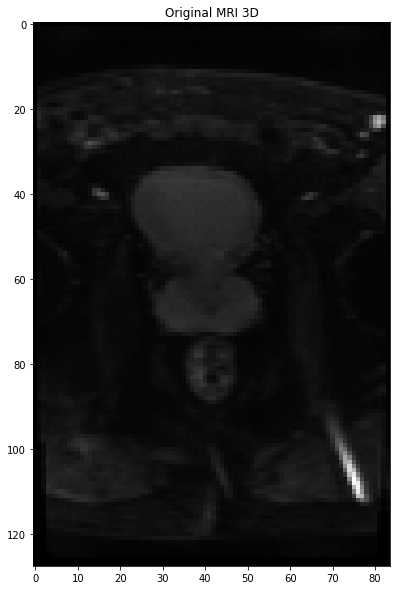

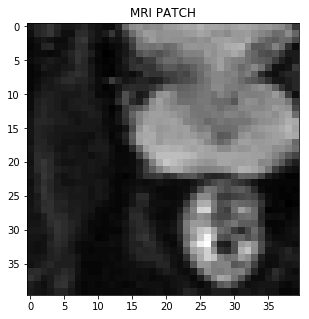

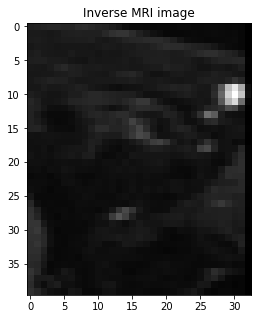

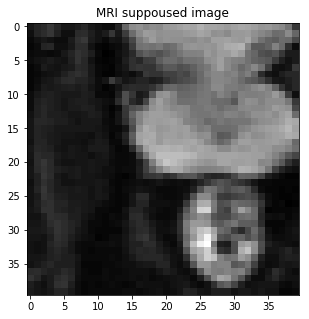

In [52]:
def show_MRI_example(dataset,index):
    row = dataset.iloc[index]
    print ("Este es el paciente {}".format(row.ProxID))
    print ("El diagnostico de este paciente es : {}".format(row.ClinSig))
    print ("El ijk de este paciente es : {}".format(row.ijk))
    print ("La descripción de la imagen dicom es : {}".format(row.Name))
    print ("Este es el finding # {}".format(row.fid))
    print ("El estado de los datos es :{}".format(row.State))
    ijk = row.ijk.split()
    x = int (ijk[0])
    y = int (ijk[1])
    z = int (ijk[2])
    plt.figure(figsize=(10,10))
    plt.imshow(row.MRI3D[z],cmap='gray')
    plt.title("Original MRI 3D")
    plt.figure(figsize=(5,5))
    plt.imshow(row.MRIPatch3D[1],cmap='gray')
    plt.title("MRI PATCH")
    plt.figure(figsize=(5,5))
    plt.imshow(row.MRI3D[z, x - 20 : x + 20, y-20 : y+20],cmap='gray')
    plt.title("Inverse MRI image")
    plt.figure(figsize=(5,5))
    plt.imshow(row.MRI3D[z, y-20 : y+20, x - 20 : x + 20], cmap='gray')
    plt.title("MRI suppoused image")
    
show_MRI_example(training_MRI_imgs_dataframe,23)
#show_MRI_example(testing_MRI_imgs_dataframe,0)

In [145]:
def get_dataframe_given_zone(zone, dataFrame):
    dataFrame = dataFrame[dataFrame.zone == zone]
    return dataFrame

In [146]:
training_ktrans_imgs_dataframe = training_ktrans_imgs_dataframe [training_ktrans_imgs_dataframe.State == False] 
training_ktrans_imgs_dataframe_at_PZ = get_dataframe_given_zone("PZ", training_ktrans_imgs_dataframe)
training_ktrans_imgs_dataframe_at_AS = get_dataframe_given_zone("AS", training_ktrans_imgs_dataframe)
training_ktrans_imgs_dataframe_at_TZ = get_dataframe_given_zone("TZ", training_ktrans_imgs_dataframe)
training_ktrans_imgs_dataframe_at_SV = get_dataframe_given_zone("SV", training_ktrans_imgs_dataframe)

In [147]:
def get_data_labels (dataFrame):
    indexes = dataFrame.index
    data = dataFrame.KimgPatch3D
    labels = dataFrame.ClinSig
    z,y,x = [3,40,40]
    all_data = np.empty(shape= (len(data), z*y*x ) )
    all_labels = np.zeros(shape= (len(data) ) )
    i = 0
    for index in indexes:
        all_data[i,:] = data[index].reshape((1,x*y*z))
        label = labels [index]
        all_labels[i] = label
        i = i + 1
    return all_data, all_labels

In [169]:
def apply_Kfold_cross_validation(dataframe, classifier, kfolds):
    from sklearn.model_selection import cross_val_score
    data, labels = get_data_labels(dataframe)
    scores = cross_val_score(classifier, data, labels, cv= kfolds)
    print(scores)
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    return scores, scores.mean(), scores.std()*2

In [170]:
results = []
classifier = tree.DecisionTreeClassifier()
print ("Decision Tree Classifier")
dataframe = training_ktrans_imgs_dataframe_at_PZ
kfolds = 8
experiments , mean, std = apply_Kfold_cross_validation(dataframe, classifier, kfolds)
results.append(["Decision Tree",experiments, mean, std , "PZ"])
print("=========================================================")
dataframe = training_ktrans_imgs_dataframe_at_TZ
experiments , mean, std = apply_Kfold_cross_validation(dataframe, classifier, kfolds)
results.append(["Decision Tree",experiments, mean, std , "TZ"])
print("=========================================================")
dataframe = training_ktrans_imgs_dataframe_at_AS
experiments , mean, std = apply_Kfold_cross_validation(dataframe,classifier, kfolds)
results.append(["Decision Tree",experiments, mean, std , "AS"])

Decision Tree Classifier
[0.69230769 0.73076923 0.80769231 0.8        0.92       0.83333333
 0.66666667 0.625     ]
Accuracy: 0.76 (+/- 0.18)
[0.66666667 0.72727273 0.90909091 0.9        0.9        0.8
 0.9        0.8       ]
Accuracy: 0.83 (+/- 0.17)
[0.14285714 0.57142857 0.71428571 0.57142857 0.85714286 0.42857143
 0.71428571 0.5       ]
Accuracy: 0.56 (+/- 0.41)


In [171]:
classifier = GaussianNB()
print ("GaussianNB Classifier")
dataframe = training_ktrans_imgs_dataframe_at_PZ
kfolds = 8
experiments , mean, std = apply_Kfold_cross_validation(dataframe, classifier, kfolds)
results.append(["GaussianNB",experiments, mean, std , "PZ"])
print("=========================================================")
dataframe = training_ktrans_imgs_dataframe_at_TZ
experiments , mean, std = apply_Kfold_cross_validation(dataframe, classifier, kfolds)
results.append(["GaussianNB",experiments, mean, std , "TZ"])
print("=========================================================")
dataframe = training_ktrans_imgs_dataframe_at_AS
experiments , mean, std = apply_Kfold_cross_validation(dataframe,classifier, kfolds)
results.append(["GaussianNB",experiments, mean, std , "AS"])

GaussianNB Classifier
[0.65384615 0.65384615 0.65384615 0.72       0.68       0.625
 0.625      0.33333333]
Accuracy: 0.62 (+/- 0.22)
[0.66666667 0.63636364 0.27272727 0.9        0.9        0.7
 0.8        0.9       ]
Accuracy: 0.72 (+/- 0.40)
[0.42857143 0.71428571 0.71428571 0.71428571 0.57142857 0.57142857
 0.42857143 0.5       ]
Accuracy: 0.58 (+/- 0.23)


In [172]:
classifier = svm.SVC(kernel='linear', C=1)
print("SVM Classifier linear")
dataframe = training_ktrans_imgs_dataframe_at_PZ
kfolds = 8
experiments , mean, std = apply_Kfold_cross_validation(dataframe, classifier, kfolds)
results.append(["SVM Linear",experiments, mean, std , "PZ"])
print("=========================================================")
dataframe = training_ktrans_imgs_dataframe_at_TZ
experiments , mean, std = apply_Kfold_cross_validation(dataframe, classifier, kfolds)
results.append(["SVM Linear",experiments, mean, std , "TZ"])
print("=========================================================")
dataframe = training_ktrans_imgs_dataframe_at_AS
experiments , mean, std = apply_Kfold_cross_validation(dataframe,classifier, kfolds)
results.append(["SVM Linear",experiments, mean, std , "AS"])

SVM Classifier linear
[0.73076923 0.73076923 0.69230769 0.72       0.76       0.70833333
 0.70833333 0.75      ]
Accuracy: 0.73 (+/- 0.04)
[0.83333333 0.72727273 0.90909091 0.9        0.9        0.9
 0.7        0.9       ]
Accuracy: 0.85 (+/- 0.16)
[0.28571429 0.85714286 1.         0.71428571 0.57142857 0.85714286
 0.57142857 0.5       ]
Accuracy: 0.67 (+/- 0.43)


In [173]:
classifier = svm.SVC(kernel='poly', C=1)
print("SVM Classifier poly")
dataframe = training_ktrans_imgs_dataframe_at_PZ
kfolds = 8
experiments , mean, std = apply_Kfold_cross_validation(dataframe, classifier, kfolds)
results.append(["SVM poly",experiments, mean, std , "PZ"])
print("=========================================================")
dataframe = training_ktrans_imgs_dataframe_at_TZ
experiments , mean, std = apply_Kfold_cross_validation(dataframe, classifier, kfolds)
results.append(["SVM poly",experiments, mean, std , "TZ"])
print("=========================================================")
dataframe = training_ktrans_imgs_dataframe_at_AS
experiments , mean, std = apply_Kfold_cross_validation(dataframe,classifier, kfolds)
results.append(["SVM poly",experiments, mean, std , "AS"])

SVM Classifier poly
[0.80769231 0.61538462 0.84615385 0.8        0.88       0.79166667
 0.70833333 0.79166667]
Accuracy: 0.78 (+/- 0.15)
[0.66666667 0.63636364 0.81818182 0.9        0.9        0.9
 0.7        0.9       ]
Accuracy: 0.80 (+/- 0.22)
[0.14285714 0.85714286 0.85714286 0.57142857 0.57142857 0.57142857
 0.57142857 0.33333333]
Accuracy: 0.56 (+/- 0.45)


In [174]:
classifier = svm.SVC(kernel='rbf', C=1)
print("SVM Classifier rbf")
dataframe = training_ktrans_imgs_dataframe_at_PZ
kfolds = 8
experiments , mean, std = apply_Kfold_cross_validation(dataframe, classifier, kfolds)
results.append(["SVM rbf",experiments, mean, std , "PZ"])
print("=========================================================")
dataframe = training_ktrans_imgs_dataframe_at_TZ
experiments , mean, std = apply_Kfold_cross_validation(dataframe, classifier, kfolds)
results.append(["SVM rbf",experiments, mean, std , "TZ"])
print("=========================================================")
dataframe = training_ktrans_imgs_dataframe_at_AS
experiments , mean, std = apply_Kfold_cross_validation(dataframe,classifier, kfolds)
results.append(["SVM rbf",experiments, mean, std , "AS"])

SVM Classifier rbf
[0.80769231 0.80769231 0.80769231 0.8        0.8        0.83333333
 0.83333333 0.83333333]
Accuracy: 0.82 (+/- 0.03)
[0.83333333 0.90909091 0.90909091 0.9        0.9        0.9
 0.9        0.9       ]
Accuracy: 0.89 (+/- 0.05)
[0.57142857 0.71428571 0.85714286 0.71428571 0.71428571 0.71428571
 0.57142857 0.5       ]
Accuracy: 0.67 (+/- 0.21)


In [175]:
n_estimators = 20
classifier = RandomForestClassifier(n_estimators=n_estimators)
print("Random Forest 20")
dataframe = training_ktrans_imgs_dataframe_at_PZ
kfolds = 8
experiments , mean, std = apply_Kfold_cross_validation(dataframe, classifier, kfolds)
results.append(["Random Forest 20",experiments, mean, std , "PZ"])
print("=========================================================")
dataframe = training_ktrans_imgs_dataframe_at_TZ
experiments , mean, std = apply_Kfold_cross_validation(dataframe, classifier, kfolds)
results.append(["Random Forest 20",experiments, mean, std , "TZ"])
print("=========================================================")
dataframe = training_ktrans_imgs_dataframe_at_AS
experiments , mean, std = apply_Kfold_cross_validation(dataframe,classifier, kfolds)
results.append(["Random Forest 20",experiments, mean, std , "AS"])

Random Forest 20
[0.80769231 0.73076923 0.80769231 0.8        0.84       0.83333333
 0.75       0.83333333]
Accuracy: 0.80 (+/- 0.07)
[0.83333333 0.90909091 0.90909091 0.9        0.9        0.9
 0.9        0.9       ]
Accuracy: 0.89 (+/- 0.05)
[0.28571429 0.85714286 0.71428571 0.57142857 0.71428571 0.71428571
 0.28571429 0.66666667]
Accuracy: 0.60 (+/- 0.39)


In [176]:
n_neighbors=20
classifier = neighbors.KNeighborsClassifier(n_neighbors)
print("K Nearest Neighbors 20")
dataframe = training_ktrans_imgs_dataframe_at_PZ
kfolds = 8
experiments , mean, std = apply_Kfold_cross_validation(dataframe, classifier, kfolds)
results.append(["K Nearest Neighbors 20",experiments, mean, std , "PZ"])
print("=========================================================")
dataframe = training_ktrans_imgs_dataframe_at_TZ
experiments , mean, std = apply_Kfold_cross_validation(dataframe, classifier, kfolds)
results.append(["K Nearest Neighbors 20",experiments, mean, std , "TZ"])
print("=========================================================")
dataframe = training_ktrans_imgs_dataframe_at_AS
experiments , mean, std = apply_Kfold_cross_validation(dataframe,classifier, kfolds)
results.append(["K Nearest Neighbors 20",experiments, mean, std , "AS"])

K Nearest Neighbors 20
[0.80769231 0.80769231 0.80769231 0.84       0.8        0.83333333
 0.83333333 0.83333333]
Accuracy: 0.82 (+/- 0.03)
[0.83333333 0.90909091 0.90909091 0.9        0.9        0.9
 0.9        0.9       ]
Accuracy: 0.89 (+/- 0.05)
[0.42857143 0.85714286 1.         0.85714286 0.57142857 0.85714286
 0.42857143 0.5       ]
Accuracy: 0.69 (+/- 0.43)


In [179]:
results_dataframe = pd.DataFrame(data= results, columns=["Classifier", "Scores", "Scores's mean", "Scores's std",'Zone'])
display(results_dataframe)

,Classifier,Scores,Scores's mean,Scores's std,Zone
0,Decision Tree,"[0.6923076923076923, 0.7307692307692307, 0.807...",0.759471,0.183334,PZ
1,Decision Tree,"[0.6666666666666666, 0.7272727272727273, 0.909...",0.825379,0.172938,TZ
2,Decision Tree,"[0.14285714285714285, 0.5714285714285714, 0.71...",0.562500,0.406814,AS
3,GaussianNB,"[0.6538461538461539, 0.6538461538461539, 0.653...",0.618109,0.222751,PZ
4,GaussianNB,"[0.6666666666666666, 0.6363636363636364, 0.272...",0.721970,0.396145,TZ
5,GaussianNB,"[0.42857142857142855, 0.7142857142857143, 0.71...",0.580357,0.230765,AS
6,SVM Linear,"[0.7307692307692307, 0.7307692307692307, 0.692...",0.725064,0.042225,PZ
7,SVM Linear,"[0.8333333333333334, 0.7272727272727273, 0.909...",0.846212,0.160026,TZ
8,SVM Linear,"[0.2857142857142857, 0.8571428571428571, 1.0, ...",0.669643,0.434116,AS
9,SVM poly,"[0.8076923076923077, 0.6153846153846154, 0.846...",0.780112,0.154999,PZ
